In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (298136, 2) (74085, 2)


train/valid # (195544, 2) (49748, 2)
train/valid # (195544, 2) (49748, 2)


rand split across time
train has 195544 records out of 372221 records
valid has 49748 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1527
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1527 [..............................] - ETA: 42:06 - loss: 8.1070 - total_loss: 8.1070 - reg_loss: 8.1070

   6/1527 [..............................] - ETA: 7:13 - loss: 2.5829 - total_loss: 2.5829 - reg_loss: 2.5829 

  11/1527 [..............................] - ETA: 4:03 - loss: 1.7994 - total_loss: 1.7994 - reg_loss: 1.7994

  16/1527 [..............................] - ETA: 2:51 - loss: 1.4170 - total_loss: 1.4170 - reg_loss: 1.4170

  21/1527 [..............................] - ETA: 2:14 - loss: 1.2237 - total_loss: 1.2237 - reg_loss: 1.2237

  26/1527 [..............................] - ETA: 1:50 - loss: 1.0749 - total_loss: 1.0749 - reg_loss: 1.0749

  31/1527 [..............................] - ETA: 1:35 - loss: 0.9626 - total_loss: 0.9626 - reg_loss: 0.9626

  37/1527 [..............................] - ETA: 1:21 - loss: 0.8714 - total_loss: 0.8714 - reg_loss: 0.8714

  42/1527 [..............................] - ETA: 1:13 - loss: 0.8116 - total_loss: 0.8116 - reg_loss: 0.8116

  47/1527 [..............................] - ETA: 1:07 - loss: 0.7677 - total_loss: 0.7677 - reg_loss: 0.7677

  52/1527 [>.............................] - ETA: 1:02 - loss: 0.7258 - total_loss: 0.7258 - reg_loss: 0.7258

  57/1527 [>.............................] - ETA: 57s - loss: 0.6939 - total_loss: 0.6939 - reg_loss: 0.6939 

  62/1527 [>.............................] - ETA: 54s - loss: 0.6702 - total_loss: 0.6702 - reg_loss: 0.6702

  67/1527 [>.............................] - ETA: 51s - loss: 0.6481 - total_loss: 0.6481 - reg_loss: 0.6481

  72/1527 [>.............................] - ETA: 48s - loss: 0.6286 - total_loss: 0.6286 - reg_loss: 0.6286

  77/1527 [>.............................] - ETA: 46s - loss: 0.6096 - total_loss: 0.6096 - reg_loss: 0.6096

  83/1527 [>.............................] - ETA: 43s - loss: 0.5866 - total_loss: 0.5866 - reg_loss: 0.5866

  88/1527 [>.............................] - ETA: 41s - loss: 0.5746 - total_loss: 0.5746 - reg_loss: 0.5746

  93/1527 [>.............................] - ETA: 40s - loss: 0.5629 - total_loss: 0.5629 - reg_loss: 0.5629

  98/1527 [>.............................] - ETA: 38s - loss: 0.5513 - total_loss: 0.5513 - reg_loss: 0.5513

 103/1527 [=>............................] - ETA: 37s - loss: 0.5416 - total_loss: 0.5416 - reg_loss: 0.5416

 109/1527 [=>............................] - ETA: 36s - loss: 0.5302 - total_loss: 0.5302 - reg_loss: 0.5302

 114/1527 [=>............................] - ETA: 35s - loss: 0.5222 - total_loss: 0.5222 - reg_loss: 0.5222

 119/1527 [=>............................] - ETA: 34s - loss: 0.5138 - total_loss: 0.5138 - reg_loss: 0.5138

 124/1527 [=>............................] - ETA: 33s - loss: 0.5054 - total_loss: 0.5054 - reg_loss: 0.5054

 129/1527 [=>............................] - ETA: 32s - loss: 0.4980 - total_loss: 0.4980 - reg_loss: 0.4980

 134/1527 [=>............................] - ETA: 31s - loss: 0.4922 - total_loss: 0.4922 - reg_loss: 0.4922

 139/1527 [=>............................] - ETA: 30s - loss: 0.4872 - total_loss: 0.4872 - reg_loss: 0.4872

 145/1527 [=>............................] - ETA: 29s - loss: 0.4793 - total_loss: 0.4793 - reg_loss: 0.4793

 150/1527 [=>............................] - ETA: 29s - loss: 0.4749 - total_loss: 0.4749 - reg_loss: 0.4749

 155/1527 [==>...........................] - ETA: 28s - loss: 0.4706 - total_loss: 0.4706 - reg_loss: 0.4706

 161/1527 [==>...........................] - ETA: 28s - loss: 0.4667 - total_loss: 0.4667 - reg_loss: 0.4667

 166/1527 [==>...........................] - ETA: 27s - loss: 0.4640 - total_loss: 0.4640 - reg_loss: 0.4640

 171/1527 [==>...........................] - ETA: 27s - loss: 0.4614 - total_loss: 0.4614 - reg_loss: 0.4614

 176/1527 [==>...........................] - ETA: 26s - loss: 0.4585 - total_loss: 0.4585 - reg_loss: 0.4585

 182/1527 [==>...........................] - ETA: 25s - loss: 0.4566 - total_loss: 0.4566 - reg_loss: 0.4566

 187/1527 [==>...........................] - ETA: 25s - loss: 0.4543 - total_loss: 0.4543 - reg_loss: 0.4543

 192/1527 [==>...........................] - ETA: 25s - loss: 0.4511 - total_loss: 0.4511 - reg_loss: 0.4511

 197/1527 [==>...........................] - ETA: 24s - loss: 0.4491 - total_loss: 0.4491 - reg_loss: 0.4491

 202/1527 [==>...........................] - ETA: 24s - loss: 0.4460 - total_loss: 0.4460 - reg_loss: 0.4460

 208/1527 [===>..........................] - ETA: 24s - loss: 0.4425 - total_loss: 0.4425 - reg_loss: 0.4425

 213/1527 [===>..........................] - ETA: 23s - loss: 0.4416 - total_loss: 0.4416 - reg_loss: 0.4416

 218/1527 [===>..........................] - ETA: 23s - loss: 0.4397 - total_loss: 0.4397 - reg_loss: 0.4397

 223/1527 [===>..........................] - ETA: 23s - loss: 0.4381 - total_loss: 0.4381 - reg_loss: 0.4381

 228/1527 [===>..........................] - ETA: 22s - loss: 0.4351 - total_loss: 0.4351 - reg_loss: 0.4351

 233/1527 [===>..........................] - ETA: 22s - loss: 0.4315 - total_loss: 0.4315 - reg_loss: 0.4315

 238/1527 [===>..........................] - ETA: 22s - loss: 0.4290 - total_loss: 0.4290 - reg_loss: 0.4290

 243/1527 [===>..........................] - ETA: 21s - loss: 0.4264 - total_loss: 0.4264 - reg_loss: 0.4264

 249/1527 [===>..........................] - ETA: 21s - loss: 0.4233 - total_loss: 0.4233 - reg_loss: 0.4233

 255/1527 [====>.........................] - ETA: 21s - loss: 0.4213 - total_loss: 0.4213 - reg_loss: 0.4213

 260/1527 [====>.........................] - ETA: 21s - loss: 0.4190 - total_loss: 0.4190 - reg_loss: 0.4190

 265/1527 [====>.........................] - ETA: 20s - loss: 0.4170 - total_loss: 0.4170 - reg_loss: 0.4170

 270/1527 [====>.........................] - ETA: 20s - loss: 0.4149 - total_loss: 0.4149 - reg_loss: 0.4149

 276/1527 [====>.........................] - ETA: 20s - loss: 0.4126 - total_loss: 0.4126 - reg_loss: 0.4126

 281/1527 [====>.........................] - ETA: 20s - loss: 0.4105 - total_loss: 0.4105 - reg_loss: 0.4105

 286/1527 [====>.........................] - ETA: 19s - loss: 0.4092 - total_loss: 0.4092 - reg_loss: 0.4092

 292/1527 [====>.........................] - ETA: 19s - loss: 0.4063 - total_loss: 0.4063 - reg_loss: 0.4063

 297/1527 [====>.........................] - ETA: 19s - loss: 0.4041 - total_loss: 0.4041 - reg_loss: 0.4041

 302/1527 [====>.........................] - ETA: 19s - loss: 0.4022 - total_loss: 0.4022 - reg_loss: 0.4022

 307/1527 [=====>........................] - ETA: 19s - loss: 0.4008 - total_loss: 0.4008 - reg_loss: 0.4008

 313/1527 [=====>........................] - ETA: 18s - loss: 0.3992 - total_loss: 0.3992 - reg_loss: 0.3992

 319/1527 [=====>........................] - ETA: 18s - loss: 0.3976 - total_loss: 0.3976 - reg_loss: 0.3976

 324/1527 [=====>........................] - ETA: 18s - loss: 0.3959 - total_loss: 0.3959 - reg_loss: 0.3959

 329/1527 [=====>........................] - ETA: 18s - loss: 0.3942 - total_loss: 0.3942 - reg_loss: 0.3942

 334/1527 [=====>........................] - ETA: 18s - loss: 0.3933 - total_loss: 0.3933 - reg_loss: 0.3933

 339/1527 [=====>........................] - ETA: 17s - loss: 0.3917 - total_loss: 0.3917 - reg_loss: 0.3917

 344/1527 [=====>........................] - ETA: 17s - loss: 0.3908 - total_loss: 0.3908 - reg_loss: 0.3908

 349/1527 [=====>........................] - ETA: 17s - loss: 0.3892 - total_loss: 0.3892 - reg_loss: 0.3892

 354/1527 [=====>........................] - ETA: 17s - loss: 0.3876 - total_loss: 0.3876 - reg_loss: 0.3876

 359/1527 [======>.......................] - ETA: 17s - loss: 0.3863 - total_loss: 0.3863 - reg_loss: 0.3863

 364/1527 [======>.......................] - ETA: 17s - loss: 0.3853 - total_loss: 0.3853 - reg_loss: 0.3853

 369/1527 [======>.......................] - ETA: 17s - loss: 0.3842 - total_loss: 0.3842 - reg_loss: 0.3842

 374/1527 [======>.......................] - ETA: 16s - loss: 0.3834 - total_loss: 0.3834 - reg_loss: 0.3834

 379/1527 [======>.......................] - ETA: 16s - loss: 0.3826 - total_loss: 0.3826 - reg_loss: 0.3826

 384/1527 [======>.......................] - ETA: 16s - loss: 0.3820 - total_loss: 0.3820 - reg_loss: 0.3820

 389/1527 [======>.......................] - ETA: 16s - loss: 0.3815 - total_loss: 0.3815 - reg_loss: 0.3815

 394/1527 [======>.......................] - ETA: 16s - loss: 0.3805 - total_loss: 0.3805 - reg_loss: 0.3805

 399/1527 [======>.......................] - ETA: 16s - loss: 0.3788 - total_loss: 0.3788 - reg_loss: 0.3788

 404/1527 [======>.......................] - ETA: 16s - loss: 0.3775 - total_loss: 0.3775 - reg_loss: 0.3775

 409/1527 [=======>......................] - ETA: 15s - loss: 0.3769 - total_loss: 0.3769 - reg_loss: 0.3769

 414/1527 [=======>......................] - ETA: 15s - loss: 0.3759 - total_loss: 0.3759 - reg_loss: 0.3759

 419/1527 [=======>......................] - ETA: 15s - loss: 0.3754 - total_loss: 0.3754 - reg_loss: 0.3754

 424/1527 [=======>......................] - ETA: 15s - loss: 0.3749 - total_loss: 0.3749 - reg_loss: 0.3749

 429/1527 [=======>......................] - ETA: 15s - loss: 0.3743 - total_loss: 0.3743 - reg_loss: 0.3743

 435/1527 [=======>......................] - ETA: 15s - loss: 0.3739 - total_loss: 0.3739 - reg_loss: 0.3739

 440/1527 [=======>......................] - ETA: 15s - loss: 0.3738 - total_loss: 0.3738 - reg_loss: 0.3738

 445/1527 [=======>......................] - ETA: 15s - loss: 0.3731 - total_loss: 0.3731 - reg_loss: 0.3731

 450/1527 [=======>......................] - ETA: 14s - loss: 0.3721 - total_loss: 0.3721 - reg_loss: 0.3721

 455/1527 [=======>......................] - ETA: 14s - loss: 0.3715 - total_loss: 0.3715 - reg_loss: 0.3715

 460/1527 [========>.....................] - ETA: 14s - loss: 0.3704 - total_loss: 0.3704 - reg_loss: 0.3704

 465/1527 [========>.....................] - ETA: 14s - loss: 0.3696 - total_loss: 0.3696 - reg_loss: 0.3696

 470/1527 [========>.....................] - ETA: 14s - loss: 0.3690 - total_loss: 0.3690 - reg_loss: 0.3690

 475/1527 [========>.....................] - ETA: 14s - loss: 0.3683 - total_loss: 0.3683 - reg_loss: 0.3683

 480/1527 [========>.....................] - ETA: 14s - loss: 0.3679 - total_loss: 0.3679 - reg_loss: 0.3679

 485/1527 [========>.....................] - ETA: 14s - loss: 0.3672 - total_loss: 0.3672 - reg_loss: 0.3672

 490/1527 [========>.....................] - ETA: 14s - loss: 0.3666 - total_loss: 0.3666 - reg_loss: 0.3666

 495/1527 [========>.....................] - ETA: 14s - loss: 0.3660 - total_loss: 0.3660 - reg_loss: 0.3660

 501/1527 [========>.....................] - ETA: 13s - loss: 0.3654 - total_loss: 0.3654 - reg_loss: 0.3654

 507/1527 [========>.....................] - ETA: 13s - loss: 0.3645 - total_loss: 0.3645 - reg_loss: 0.3645

 512/1527 [=========>....................] - ETA: 13s - loss: 0.3635 - total_loss: 0.3635 - reg_loss: 0.3635

 517/1527 [=========>....................] - ETA: 13s - loss: 0.3627 - total_loss: 0.3627 - reg_loss: 0.3627

 523/1527 [=========>....................] - ETA: 13s - loss: 0.3624 - total_loss: 0.3624 - reg_loss: 0.3624

 529/1527 [=========>....................] - ETA: 13s - loss: 0.3616 - total_loss: 0.3616 - reg_loss: 0.3616

 534/1527 [=========>....................] - ETA: 13s - loss: 0.3608 - total_loss: 0.3608 - reg_loss: 0.3608

 539/1527 [=========>....................] - ETA: 13s - loss: 0.3600 - total_loss: 0.3600 - reg_loss: 0.3600

 544/1527 [=========>....................] - ETA: 13s - loss: 0.3598 - total_loss: 0.3598 - reg_loss: 0.3598

 550/1527 [=========>....................] - ETA: 12s - loss: 0.3592 - total_loss: 0.3592 - reg_loss: 0.3592

 556/1527 [=========>....................] - ETA: 12s - loss: 0.3584 - total_loss: 0.3584 - reg_loss: 0.3584

 561/1527 [==========>...................] - ETA: 12s - loss: 0.3582 - total_loss: 0.3582 - reg_loss: 0.3582

 566/1527 [==========>...................] - ETA: 12s - loss: 0.3574 - total_loss: 0.3574 - reg_loss: 0.3574

 571/1527 [==========>...................] - ETA: 12s - loss: 0.3571 - total_loss: 0.3571 - reg_loss: 0.3571

 577/1527 [==========>...................] - ETA: 12s - loss: 0.3564 - total_loss: 0.3564 - reg_loss: 0.3564

 583/1527 [==========>...................] - ETA: 12s - loss: 0.3559 - total_loss: 0.3559 - reg_loss: 0.3559

 588/1527 [==========>...................] - ETA: 12s - loss: 0.3556 - total_loss: 0.3556 - reg_loss: 0.3556

 593/1527 [==========>...................] - ETA: 12s - loss: 0.3549 - total_loss: 0.3549 - reg_loss: 0.3549

 598/1527 [==========>...................] - ETA: 12s - loss: 0.3546 - total_loss: 0.3546 - reg_loss: 0.3546

 603/1527 [==========>...................] - ETA: 11s - loss: 0.3538 - total_loss: 0.3538 - reg_loss: 0.3538

 608/1527 [==========>...................] - ETA: 11s - loss: 0.3535 - total_loss: 0.3535 - reg_loss: 0.3535

 613/1527 [===========>..................] - ETA: 11s - loss: 0.3526 - total_loss: 0.3526 - reg_loss: 0.3526

 618/1527 [===========>..................] - ETA: 11s - loss: 0.3522 - total_loss: 0.3522 - reg_loss: 0.3522

 623/1527 [===========>..................] - ETA: 11s - loss: 0.3518 - total_loss: 0.3518 - reg_loss: 0.3518

 629/1527 [===========>..................] - ETA: 11s - loss: 0.3511 - total_loss: 0.3511 - reg_loss: 0.3511

 634/1527 [===========>..................] - ETA: 11s - loss: 0.3504 - total_loss: 0.3504 - reg_loss: 0.3504

 640/1527 [===========>..................] - ETA: 11s - loss: 0.3498 - total_loss: 0.3498 - reg_loss: 0.3498

 645/1527 [===========>..................] - ETA: 11s - loss: 0.3493 - total_loss: 0.3493 - reg_loss: 0.3493

 650/1527 [===========>..................] - ETA: 11s - loss: 0.3484 - total_loss: 0.3484 - reg_loss: 0.3484

 655/1527 [===========>..................] - ETA: 11s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477

 660/1527 [===========>..................] - ETA: 11s - loss: 0.3472 - total_loss: 0.3472 - reg_loss: 0.3472

 666/1527 [============>.................] - ETA: 10s - loss: 0.3468 - total_loss: 0.3468 - reg_loss: 0.3468

 671/1527 [============>.................] - ETA: 10s - loss: 0.3466 - total_loss: 0.3466 - reg_loss: 0.3466

 676/1527 [============>.................] - ETA: 10s - loss: 0.3465 - total_loss: 0.3465 - reg_loss: 0.3465

 682/1527 [============>.................] - ETA: 10s - loss: 0.3464 - total_loss: 0.3464 - reg_loss: 0.3464

 687/1527 [============>.................] - ETA: 10s - loss: 0.3464 - total_loss: 0.3464 - reg_loss: 0.3464

 692/1527 [============>.................] - ETA: 10s - loss: 0.3459 - total_loss: 0.3459 - reg_loss: 0.3459

 697/1527 [============>.................] - ETA: 10s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 703/1527 [============>.................] - ETA: 10s - loss: 0.3446 - total_loss: 0.3446 - reg_loss: 0.3446

 709/1527 [============>.................] - ETA: 10s - loss: 0.3441 - total_loss: 0.3441 - reg_loss: 0.3441

 714/1527 [=============>................] - ETA: 10s - loss: 0.3439 - total_loss: 0.3439 - reg_loss: 0.3439

 720/1527 [=============>................] - ETA: 10s - loss: 0.3432 - total_loss: 0.3432 - reg_loss: 0.3432

 725/1527 [=============>................] - ETA: 10s - loss: 0.3427 - total_loss: 0.3427 - reg_loss: 0.3427

 730/1527 [=============>................] - ETA: 9s - loss: 0.3426 - total_loss: 0.3426 - reg_loss: 0.3426 

 735/1527 [=============>................] - ETA: 9s - loss: 0.3422 - total_loss: 0.3422 - reg_loss: 0.3422

 740/1527 [=============>................] - ETA: 9s - loss: 0.3421 - total_loss: 0.3421 - reg_loss: 0.3421

 745/1527 [=============>................] - ETA: 9s - loss: 0.3419 - total_loss: 0.3419 - reg_loss: 0.3419

 750/1527 [=============>................] - ETA: 9s - loss: 0.3418 - total_loss: 0.3418 - reg_loss: 0.3418

 755/1527 [=============>................] - ETA: 9s - loss: 0.3414 - total_loss: 0.3414 - reg_loss: 0.3414

 760/1527 [=============>................] - ETA: 9s - loss: 0.3412 - total_loss: 0.3412 - reg_loss: 0.3412

 765/1527 [==============>...............] - ETA: 9s - loss: 0.3407 - total_loss: 0.3407 - reg_loss: 0.3407

 770/1527 [==============>...............] - ETA: 9s - loss: 0.3402 - total_loss: 0.3402 - reg_loss: 0.3402

 775/1527 [==============>...............] - ETA: 9s - loss: 0.3398 - total_loss: 0.3398 - reg_loss: 0.3398

 780/1527 [==============>...............] - ETA: 9s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 786/1527 [==============>...............] - ETA: 9s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 791/1527 [==============>...............] - ETA: 9s - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391

 796/1527 [==============>...............] - ETA: 8s - loss: 0.3387 - total_loss: 0.3387 - reg_loss: 0.3387

 801/1527 [==============>...............] - ETA: 8s - loss: 0.3381 - total_loss: 0.3381 - reg_loss: 0.3381

 806/1527 [==============>...............] - ETA: 8s - loss: 0.3378 - total_loss: 0.3378 - reg_loss: 0.3378

 811/1527 [==============>...............] - ETA: 8s - loss: 0.3374 - total_loss: 0.3374 - reg_loss: 0.3374

 816/1527 [===============>..............] - ETA: 8s - loss: 0.3371 - total_loss: 0.3371 - reg_loss: 0.3371

 822/1527 [===============>..............] - ETA: 8s - loss: 0.3369 - total_loss: 0.3369 - reg_loss: 0.3369

 827/1527 [===============>..............] - ETA: 8s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 833/1527 [===============>..............] - ETA: 8s - loss: 0.3363 - total_loss: 0.3363 - reg_loss: 0.3363

 838/1527 [===============>..............] - ETA: 8s - loss: 0.3362 - total_loss: 0.3362 - reg_loss: 0.3362

 843/1527 [===============>..............] - ETA: 8s - loss: 0.3358 - total_loss: 0.3358 - reg_loss: 0.3358

 848/1527 [===============>..............] - ETA: 8s - loss: 0.3357 - total_loss: 0.3357 - reg_loss: 0.3357

 853/1527 [===============>..............] - ETA: 8s - loss: 0.3352 - total_loss: 0.3352 - reg_loss: 0.3352

 858/1527 [===============>..............] - ETA: 8s - loss: 0.3349 - total_loss: 0.3349 - reg_loss: 0.3349

 863/1527 [===============>..............] - ETA: 8s - loss: 0.3346 - total_loss: 0.3346 - reg_loss: 0.3346

 868/1527 [================>.............] - ETA: 7s - loss: 0.3344 - total_loss: 0.3344 - reg_loss: 0.3344

 873/1527 [================>.............] - ETA: 7s - loss: 0.3340 - total_loss: 0.3340 - reg_loss: 0.3340

 878/1527 [================>.............] - ETA: 7s - loss: 0.3340 - total_loss: 0.3340 - reg_loss: 0.3340

 883/1527 [================>.............] - ETA: 7s - loss: 0.3337 - total_loss: 0.3337 - reg_loss: 0.3337

 888/1527 [================>.............] - ETA: 7s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 893/1527 [================>.............] - ETA: 7s - loss: 0.3337 - total_loss: 0.3337 - reg_loss: 0.3337

 898/1527 [================>.............] - ETA: 7s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 904/1527 [================>.............] - ETA: 7s - loss: 0.3334 - total_loss: 0.3334 - reg_loss: 0.3334

 909/1527 [================>.............] - ETA: 7s - loss: 0.3331 - total_loss: 0.3331 - reg_loss: 0.3331

 914/1527 [================>.............] - ETA: 7s - loss: 0.3331 - total_loss: 0.3331 - reg_loss: 0.3331

 919/1527 [=================>............] - ETA: 7s - loss: 0.3329 - total_loss: 0.3329 - reg_loss: 0.3329

 924/1527 [=================>............] - ETA: 7s - loss: 0.3327 - total_loss: 0.3327 - reg_loss: 0.3327

 930/1527 [=================>............] - ETA: 7s - loss: 0.3324 - total_loss: 0.3324 - reg_loss: 0.3324

 936/1527 [=================>............] - ETA: 7s - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322

 941/1527 [=================>............] - ETA: 7s - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321

 946/1527 [=================>............] - ETA: 6s - loss: 0.3319 - total_loss: 0.3319 - reg_loss: 0.3319

 951/1527 [=================>............] - ETA: 6s - loss: 0.3315 - total_loss: 0.3315 - reg_loss: 0.3315

 956/1527 [=================>............] - ETA: 6s - loss: 0.3315 - total_loss: 0.3315 - reg_loss: 0.3315

 961/1527 [=================>............] - ETA: 6s - loss: 0.3312 - total_loss: 0.3312 - reg_loss: 0.3312

 966/1527 [=================>............] - ETA: 6s - loss: 0.3310 - total_loss: 0.3310 - reg_loss: 0.3310

 972/1527 [==================>...........] - ETA: 6s - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309

 977/1527 [==================>...........] - ETA: 6s - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309

 982/1527 [==================>...........] - ETA: 6s - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307

 987/1527 [==================>...........] - ETA: 6s - loss: 0.3305 - total_loss: 0.3305 - reg_loss: 0.3305

 992/1527 [==================>...........] - ETA: 6s - loss: 0.3303 - total_loss: 0.3303 - reg_loss: 0.3303

 998/1527 [==================>...........] - ETA: 6s - loss: 0.3300 - total_loss: 0.3300 - reg_loss: 0.3300

1003/1527 [==================>...........] - ETA: 6s - loss: 0.3300 - total_loss: 0.3300 - reg_loss: 0.3300

1009/1527 [==================>...........] - ETA: 6s - loss: 0.3300 - total_loss: 0.3300 - reg_loss: 0.3300

1015/1527 [==================>...........] - ETA: 6s - loss: 0.3295 - total_loss: 0.3295 - reg_loss: 0.3295

1020/1527 [===================>..........] - ETA: 6s - loss: 0.3293 - total_loss: 0.3293 - reg_loss: 0.3293

1025/1527 [===================>..........] - ETA: 5s - loss: 0.3291 - total_loss: 0.3291 - reg_loss: 0.3291

1031/1527 [===================>..........] - ETA: 5s - loss: 0.3288 - total_loss: 0.3288 - reg_loss: 0.3288

1036/1527 [===================>..........] - ETA: 5s - loss: 0.3285 - total_loss: 0.3285 - reg_loss: 0.3285

1041/1527 [===================>..........] - ETA: 5s - loss: 0.3282 - total_loss: 0.3282 - reg_loss: 0.3282

1047/1527 [===================>..........] - ETA: 5s - loss: 0.3281 - total_loss: 0.3281 - reg_loss: 0.3281

1052/1527 [===================>..........] - ETA: 5s - loss: 0.3279 - total_loss: 0.3279 - reg_loss: 0.3279

1058/1527 [===================>..........] - ETA: 5s - loss: 0.3278 - total_loss: 0.3278 - reg_loss: 0.3278

1064/1527 [===================>..........] - ETA: 5s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

1069/1527 [====================>.........] - ETA: 5s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

1074/1527 [====================>.........] - ETA: 5s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

1080/1527 [====================>.........] - ETA: 5s - loss: 0.3274 - total_loss: 0.3274 - reg_loss: 0.3274

1085/1527 [====================>.........] - ETA: 5s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

1090/1527 [====================>.........] - ETA: 5s - loss: 0.3273 - total_loss: 0.3273 - reg_loss: 0.3273

1095/1527 [====================>.........] - ETA: 5s - loss: 0.3271 - total_loss: 0.3271 - reg_loss: 0.3271

1100/1527 [====================>.........] - ETA: 5s - loss: 0.3270 - total_loss: 0.3270 - reg_loss: 0.3270

1105/1527 [====================>.........] - ETA: 4s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

1110/1527 [====================>.........] - ETA: 4s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

1115/1527 [====================>.........] - ETA: 4s - loss: 0.3270 - total_loss: 0.3270 - reg_loss: 0.3270

1120/1527 [=====================>........] - ETA: 4s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

1126/1527 [=====================>........] - ETA: 4s - loss: 0.3267 - total_loss: 0.3267 - reg_loss: 0.3267

1131/1527 [=====================>........] - ETA: 4s - loss: 0.3265 - total_loss: 0.3265 - reg_loss: 0.3265

1136/1527 [=====================>........] - ETA: 4s - loss: 0.3263 - total_loss: 0.3263 - reg_loss: 0.3263

1141/1527 [=====================>........] - ETA: 4s - loss: 0.3261 - total_loss: 0.3261 - reg_loss: 0.3261

1146/1527 [=====================>........] - ETA: 4s - loss: 0.3260 - total_loss: 0.3260 - reg_loss: 0.3260

1151/1527 [=====================>........] - ETA: 4s - loss: 0.3257 - total_loss: 0.3257 - reg_loss: 0.3257

1156/1527 [=====================>........] - ETA: 4s - loss: 0.3254 - total_loss: 0.3254 - reg_loss: 0.3254

1161/1527 [=====================>........] - ETA: 4s - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253

1166/1527 [=====================>........] - ETA: 4s - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251

1171/1527 [======================>.......] - ETA: 4s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

1176/1527 [======================>.......] - ETA: 4s - loss: 0.3249 - total_loss: 0.3249 - reg_loss: 0.3249

1181/1527 [======================>.......] - ETA: 4s - loss: 0.3247 - total_loss: 0.3247 - reg_loss: 0.3247

1186/1527 [======================>.......] - ETA: 3s - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245

1191/1527 [======================>.......] - ETA: 3s - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242

1196/1527 [======================>.......] - ETA: 3s - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243

1201/1527 [======================>.......] - ETA: 3s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

1206/1527 [======================>.......] - ETA: 3s - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237

1211/1527 [======================>.......] - ETA: 3s - loss: 0.3236 - total_loss: 0.3236 - reg_loss: 0.3236

1216/1527 [======================>.......] - ETA: 3s - loss: 0.3234 - total_loss: 0.3234 - reg_loss: 0.3234

1222/1527 [=======================>......] - ETA: 3s - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233

1227/1527 [=======================>......] - ETA: 3s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1232/1527 [=======================>......] - ETA: 3s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1237/1527 [=======================>......] - ETA: 3s - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232

1242/1527 [=======================>......] - ETA: 3s - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230

1247/1527 [=======================>......] - ETA: 3s - loss: 0.3229 - total_loss: 0.3229 - reg_loss: 0.3229

1252/1527 [=======================>......] - ETA: 3s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1257/1527 [=======================>......] - ETA: 3s - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226

1262/1527 [=======================>......] - ETA: 3s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

1267/1527 [=======================>......] - ETA: 2s - loss: 0.3222 - total_loss: 0.3222 - reg_loss: 0.3222

1273/1527 [========================>.....] - ETA: 2s - loss: 0.3219 - total_loss: 0.3219 - reg_loss: 0.3219

1278/1527 [========================>.....] - ETA: 2s - loss: 0.3216 - total_loss: 0.3216 - reg_loss: 0.3216

1283/1527 [========================>.....] - ETA: 2s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

1288/1527 [========================>.....] - ETA: 2s - loss: 0.3212 - total_loss: 0.3212 - reg_loss: 0.3212

1293/1527 [========================>.....] - ETA: 2s - loss: 0.3210 - total_loss: 0.3210 - reg_loss: 0.3210

1298/1527 [========================>.....] - ETA: 2s - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208

1303/1527 [========================>.....] - ETA: 2s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

1308/1527 [========================>.....] - ETA: 2s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1314/1527 [========================>.....] - ETA: 2s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1319/1527 [========================>.....] - ETA: 2s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1324/1527 [=========================>....] - ETA: 2s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1329/1527 [=========================>....] - ETA: 2s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1334/1527 [=========================>....] - ETA: 2s - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200

1339/1527 [=========================>....] - ETA: 2s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

1344/1527 [=========================>....] - ETA: 2s - loss: 0.3196 - total_loss: 0.3196 - reg_loss: 0.3196

1350/1527 [=========================>....] - ETA: 2s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

1356/1527 [=========================>....] - ETA: 1s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

1361/1527 [=========================>....] - ETA: 1s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1366/1527 [=========================>....] - ETA: 1s - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188

1371/1527 [=========================>....] - ETA: 1s - loss: 0.3187 - total_loss: 0.3187 - reg_loss: 0.3187

1376/1527 [==========================>...] - ETA: 1s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1381/1527 [==========================>...] - ETA: 1s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1386/1527 [==========================>...] - ETA: 1s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1391/1527 [==========================>...] - ETA: 1s - loss: 0.3182 - total_loss: 0.3182 - reg_loss: 0.3182

1396/1527 [==========================>...] - ETA: 1s - loss: 0.3180 - total_loss: 0.3180 - reg_loss: 0.3180

1401/1527 [==========================>...] - ETA: 1s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1406/1527 [==========================>...] - ETA: 1s - loss: 0.3178 - total_loss: 0.3178 - reg_loss: 0.3178

1411/1527 [==========================>...] - ETA: 1s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1417/1527 [==========================>...] - ETA: 1s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1422/1527 [==========================>...] - ETA: 1s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1428/1527 [===========================>..] - ETA: 1s - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171

1434/1527 [===========================>..] - ETA: 1s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1439/1527 [===========================>..] - ETA: 1s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

1444/1527 [===========================>..] - ETA: 0s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1449/1527 [===========================>..] - ETA: 0s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

1455/1527 [===========================>..] - ETA: 0s - loss: 0.3167 - total_loss: 0.3167 - reg_loss: 0.3167

1461/1527 [===========================>..] - ETA: 0s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1466/1527 [===========================>..] - ETA: 0s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1471/1527 [===========================>..] - ETA: 0s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1477/1527 [============================>.] - ETA: 0s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1482/1527 [============================>.] - ETA: 0s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

1487/1527 [============================>.] - ETA: 0s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

1492/1527 [============================>.] - ETA: 0s - loss: 0.3157 - total_loss: 0.3157 - reg_loss: 0.3157

1497/1527 [============================>.] - ETA: 0s - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156

1502/1527 [============================>.] - ETA: 0s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

1507/1527 [============================>.] - ETA: 0s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1512/1527 [============================>.] - ETA: 0s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1518/1527 [============================>.] - ETA: 0s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1524/1527 [============================>.] - ETA: 0s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

Epoch 00001: saving model to testlstm/model_adam.001.h5
1527/1527 [==============================] - 20s 13ms/step - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150 - val_loss: 0.2560 - val_total_loss: 0.2560 - val_reg_loss: 0.2560


Epoch 2/100
   1/1527 [..............................] - ETA: 17s - loss: 0.2963 - total_loss: 0.2963 - reg_loss: 0.2963

   6/1527 [..............................] - ETA: 16s - loss: 0.2756 - total_loss: 0.2756 - reg_loss: 0.2756

  12/1527 [..............................] - ETA: 15s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

  18/1527 [..............................] - ETA: 15s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

  24/1527 [..............................] - ETA: 15s - loss: 0.2772 - total_loss: 0.2772 - reg_loss: 0.2772

  29/1527 [..............................] - ETA: 15s - loss: 0.2785 - total_loss: 0.2785 - reg_loss: 0.2785

  34/1527 [..............................] - ETA: 15s - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761

  39/1527 [..............................] - ETA: 14s - loss: 0.2777 - total_loss: 0.2777 - reg_loss: 0.2777

  44/1527 [..............................] - ETA: 14s - loss: 0.2778 - total_loss: 0.2778 - reg_loss: 0.2778

  49/1527 [..............................] - ETA: 14s - loss: 0.2761 - total_loss: 0.2761 - reg_loss: 0.2761

  55/1527 [>.............................] - ETA: 14s - loss: 0.2762 - total_loss: 0.2762 - reg_loss: 0.2762

  60/1527 [>.............................] - ETA: 14s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

  65/1527 [>.............................] - ETA: 14s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

  71/1527 [>.............................] - ETA: 14s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

  77/1527 [>.............................] - ETA: 14s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

  83/1527 [>.............................] - ETA: 14s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

  88/1527 [>.............................] - ETA: 14s - loss: 0.2778 - total_loss: 0.2778 - reg_loss: 0.2778

  94/1527 [>.............................] - ETA: 14s - loss: 0.2791 - total_loss: 0.2791 - reg_loss: 0.2791

 100/1527 [>.............................] - ETA: 14s - loss: 0.2795 - total_loss: 0.2795 - reg_loss: 0.2795

 105/1527 [=>............................] - ETA: 14s - loss: 0.2796 - total_loss: 0.2796 - reg_loss: 0.2796

 110/1527 [=>............................] - ETA: 14s - loss: 0.2803 - total_loss: 0.2803 - reg_loss: 0.2803

 115/1527 [=>............................] - ETA: 14s - loss: 0.2794 - total_loss: 0.2794 - reg_loss: 0.2794

 121/1527 [=>............................] - ETA: 14s - loss: 0.2799 - total_loss: 0.2799 - reg_loss: 0.2799

 126/1527 [=>............................] - ETA: 14s - loss: 0.2792 - total_loss: 0.2792 - reg_loss: 0.2792

 131/1527 [=>............................] - ETA: 14s - loss: 0.2796 - total_loss: 0.2796 - reg_loss: 0.2796

 136/1527 [=>............................] - ETA: 14s - loss: 0.2797 - total_loss: 0.2797 - reg_loss: 0.2797

 141/1527 [=>............................] - ETA: 14s - loss: 0.2792 - total_loss: 0.2792 - reg_loss: 0.2792

 146/1527 [=>............................] - ETA: 13s - loss: 0.2784 - total_loss: 0.2784 - reg_loss: 0.2784

 151/1527 [=>............................] - ETA: 13s - loss: 0.2784 - total_loss: 0.2784 - reg_loss: 0.2784

 156/1527 [==>...........................] - ETA: 13s - loss: 0.2787 - total_loss: 0.2787 - reg_loss: 0.2787

 161/1527 [==>...........................] - ETA: 13s - loss: 0.2788 - total_loss: 0.2788 - reg_loss: 0.2788

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2790 - total_loss: 0.2790 - reg_loss: 0.2790

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2785 - total_loss: 0.2785 - reg_loss: 0.2785

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2766 - total_loss: 0.2766 - reg_loss: 0.2766

 184/1527 [==>...........................] - ETA: 13s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 189/1527 [==>...........................] - ETA: 13s - loss: 0.2759 - total_loss: 0.2759 - reg_loss: 0.2759

 194/1527 [==>...........................] - ETA: 13s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 199/1527 [==>...........................] - ETA: 13s - loss: 0.2771 - total_loss: 0.2771 - reg_loss: 0.2771

 204/1527 [===>..........................] - ETA: 13s - loss: 0.2776 - total_loss: 0.2776 - reg_loss: 0.2776

 209/1527 [===>..........................] - ETA: 13s - loss: 0.2772 - total_loss: 0.2772 - reg_loss: 0.2772

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2777 - total_loss: 0.2777 - reg_loss: 0.2777

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2767 - total_loss: 0.2767 - reg_loss: 0.2767

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2764 - total_loss: 0.2764 - reg_loss: 0.2764

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2773 - total_loss: 0.2773 - reg_loss: 0.2773

 245/1527 [===>..........................] - ETA: 13s - loss: 0.2771 - total_loss: 0.2771 - reg_loss: 0.2771

 251/1527 [===>..........................] - ETA: 12s - loss: 0.2767 - total_loss: 0.2767 - reg_loss: 0.2767

 256/1527 [====>.........................] - ETA: 12s - loss: 0.2772 - total_loss: 0.2772 - reg_loss: 0.2772

 262/1527 [====>.........................] - ETA: 12s - loss: 0.2777 - total_loss: 0.2777 - reg_loss: 0.2777

 267/1527 [====>.........................] - ETA: 12s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

 272/1527 [====>.........................] - ETA: 12s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

 277/1527 [====>.........................] - ETA: 12s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 287/1527 [====>.........................] - ETA: 12s - loss: 0.2762 - total_loss: 0.2762 - reg_loss: 0.2762

 292/1527 [====>.........................] - ETA: 12s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2760 - total_loss: 0.2760 - reg_loss: 0.2760

 303/1527 [====>.........................] - ETA: 12s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 309/1527 [=====>........................] - ETA: 12s - loss: 0.2762 - total_loss: 0.2762 - reg_loss: 0.2762

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2758 - total_loss: 0.2758 - reg_loss: 0.2758

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 337/1527 [=====>........................] - ETA: 12s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 343/1527 [=====>........................] - ETA: 12s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 349/1527 [=====>........................] - ETA: 11s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 355/1527 [=====>........................] - ETA: 11s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 360/1527 [======>.......................] - ETA: 11s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 365/1527 [======>.......................] - ETA: 11s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 370/1527 [======>.......................] - ETA: 11s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 375/1527 [======>.......................] - ETA: 11s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 438/1527 [=======>......................] - ETA: 11s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 443/1527 [=======>......................] - ETA: 11s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 448/1527 [=======>......................] - ETA: 10s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 453/1527 [=======>......................] - ETA: 10s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 458/1527 [=======>......................] - ETA: 10s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 505/1527 [========>.....................] - ETA: 10s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 510/1527 [=========>....................] - ETA: 10s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 515/1527 [=========>....................] - ETA: 10s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 520/1527 [=========>....................] - ETA: 10s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 525/1527 [=========>....................] - ETA: 10s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

 531/1527 [=========>....................] - ETA: 10s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 536/1527 [=========>....................] - ETA: 10s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 542/1527 [=========>....................] - ETA: 10s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 547/1527 [=========>....................] - ETA: 9s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743 

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 558/1527 [=========>....................] - ETA: 9s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 563/1527 [==========>...................] - ETA: 9s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 568/1527 [==========>...................] - ETA: 9s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 584/1527 [==========>...................] - ETA: 9s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 589/1527 [==========>...................] - ETA: 9s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 594/1527 [==========>...................] - ETA: 9s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 599/1527 [==========>...................] - ETA: 9s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 604/1527 [==========>...................] - ETA: 9s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 609/1527 [==========>...................] - ETA: 9s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 634/1527 [===========>..................] - ETA: 9s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 644/1527 [===========>..................] - ETA: 8s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 650/1527 [===========>..................] - ETA: 8s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 662/1527 [============>.................] - ETA: 8s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 668/1527 [============>.................] - ETA: 8s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 673/1527 [============>.................] - ETA: 8s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 678/1527 [============>.................] - ETA: 8s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 683/1527 [============>.................] - ETA: 8s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 688/1527 [============>.................] - ETA: 8s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 694/1527 [============>.................] - ETA: 8s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 699/1527 [============>.................] - ETA: 8s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 704/1527 [============>.................] - ETA: 8s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 709/1527 [============>.................] - ETA: 8s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 714/1527 [=============>................] - ETA: 8s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 719/1527 [=============>................] - ETA: 8s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 724/1527 [=============>................] - ETA: 8s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 730/1527 [=============>................] - ETA: 8s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 735/1527 [=============>................] - ETA: 8s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 740/1527 [=============>................] - ETA: 8s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 745/1527 [=============>................] - ETA: 7s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 750/1527 [=============>................] - ETA: 7s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 755/1527 [=============>................] - ETA: 7s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 760/1527 [=============>................] - ETA: 7s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 805/1527 [==============>...............] - ETA: 7s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 810/1527 [==============>...............] - ETA: 7s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 816/1527 [===============>..............] - ETA: 7s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

 837/1527 [===============>..............] - ETA: 7s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 842/1527 [===============>..............] - ETA: 6s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 847/1527 [===============>..............] - ETA: 6s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 852/1527 [===============>..............] - ETA: 6s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 868/1527 [================>.............] - ETA: 6s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 873/1527 [================>.............] - ETA: 6s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 878/1527 [================>.............] - ETA: 6s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 883/1527 [================>.............] - ETA: 6s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 889/1527 [================>.............] - ETA: 6s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 895/1527 [================>.............] - ETA: 6s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 900/1527 [================>.............] - ETA: 6s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 905/1527 [================>.............] - ETA: 6s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 910/1527 [================>.............] - ETA: 6s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 915/1527 [================>.............] - ETA: 6s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

 920/1527 [=================>............] - ETA: 6s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 925/1527 [=================>............] - ETA: 6s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 930/1527 [=================>............] - ETA: 6s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 935/1527 [=================>............] - ETA: 6s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 940/1527 [=================>............] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 945/1527 [=================>............] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 951/1527 [=================>............] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 956/1527 [=================>............] - ETA: 5s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 961/1527 [=================>............] - ETA: 5s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 966/1527 [=================>............] - ETA: 5s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 971/1527 [==================>...........] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 976/1527 [==================>...........] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1002/1527 [==================>...........] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1007/1527 [==================>...........] - ETA: 5s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1012/1527 [==================>...........] - ETA: 5s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1017/1527 [==================>...........] - ETA: 5s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1022/1527 [===================>..........] - ETA: 5s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1027/1527 [===================>..........] - ETA: 5s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1038/1527 [===================>..........] - ETA: 4s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1044/1527 [===================>..........] - ETA: 4s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1094/1527 [====================>.........] - ETA: 4s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1115/1527 [====================>.........] - ETA: 4s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1120/1527 [=====================>........] - ETA: 4s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1137/1527 [=====================>........] - ETA: 3s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1218/1527 [======================>.......] - ETA: 3s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

1233/1527 [=======================>......] - ETA: 3s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1249/1527 [=======================>......] - ETA: 2s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1254/1527 [=======================>......] - ETA: 2s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1259/1527 [=======================>......] - ETA: 2s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1270/1527 [=======================>......] - ETA: 2s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1328/1527 [=========================>....] - ETA: 2s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1350/1527 [=========================>....] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1355/1527 [=========================>....] - ETA: 1s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1372/1527 [=========================>....] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1377/1527 [==========================>...] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1383/1527 [==========================>...] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1388/1527 [==========================>...] - ETA: 1s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1393/1527 [==========================>...] - ETA: 1s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1398/1527 [==========================>...] - ETA: 1s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1403/1527 [==========================>...] - ETA: 1s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1408/1527 [==========================>...] - ETA: 1s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1413/1527 [==========================>...] - ETA: 1s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1418/1527 [==========================>...] - ETA: 1s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1424/1527 [==========================>...] - ETA: 1s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1430/1527 [===========================>..] - ETA: 0s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1440/1527 [===========================>..] - ETA: 0s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1446/1527 [===========================>..] - ETA: 0s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1451/1527 [===========================>..] - ETA: 0s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1477/1527 [============================>.] - ETA: 0s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1482/1527 [============================>.] - ETA: 0s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1487/1527 [============================>.] - ETA: 0s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1492/1527 [============================>.] - ETA: 0s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1497/1527 [============================>.] - ETA: 0s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1502/1527 [============================>.] - ETA: 0s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1507/1527 [============================>.] - ETA: 0s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1512/1527 [============================>.] - ETA: 0s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1517/1527 [============================>.] - ETA: 0s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1522/1527 [============================>.] - ETA: 0s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

Epoch 00002: saving model to testlstm/model_adam.002.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734 - val_loss: 0.2539 - val_total_loss: 0.2539 - val_reg_loss: 0.2539


Epoch 3/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2843 - total_loss: 0.2843 - reg_loss: 0.2843

   6/1527 [..............................] - ETA: 15s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

  12/1527 [..............................] - ETA: 15s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

  17/1527 [..............................] - ETA: 15s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

  23/1527 [..............................] - ETA: 15s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

  29/1527 [..............................] - ETA: 14s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

  34/1527 [..............................] - ETA: 14s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

  40/1527 [..............................] - ETA: 14s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

  46/1527 [..............................] - ETA: 14s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

  52/1527 [>.............................] - ETA: 14s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

  58/1527 [>.............................] - ETA: 14s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

  63/1527 [>.............................] - ETA: 14s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

  68/1527 [>.............................] - ETA: 14s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

  73/1527 [>.............................] - ETA: 14s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

  78/1527 [>.............................] - ETA: 14s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

  83/1527 [>.............................] - ETA: 14s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

  89/1527 [>.............................] - ETA: 14s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

  95/1527 [>.............................] - ETA: 14s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 100/1527 [>.............................] - ETA: 14s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 106/1527 [=>............................] - ETA: 14s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 112/1527 [=>............................] - ETA: 14s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 118/1527 [=>............................] - ETA: 14s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 123/1527 [=>............................] - ETA: 14s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 128/1527 [=>............................] - ETA: 14s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 133/1527 [=>............................] - ETA: 13s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 138/1527 [=>............................] - ETA: 13s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 143/1527 [=>............................] - ETA: 13s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 149/1527 [=>............................] - ETA: 13s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 154/1527 [==>...........................] - ETA: 13s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 159/1527 [==>...........................] - ETA: 13s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 164/1527 [==>...........................] - ETA: 13s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 169/1527 [==>...........................] - ETA: 13s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 175/1527 [==>...........................] - ETA: 13s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 198/1527 [==>...........................] - ETA: 13s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 203/1527 [==>...........................] - ETA: 13s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 209/1527 [===>..........................] - ETA: 13s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 234/1527 [===>..........................] - ETA: 13s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 239/1527 [===>..........................] - ETA: 13s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 244/1527 [===>..........................] - ETA: 13s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 249/1527 [===>..........................] - ETA: 12s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 254/1527 [===>..........................] - ETA: 12s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 259/1527 [====>.........................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 270/1527 [====>.........................] - ETA: 12s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 275/1527 [====>.........................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 280/1527 [====>.........................] - ETA: 12s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 286/1527 [====>.........................] - ETA: 12s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 291/1527 [====>.........................] - ETA: 12s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 296/1527 [====>.........................] - ETA: 12s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 301/1527 [====>.........................] - ETA: 12s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 336/1527 [=====>........................] - ETA: 12s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 341/1527 [=====>........................] - ETA: 12s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 346/1527 [=====>........................] - ETA: 12s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 351/1527 [=====>........................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 366/1527 [======>.......................] - ETA: 11s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 408/1527 [=======>......................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 414/1527 [=======>......................] - ETA: 11s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 429/1527 [=======>......................] - ETA: 11s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 434/1527 [=======>......................] - ETA: 11s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 439/1527 [=======>......................] - ETA: 11s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 444/1527 [=======>......................] - ETA: 11s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 450/1527 [=======>......................] - ETA: 10s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 455/1527 [=======>......................] - ETA: 10s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 460/1527 [========>.....................] - ETA: 10s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 465/1527 [========>.....................] - ETA: 10s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 470/1527 [========>.....................] - ETA: 10s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 475/1527 [========>.....................] - ETA: 10s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 480/1527 [========>.....................] - ETA: 10s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 516/1527 [=========>....................] - ETA: 10s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 521/1527 [=========>....................] - ETA: 10s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 526/1527 [=========>....................] - ETA: 10s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 531/1527 [=========>....................] - ETA: 10s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 536/1527 [=========>....................] - ETA: 10s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 541/1527 [=========>....................] - ETA: 10s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 546/1527 [=========>....................] - ETA: 10s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681 

 557/1527 [=========>....................] - ETA: 9s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 578/1527 [==========>...................] - ETA: 9s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 583/1527 [==========>...................] - ETA: 9s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 588/1527 [==========>...................] - ETA: 9s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 593/1527 [==========>...................] - ETA: 9s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 598/1527 [==========>...................] - ETA: 9s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 603/1527 [==========>...................] - ETA: 9s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 608/1527 [==========>...................] - ETA: 9s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 613/1527 [===========>..................] - ETA: 9s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 634/1527 [===========>..................] - ETA: 9s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 644/1527 [===========>..................] - ETA: 9s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 649/1527 [===========>..................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 654/1527 [===========>..................] - ETA: 8s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 660/1527 [===========>..................] - ETA: 8s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 665/1527 [============>.................] - ETA: 8s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 671/1527 [============>.................] - ETA: 8s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 677/1527 [============>.................] - ETA: 8s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 682/1527 [============>.................] - ETA: 8s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 687/1527 [============>.................] - ETA: 8s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 693/1527 [============>.................] - ETA: 8s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 698/1527 [============>.................] - ETA: 8s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 703/1527 [============>.................] - ETA: 8s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 708/1527 [============>.................] - ETA: 8s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 713/1527 [=============>................] - ETA: 8s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 718/1527 [=============>................] - ETA: 8s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 723/1527 [=============>................] - ETA: 8s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 728/1527 [=============>................] - ETA: 8s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 733/1527 [=============>................] - ETA: 8s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 738/1527 [=============>................] - ETA: 8s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 743/1527 [=============>................] - ETA: 8s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 749/1527 [=============>................] - ETA: 7s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 754/1527 [=============>................] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 759/1527 [=============>................] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 779/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 794/1527 [==============>...............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 799/1527 [==============>...............] - ETA: 7s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 804/1527 [==============>...............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 809/1527 [==============>...............] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 819/1527 [===============>..............] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 829/1527 [===============>..............] - ETA: 7s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 834/1527 [===============>..............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 839/1527 [===============>..............] - ETA: 7s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 844/1527 [===============>..............] - ETA: 6s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 849/1527 [===============>..............] - ETA: 6s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 854/1527 [===============>..............] - ETA: 6s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 859/1527 [===============>..............] - ETA: 6s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 864/1527 [===============>..............] - ETA: 6s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 870/1527 [================>.............] - ETA: 6s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 875/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 880/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 886/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 891/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 896/1527 [================>.............] - ETA: 6s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 901/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 906/1527 [================>.............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 911/1527 [================>.............] - ETA: 6s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 916/1527 [================>.............] - ETA: 6s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 921/1527 [=================>............] - ETA: 6s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 926/1527 [=================>............] - ETA: 6s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 931/1527 [=================>............] - ETA: 6s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 936/1527 [=================>............] - ETA: 6s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 941/1527 [=================>............] - ETA: 6s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 946/1527 [=================>............] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 951/1527 [=================>............] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 956/1527 [=================>............] - ETA: 5s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 961/1527 [=================>............] - ETA: 5s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 966/1527 [=================>............] - ETA: 5s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 971/1527 [==================>...........] - ETA: 5s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 976/1527 [==================>...........] - ETA: 5s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 982/1527 [==================>...........] - ETA: 5s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 998/1527 [==================>...........] - ETA: 5s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1003/1527 [==================>...........] - ETA: 5s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1008/1527 [==================>...........] - ETA: 5s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1038/1527 [===================>..........] - ETA: 5s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1043/1527 [===================>..........] - ETA: 4s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1048/1527 [===================>..........] - ETA: 4s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1053/1527 [===================>..........] - ETA: 4s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1058/1527 [===================>..........] - ETA: 4s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1063/1527 [===================>..........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1068/1527 [===================>..........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1073/1527 [====================>.........] - ETA: 4s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1094/1527 [====================>.........] - ETA: 4s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1099/1527 [====================>.........] - ETA: 4s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1104/1527 [====================>.........] - ETA: 4s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1109/1527 [====================>.........] - ETA: 4s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1114/1527 [====================>.........] - ETA: 4s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1119/1527 [====================>.........] - ETA: 4s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1124/1527 [=====================>........] - ETA: 4s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1134/1527 [=====================>........] - ETA: 4s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1150/1527 [=====================>........] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1155/1527 [=====================>........] - ETA: 3s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1160/1527 [=====================>........] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1166/1527 [=====================>........] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

1217/1527 [======================>.......] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1227/1527 [=======================>......] - ETA: 3s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1233/1527 [=======================>......] - ETA: 3s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1258/1527 [=======================>......] - ETA: 2s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

1263/1527 [=======================>......] - ETA: 2s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

1268/1527 [=======================>......] - ETA: 2s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

1273/1527 [========================>.....] - ETA: 2s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

1278/1527 [========================>.....] - ETA: 2s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

1283/1527 [========================>.....] - ETA: 2s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

1288/1527 [========================>.....] - ETA: 2s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

1293/1527 [========================>.....] - ETA: 2s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

1298/1527 [========================>.....] - ETA: 2s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1318/1527 [========================>.....] - ETA: 2s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1323/1527 [========================>.....] - ETA: 2s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1328/1527 [=========================>....] - ETA: 2s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1333/1527 [=========================>....] - ETA: 1s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

1370/1527 [=========================>....] - ETA: 1s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1380/1527 [==========================>...] - ETA: 1s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

1430/1527 [===========================>..] - ETA: 0s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

1440/1527 [===========================>..] - ETA: 0s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

1445/1527 [===========================>..] - ETA: 0s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1450/1527 [===========================>..] - ETA: 0s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1455/1527 [===========================>..] - ETA: 0s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1460/1527 [===========================>..] - ETA: 0s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

1465/1527 [===========================>..] - ETA: 0s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1470/1527 [===========================>..] - ETA: 0s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1475/1527 [===========================>..] - ETA: 0s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1480/1527 [============================>.] - ETA: 0s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1485/1527 [============================>.] - ETA: 0s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1490/1527 [============================>.] - ETA: 0s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1495/1527 [============================>.] - ETA: 0s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

1500/1527 [============================>.] - ETA: 0s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1505/1527 [============================>.] - ETA: 0s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1510/1527 [============================>.] - ETA: 0s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1516/1527 [============================>.] - ETA: 0s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

1521/1527 [============================>.] - ETA: 0s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

1526/1527 [============================>.] - ETA: 0s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

Epoch 00003: saving model to testlstm/model_adam.003.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671 - val_loss: 0.2591 - val_total_loss: 0.2591 - val_reg_loss: 0.2591


Epoch 4/100
   1/1527 [..............................] - ETA: 17s - loss: 0.2128 - total_loss: 0.2128 - reg_loss: 0.2128

   6/1527 [..............................] - ETA: 16s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

  11/1527 [..............................] - ETA: 16s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

  16/1527 [..............................] - ETA: 15s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

  22/1527 [..............................] - ETA: 15s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

  27/1527 [..............................] - ETA: 15s - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716

  32/1527 [..............................] - ETA: 15s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

  37/1527 [..............................] - ETA: 15s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

  42/1527 [..............................] - ETA: 15s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

  47/1527 [..............................] - ETA: 15s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

  53/1527 [>.............................] - ETA: 15s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

  59/1527 [>.............................] - ETA: 15s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

  64/1527 [>.............................] - ETA: 15s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

  69/1527 [>.............................] - ETA: 14s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

  75/1527 [>.............................] - ETA: 14s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

  80/1527 [>.............................] - ETA: 14s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

  85/1527 [>.............................] - ETA: 14s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

  90/1527 [>.............................] - ETA: 14s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

  96/1527 [>.............................] - ETA: 14s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 102/1527 [=>............................] - ETA: 14s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 108/1527 [=>............................] - ETA: 14s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 113/1527 [=>............................] - ETA: 14s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 118/1527 [=>............................] - ETA: 14s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 124/1527 [=>............................] - ETA: 14s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 130/1527 [=>............................] - ETA: 14s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 135/1527 [=>............................] - ETA: 14s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

 141/1527 [=>............................] - ETA: 14s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 147/1527 [=>............................] - ETA: 14s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 153/1527 [==>...........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 159/1527 [==>...........................] - ETA: 13s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 164/1527 [==>...........................] - ETA: 13s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 169/1527 [==>...........................] - ETA: 13s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 174/1527 [==>...........................] - ETA: 13s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 179/1527 [==>...........................] - ETA: 13s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 184/1527 [==>...........................] - ETA: 13s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

 189/1527 [==>...........................] - ETA: 13s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 194/1527 [==>...........................] - ETA: 13s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 200/1527 [==>...........................] - ETA: 13s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 205/1527 [===>..........................] - ETA: 13s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 220/1527 [===>..........................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 225/1527 [===>..........................] - ETA: 13s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 245/1527 [===>..........................] - ETA: 13s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 251/1527 [===>..........................] - ETA: 13s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 256/1527 [====>.........................] - ETA: 12s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 261/1527 [====>.........................] - ETA: 12s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 266/1527 [====>.........................] - ETA: 12s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 271/1527 [====>.........................] - ETA: 12s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 276/1527 [====>.........................] - ETA: 12s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 281/1527 [====>.........................] - ETA: 12s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 286/1527 [====>.........................] - ETA: 12s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 291/1527 [====>.........................] - ETA: 12s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 296/1527 [====>.........................] - ETA: 12s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 301/1527 [====>.........................] - ETA: 12s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 336/1527 [=====>........................] - ETA: 12s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 341/1527 [=====>........................] - ETA: 12s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 346/1527 [=====>........................] - ETA: 12s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 351/1527 [=====>........................] - ETA: 12s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 366/1527 [======>.......................] - ETA: 11s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 398/1527 [======>.......................] - ETA: 11s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 403/1527 [======>.......................] - ETA: 11s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 408/1527 [=======>......................] - ETA: 11s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 413/1527 [=======>......................] - ETA: 11s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 418/1527 [=======>......................] - ETA: 11s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 423/1527 [=======>......................] - ETA: 11s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 428/1527 [=======>......................] - ETA: 11s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 433/1527 [=======>......................] - ETA: 11s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 438/1527 [=======>......................] - ETA: 11s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 443/1527 [=======>......................] - ETA: 11s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 449/1527 [=======>......................] - ETA: 11s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 455/1527 [=======>......................] - ETA: 10s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 460/1527 [========>.....................] - ETA: 10s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 466/1527 [========>.....................] - ETA: 10s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 471/1527 [========>.....................] - ETA: 10s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 476/1527 [========>.....................] - ETA: 10s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 481/1527 [========>.....................] - ETA: 10s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 492/1527 [========>.....................] - ETA: 10s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 498/1527 [========>.....................] - ETA: 10s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 515/1527 [=========>....................] - ETA: 10s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 520/1527 [=========>....................] - ETA: 10s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 525/1527 [=========>....................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 530/1527 [=========>....................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 535/1527 [=========>....................] - ETA: 10s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 541/1527 [=========>....................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 547/1527 [=========>....................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621 

 558/1527 [=========>....................] - ETA: 9s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 563/1527 [==========>...................] - ETA: 9s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 569/1527 [==========>...................] - ETA: 9s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 584/1527 [==========>...................] - ETA: 9s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 596/1527 [==========>...................] - ETA: 9s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 601/1527 [==========>...................] - ETA: 9s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 606/1527 [==========>...................] - ETA: 9s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 628/1527 [===========>..................] - ETA: 9s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 643/1527 [===========>..................] - ETA: 9s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 648/1527 [===========>..................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 659/1527 [===========>..................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 664/1527 [============>.................] - ETA: 8s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 669/1527 [============>.................] - ETA: 8s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 675/1527 [============>.................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 680/1527 [============>.................] - ETA: 8s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 685/1527 [============>.................] - ETA: 8s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 690/1527 [============>.................] - ETA: 8s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 696/1527 [============>.................] - ETA: 8s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 702/1527 [============>.................] - ETA: 8s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 707/1527 [============>.................] - ETA: 8s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 712/1527 [============>.................] - ETA: 8s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 717/1527 [=============>................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 722/1527 [=============>................] - ETA: 8s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 727/1527 [=============>................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 732/1527 [=============>................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 737/1527 [=============>................] - ETA: 8s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 742/1527 [=============>................] - ETA: 8s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 747/1527 [=============>................] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 753/1527 [=============>................] - ETA: 7s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 758/1527 [=============>................] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 763/1527 [=============>................] - ETA: 7s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 768/1527 [==============>...............] - ETA: 7s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 773/1527 [==============>...............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 779/1527 [==============>...............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 816/1527 [===============>..............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 821/1527 [===============>..............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 826/1527 [===============>..............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 841/1527 [===============>..............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 846/1527 [===============>..............] - ETA: 6s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 856/1527 [===============>..............] - ETA: 6s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 861/1527 [===============>..............] - ETA: 6s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 866/1527 [================>.............] - ETA: 6s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 871/1527 [================>.............] - ETA: 6s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 876/1527 [================>.............] - ETA: 6s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 881/1527 [================>.............] - ETA: 6s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 886/1527 [================>.............] - ETA: 6s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 892/1527 [================>.............] - ETA: 6s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 898/1527 [================>.............] - ETA: 6s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 904/1527 [================>.............] - ETA: 6s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 910/1527 [================>.............] - ETA: 6s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 916/1527 [================>.............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 921/1527 [=================>............] - ETA: 6s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 926/1527 [=================>............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 931/1527 [=================>............] - ETA: 6s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 936/1527 [=================>............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 941/1527 [=================>............] - ETA: 5s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 947/1527 [=================>............] - ETA: 5s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 953/1527 [=================>............] - ETA: 5s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 958/1527 [=================>............] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 963/1527 [=================>............] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 997/1527 [==================>...........] - ETA: 5s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1002/1527 [==================>...........] - ETA: 5s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1007/1527 [==================>...........] - ETA: 5s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1012/1527 [==================>...........] - ETA: 5s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1017/1527 [==================>...........] - ETA: 5s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1039/1527 [===================>..........] - ETA: 4s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1044/1527 [===================>..........] - ETA: 4s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1094/1527 [====================>.........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1099/1527 [====================>.........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1115/1527 [====================>.........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1120/1527 [=====================>........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1125/1527 [=====================>........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1130/1527 [=====================>........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1135/1527 [=====================>........] - ETA: 4s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1150/1527 [=====================>........] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1155/1527 [=====================>........] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1160/1527 [=====================>........] - ETA: 3s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1165/1527 [=====================>........] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1170/1527 [=====================>........] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1175/1527 [======================>.......] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1180/1527 [======================>.......] - ETA: 3s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1191/1527 [======================>.......] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1217/1527 [======================>.......] - ETA: 3s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1233/1527 [=======================>......] - ETA: 3s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1249/1527 [=======================>......] - ETA: 2s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1254/1527 [=======================>......] - ETA: 2s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1259/1527 [=======================>......] - ETA: 2s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1269/1527 [=======================>......] - ETA: 2s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1275/1527 [========================>.....] - ETA: 2s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1280/1527 [========================>.....] - ETA: 2s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1295/1527 [========================>.....] - ETA: 2s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1300/1527 [========================>.....] - ETA: 2s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1305/1527 [========================>.....] - ETA: 2s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1310/1527 [========================>.....] - ETA: 2s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1316/1527 [========================>.....] - ETA: 2s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1326/1527 [=========================>....] - ETA: 2s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1331/1527 [=========================>....] - ETA: 2s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1337/1527 [=========================>....] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1342/1527 [=========================>....] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1347/1527 [=========================>....] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1352/1527 [=========================>....] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1357/1527 [=========================>....] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1362/1527 [=========================>....] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1367/1527 [=========================>....] - ETA: 1s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1372/1527 [=========================>....] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1377/1527 [==========================>...] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1382/1527 [==========================>...] - ETA: 1s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1387/1527 [==========================>...] - ETA: 1s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1392/1527 [==========================>...] - ETA: 1s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1398/1527 [==========================>...] - ETA: 1s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1403/1527 [==========================>...] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1408/1527 [==========================>...] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1414/1527 [==========================>...] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1419/1527 [==========================>...] - ETA: 1s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1424/1527 [==========================>...] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1429/1527 [===========================>..] - ETA: 1s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1434/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1439/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1444/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1449/1527 [===========================>..] - ETA: 0s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

1454/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1459/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1464/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1469/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1474/1527 [===========================>..] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1479/1527 [============================>.] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1484/1527 [============================>.] - ETA: 0s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

1489/1527 [============================>.] - ETA: 0s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

1494/1527 [============================>.] - ETA: 0s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1499/1527 [============================>.] - ETA: 0s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1504/1527 [============================>.] - ETA: 0s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1509/1527 [============================>.] - ETA: 0s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1514/1527 [============================>.] - ETA: 0s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1519/1527 [============================>.] - ETA: 0s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1524/1527 [============================>.] - ETA: 0s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

Epoch 00004: saving model to testlstm/model_adam.004.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623 - val_loss: 0.2482 - val_total_loss: 0.2482 - val_reg_loss: 0.2482


Epoch 5/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

   6/1527 [..............................] - ETA: 16s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

  12/1527 [..............................] - ETA: 15s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

  17/1527 [..............................] - ETA: 15s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

  22/1527 [..............................] - ETA: 15s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

  28/1527 [..............................] - ETA: 15s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

  34/1527 [..............................] - ETA: 15s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

  40/1527 [..............................] - ETA: 15s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

  45/1527 [..............................] - ETA: 15s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

  50/1527 [..............................] - ETA: 14s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

  56/1527 [>.............................] - ETA: 14s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

  62/1527 [>.............................] - ETA: 14s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

  67/1527 [>.............................] - ETA: 14s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

  73/1527 [>.............................] - ETA: 14s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

  79/1527 [>.............................] - ETA: 14s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

  84/1527 [>.............................] - ETA: 14s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

  89/1527 [>.............................] - ETA: 14s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

  94/1527 [>.............................] - ETA: 14s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

  99/1527 [>.............................] - ETA: 14s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 104/1527 [=>............................] - ETA: 14s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 109/1527 [=>............................] - ETA: 14s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 115/1527 [=>............................] - ETA: 14s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 120/1527 [=>............................] - ETA: 14s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 126/1527 [=>............................] - ETA: 14s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 131/1527 [=>............................] - ETA: 14s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 137/1527 [=>............................] - ETA: 14s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 142/1527 [=>............................] - ETA: 14s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 147/1527 [=>............................] - ETA: 14s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 152/1527 [=>............................] - ETA: 14s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 158/1527 [==>...........................] - ETA: 13s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 163/1527 [==>...........................] - ETA: 13s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 168/1527 [==>...........................] - ETA: 13s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 174/1527 [==>...........................] - ETA: 13s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 179/1527 [==>...........................] - ETA: 13s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 185/1527 [==>...........................] - ETA: 13s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 201/1527 [==>...........................] - ETA: 13s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 206/1527 [===>..........................] - ETA: 13s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 211/1527 [===>..........................] - ETA: 13s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 216/1527 [===>..........................] - ETA: 13s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 222/1527 [===>..........................] - ETA: 13s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 227/1527 [===>..........................] - ETA: 13s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 232/1527 [===>..........................] - ETA: 13s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 237/1527 [===>..........................] - ETA: 13s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 242/1527 [===>..........................] - ETA: 13s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 248/1527 [===>..........................] - ETA: 13s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 253/1527 [===>..........................] - ETA: 12s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 263/1527 [====>.........................] - ETA: 12s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 268/1527 [====>.........................] - ETA: 12s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 274/1527 [====>.........................] - ETA: 12s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 290/1527 [====>.........................] - ETA: 12s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 295/1527 [====>.........................] - ETA: 12s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 326/1527 [=====>........................] - ETA: 12s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 331/1527 [=====>........................] - ETA: 12s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 336/1527 [=====>........................] - ETA: 12s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 341/1527 [=====>........................] - ETA: 12s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 346/1527 [=====>........................] - ETA: 12s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 351/1527 [=====>........................] - ETA: 12s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 372/1527 [======>.......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 377/1527 [======>.......................] - ETA: 11s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 382/1527 [======>.......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 387/1527 [======>.......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 413/1527 [=======>......................] - ETA: 11s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 425/1527 [=======>......................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 435/1527 [=======>......................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 440/1527 [=======>......................] - ETA: 11s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 445/1527 [=======>......................] - ETA: 11s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 450/1527 [=======>......................] - ETA: 10s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 455/1527 [=======>......................] - ETA: 10s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 460/1527 [========>.....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 465/1527 [========>.....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 470/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 476/1527 [========>.....................] - ETA: 10s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 481/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 516/1527 [=========>....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 521/1527 [=========>....................] - ETA: 10s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 527/1527 [=========>....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 532/1527 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 537/1527 [=========>....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 542/1527 [=========>....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 547/1527 [=========>....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557 

 557/1527 [=========>....................] - ETA: 9s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 587/1527 [==========>...................] - ETA: 9s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 592/1527 [==========>...................] - ETA: 9s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 597/1527 [==========>...................] - ETA: 9s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 618/1527 [===========>..................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 623/1527 [===========>..................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 628/1527 [===========>..................] - ETA: 9s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 643/1527 [===========>..................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 648/1527 [===========>..................] - ETA: 9s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 658/1527 [===========>..................] - ETA: 8s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 663/1527 [============>.................] - ETA: 8s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 668/1527 [============>.................] - ETA: 8s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 673/1527 [============>.................] - ETA: 8s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 678/1527 [============>.................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 684/1527 [============>.................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 689/1527 [============>.................] - ETA: 8s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 695/1527 [============>.................] - ETA: 8s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 700/1527 [============>.................] - ETA: 8s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 705/1527 [============>.................] - ETA: 8s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 710/1527 [============>.................] - ETA: 8s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 715/1527 [=============>................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 721/1527 [=============>................] - ETA: 8s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 726/1527 [=============>................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 731/1527 [=============>................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 736/1527 [=============>................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 741/1527 [=============>................] - ETA: 8s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 746/1527 [=============>................] - ETA: 8s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 751/1527 [=============>................] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 756/1527 [=============>................] - ETA: 7s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 761/1527 [=============>................] - ETA: 7s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 766/1527 [==============>...............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 777/1527 [==============>...............] - ETA: 7s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 782/1527 [==============>...............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 787/1527 [==============>...............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 807/1527 [==============>...............] - ETA: 7s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 818/1527 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 829/1527 [===============>..............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 834/1527 [===============>..............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 839/1527 [===============>..............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 844/1527 [===============>..............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 849/1527 [===============>..............] - ETA: 6s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 854/1527 [===============>..............] - ETA: 6s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 859/1527 [===============>..............] - ETA: 6s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 864/1527 [===============>..............] - ETA: 6s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 869/1527 [================>.............] - ETA: 6s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 875/1527 [================>.............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 880/1527 [================>.............] - ETA: 6s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 885/1527 [================>.............] - ETA: 6s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 891/1527 [================>.............] - ETA: 6s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 896/1527 [================>.............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 901/1527 [================>.............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 907/1527 [================>.............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 912/1527 [================>.............] - ETA: 6s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 918/1527 [=================>............] - ETA: 6s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 923/1527 [=================>............] - ETA: 6s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 929/1527 [=================>............] - ETA: 6s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 934/1527 [=================>............] - ETA: 6s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 940/1527 [=================>............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 945/1527 [=================>............] - ETA: 5s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 950/1527 [=================>............] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 955/1527 [=================>............] - ETA: 5s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 960/1527 [=================>............] - ETA: 5s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 965/1527 [=================>............] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 990/1527 [==================>...........] - ETA: 5s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1021/1527 [===================>..........] - ETA: 5s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1027/1527 [===================>..........] - ETA: 5s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1032/1527 [===================>..........] - ETA: 5s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1037/1527 [===================>..........] - ETA: 5s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1042/1527 [===================>..........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1048/1527 [===================>..........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1053/1527 [===================>..........] - ETA: 4s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1058/1527 [===================>..........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1063/1527 [===================>..........] - ETA: 4s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1068/1527 [===================>..........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1096/1527 [====================>.........] - ETA: 4s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1101/1527 [====================>.........] - ETA: 4s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1106/1527 [====================>.........] - ETA: 4s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1111/1527 [====================>.........] - ETA: 4s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1116/1527 [====================>.........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1137/1527 [=====================>........] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1148/1527 [=====================>........] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1153/1527 [=====================>........] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1158/1527 [=====================>........] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1163/1527 [=====================>........] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1168/1527 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1173/1527 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1178/1527 [======================>.......] - ETA: 3s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1183/1527 [======================>.......] - ETA: 3s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1188/1527 [======================>.......] - ETA: 3s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1193/1527 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1204/1527 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1209/1527 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1219/1527 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1224/1527 [=======================>......] - ETA: 3s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1229/1527 [=======================>......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1234/1527 [=======================>......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1244/1527 [=======================>......] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1249/1527 [=======================>......] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1254/1527 [=======================>......] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1259/1527 [=======================>......] - ETA: 2s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1269/1527 [=======================>......] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1274/1527 [========================>.....] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1279/1527 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1285/1527 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1290/1527 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1295/1527 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1300/1527 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1305/1527 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1310/1527 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1315/1527 [========================>.....] - ETA: 2s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1320/1527 [========================>.....] - ETA: 2s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1325/1527 [=========================>....] - ETA: 2s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1330/1527 [=========================>....] - ETA: 2s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1335/1527 [=========================>....] - ETA: 1s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1341/1527 [=========================>....] - ETA: 1s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1346/1527 [=========================>....] - ETA: 1s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1351/1527 [=========================>....] - ETA: 1s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1371/1527 [=========================>....] - ETA: 1s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1376/1527 [==========================>...] - ETA: 1s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1381/1527 [==========================>...] - ETA: 1s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1386/1527 [==========================>...] - ETA: 1s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1401/1527 [==========================>...] - ETA: 1s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1407/1527 [==========================>...] - ETA: 1s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1413/1527 [==========================>...] - ETA: 1s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1419/1527 [==========================>...] - ETA: 1s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1424/1527 [==========================>...] - ETA: 1s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1430/1527 [===========================>..] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1440/1527 [===========================>..] - ETA: 0s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1445/1527 [===========================>..] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1451/1527 [===========================>..] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1477/1527 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1482/1527 [============================>.] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1487/1527 [============================>.] - ETA: 0s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1492/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1498/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1504/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1509/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1514/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1519/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1524/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

Epoch 00005: saving model to testlstm/model_adam.005.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566 - val_loss: 0.2506 - val_total_loss: 0.2506 - val_reg_loss: 0.2506


Epoch 6/100
   1/1527 [..............................] - ETA: 17s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

   6/1527 [..............................] - ETA: 16s - loss: 0.2944 - total_loss: 0.2944 - reg_loss: 0.2944

  11/1527 [..............................] - ETA: 16s - loss: 0.2639 - total_loss: 0.2639 - reg_loss: 0.2639

  16/1527 [..............................] - ETA: 15s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

  22/1527 [..............................] - ETA: 15s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

  27/1527 [..............................] - ETA: 15s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

  33/1527 [..............................] - ETA: 15s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

  38/1527 [..............................] - ETA: 15s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

  44/1527 [..............................] - ETA: 15s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

  49/1527 [..............................] - ETA: 15s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

  54/1527 [>.............................] - ETA: 15s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

  59/1527 [>.............................] - ETA: 15s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

  65/1527 [>.............................] - ETA: 14s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

  70/1527 [>.............................] - ETA: 14s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

  75/1527 [>.............................] - ETA: 14s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

  80/1527 [>.............................] - ETA: 14s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

  86/1527 [>.............................] - ETA: 14s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

  92/1527 [>.............................] - ETA: 14s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

  98/1527 [>.............................] - ETA: 14s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 103/1527 [=>............................] - ETA: 14s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 109/1527 [=>............................] - ETA: 14s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 115/1527 [=>............................] - ETA: 14s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 120/1527 [=>............................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 126/1527 [=>............................] - ETA: 14s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 131/1527 [=>............................] - ETA: 14s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 136/1527 [=>............................] - ETA: 14s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 141/1527 [=>............................] - ETA: 13s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 146/1527 [=>............................] - ETA: 13s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 151/1527 [=>............................] - ETA: 13s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 156/1527 [==>...........................] - ETA: 13s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 161/1527 [==>...........................] - ETA: 13s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 199/1527 [==>...........................] - ETA: 13s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 205/1527 [===>..........................] - ETA: 13s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 220/1527 [===>..........................] - ETA: 13s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 225/1527 [===>..........................] - ETA: 13s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 231/1527 [===>..........................] - ETA: 13s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 236/1527 [===>..........................] - ETA: 13s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 241/1527 [===>..........................] - ETA: 12s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 246/1527 [===>..........................] - ETA: 12s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 251/1527 [===>..........................] - ETA: 12s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 256/1527 [====>.........................] - ETA: 12s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 261/1527 [====>.........................] - ETA: 12s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 267/1527 [====>.........................] - ETA: 12s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 278/1527 [====>.........................] - ETA: 12s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 283/1527 [====>.........................] - ETA: 12s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 288/1527 [====>.........................] - ETA: 12s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 293/1527 [====>.........................] - ETA: 12s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 298/1527 [====>.........................] - ETA: 12s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 303/1527 [====>.........................] - ETA: 12s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 308/1527 [=====>........................] - ETA: 12s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 314/1527 [=====>........................] - ETA: 12s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 319/1527 [=====>........................] - ETA: 12s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 324/1527 [=====>........................] - ETA: 12s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 329/1527 [=====>........................] - ETA: 12s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 335/1527 [=====>........................] - ETA: 12s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 345/1527 [=====>........................] - ETA: 11s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 350/1527 [=====>........................] - ETA: 11s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 372/1527 [======>.......................] - ETA: 11s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 377/1527 [======>.......................] - ETA: 11s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 382/1527 [======>.......................] - ETA: 11s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 388/1527 [======>.......................] - ETA: 11s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 393/1527 [======>.......................] - ETA: 11s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 398/1527 [======>.......................] - ETA: 11s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 404/1527 [======>.......................] - ETA: 11s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 410/1527 [=======>......................] - ETA: 11s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 415/1527 [=======>......................] - ETA: 11s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 420/1527 [=======>......................] - ETA: 11s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 426/1527 [=======>......................] - ETA: 11s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 431/1527 [=======>......................] - ETA: 11s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 442/1527 [=======>......................] - ETA: 10s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 447/1527 [=======>......................] - ETA: 10s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 453/1527 [=======>......................] - ETA: 10s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 458/1527 [=======>......................] - ETA: 10s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 490/1527 [========>.....................] - ETA: 10s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 495/1527 [========>.....................] - ETA: 10s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 505/1527 [========>.....................] - ETA: 10s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 516/1527 [=========>....................] - ETA: 10s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 522/1527 [=========>....................] - ETA: 10s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 527/1527 [=========>....................] - ETA: 10s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 533/1527 [=========>....................] - ETA: 10s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 538/1527 [=========>....................] - ETA: 10s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 543/1527 [=========>....................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505 

 548/1527 [=========>....................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 553/1527 [=========>....................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 558/1527 [=========>....................] - ETA: 9s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 563/1527 [==========>...................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 568/1527 [==========>...................] - ETA: 9s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 573/1527 [==========>...................] - ETA: 9s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 578/1527 [==========>...................] - ETA: 9s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 583/1527 [==========>...................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 589/1527 [==========>...................] - ETA: 9s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 600/1527 [==========>...................] - ETA: 9s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 605/1527 [==========>...................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 610/1527 [==========>...................] - ETA: 9s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 615/1527 [===========>..................] - ETA: 9s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 620/1527 [===========>..................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 626/1527 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 632/1527 [===========>..................] - ETA: 9s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 642/1527 [===========>..................] - ETA: 8s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 647/1527 [===========>..................] - ETA: 8s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 652/1527 [===========>..................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 657/1527 [===========>..................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 662/1527 [============>.................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 667/1527 [============>.................] - ETA: 8s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 672/1527 [============>.................] - ETA: 8s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 677/1527 [============>.................] - ETA: 8s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 682/1527 [============>.................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 688/1527 [============>.................] - ETA: 8s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 694/1527 [============>.................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 699/1527 [============>.................] - ETA: 8s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 704/1527 [============>.................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 709/1527 [============>.................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 715/1527 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 720/1527 [=============>................] - ETA: 8s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 725/1527 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 731/1527 [=============>................] - ETA: 8s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 736/1527 [=============>................] - ETA: 8s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 741/1527 [=============>................] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 746/1527 [=============>................] - ETA: 7s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 751/1527 [=============>................] - ETA: 7s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 756/1527 [=============>................] - ETA: 7s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 761/1527 [=============>................] - ETA: 7s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 767/1527 [==============>...............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 772/1527 [==============>...............] - ETA: 7s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 777/1527 [==============>...............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 782/1527 [==============>...............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 787/1527 [==============>...............] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 807/1527 [==============>...............] - ETA: 7s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 818/1527 [===============>..............] - ETA: 7s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 823/1527 [===============>..............] - ETA: 7s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 829/1527 [===============>..............] - ETA: 7s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 834/1527 [===============>..............] - ETA: 7s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 840/1527 [===============>..............] - ETA: 6s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 845/1527 [===============>..............] - ETA: 6s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 856/1527 [===============>..............] - ETA: 6s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 862/1527 [===============>..............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 867/1527 [================>.............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 872/1527 [================>.............] - ETA: 6s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 877/1527 [================>.............] - ETA: 6s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 883/1527 [================>.............] - ETA: 6s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 888/1527 [================>.............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 894/1527 [================>.............] - ETA: 6s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 899/1527 [================>.............] - ETA: 6s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 905/1527 [================>.............] - ETA: 6s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 910/1527 [================>.............] - ETA: 6s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 916/1527 [================>.............] - ETA: 6s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 922/1527 [=================>............] - ETA: 6s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 928/1527 [=================>............] - ETA: 6s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 933/1527 [=================>............] - ETA: 6s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 939/1527 [=================>............] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 944/1527 [=================>............] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 949/1527 [=================>............] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 954/1527 [=================>............] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 959/1527 [=================>............] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 964/1527 [=================>............] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 976/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 991/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 996/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1007/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1038/1527 [===================>..........] - ETA: 4s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1043/1527 [===================>..........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1048/1527 [===================>..........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1111/1527 [====================>.........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1116/1527 [====================>.........] - ETA: 4s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1137/1527 [=====================>........] - ETA: 3s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1183/1527 [======================>.......] - ETA: 3s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1188/1527 [======================>.......] - ETA: 3s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1193/1527 [======================>.......] - ETA: 3s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1198/1527 [======================>.......] - ETA: 3s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1203/1527 [======================>.......] - ETA: 3s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1208/1527 [======================>.......] - ETA: 3s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1235/1527 [=======================>......] - ETA: 2s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1251/1527 [=======================>......] - ETA: 2s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1256/1527 [=======================>......] - ETA: 2s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1261/1527 [=======================>......] - ETA: 2s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1266/1527 [=======================>......] - ETA: 2s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1292/1527 [========================>.....] - ETA: 2s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1298/1527 [========================>.....] - ETA: 2s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1304/1527 [========================>.....] - ETA: 2s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1309/1527 [========================>.....] - ETA: 2s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1314/1527 [========================>.....] - ETA: 2s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1370/1527 [=========================>....] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1380/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1402/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1407/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1412/1527 [==========================>...] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1422/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1428/1527 [===========================>..] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1434/1527 [===========================>..] - ETA: 0s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1439/1527 [===========================>..] - ETA: 0s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1444/1527 [===========================>..] - ETA: 0s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1449/1527 [===========================>..] - ETA: 0s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1454/1527 [===========================>..] - ETA: 0s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1459/1527 [===========================>..] - ETA: 0s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1464/1527 [===========================>..] - ETA: 0s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1469/1527 [===========================>..] - ETA: 0s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1474/1527 [===========================>..] - ETA: 0s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1479/1527 [============================>.] - ETA: 0s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1484/1527 [============================>.] - ETA: 0s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1489/1527 [============================>.] - ETA: 0s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1494/1527 [============================>.] - ETA: 0s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1500/1527 [============================>.] - ETA: 0s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1505/1527 [============================>.] - ETA: 0s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1510/1527 [============================>.] - ETA: 0s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1515/1527 [============================>.] - ETA: 0s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1520/1527 [============================>.] - ETA: 0s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1525/1527 [============================>.] - ETA: 0s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

Epoch 00006: saving model to testlstm/model_adam.006.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528 - val_loss: 0.2505 - val_total_loss: 0.2505 - val_reg_loss: 0.2505


Epoch 7/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

   6/1527 [..............................] - ETA: 16s - loss: 0.2824 - total_loss: 0.2824 - reg_loss: 0.2824

  11/1527 [..............................] - ETA: 15s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

  16/1527 [..............................] - ETA: 15s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

  21/1527 [..............................] - ETA: 15s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

  26/1527 [..............................] - ETA: 15s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

  31/1527 [..............................] - ETA: 15s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

  37/1527 [..............................] - ETA: 15s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

  43/1527 [..............................] - ETA: 15s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

  49/1527 [..............................] - ETA: 14s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

  54/1527 [>.............................] - ETA: 14s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

  59/1527 [>.............................] - ETA: 14s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

  64/1527 [>.............................] - ETA: 14s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

  70/1527 [>.............................] - ETA: 14s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

  75/1527 [>.............................] - ETA: 14s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

  80/1527 [>.............................] - ETA: 14s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  85/1527 [>.............................] - ETA: 14s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

  90/1527 [>.............................] - ETA: 14s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  96/1527 [>.............................] - ETA: 14s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 102/1527 [=>............................] - ETA: 14s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 107/1527 [=>............................] - ETA: 14s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 112/1527 [=>............................] - ETA: 14s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 118/1527 [=>............................] - ETA: 14s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 123/1527 [=>............................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 128/1527 [=>............................] - ETA: 14s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 134/1527 [=>............................] - ETA: 14s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 140/1527 [=>............................] - ETA: 14s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 145/1527 [=>............................] - ETA: 13s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 150/1527 [=>............................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 156/1527 [==>...........................] - ETA: 13s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 161/1527 [==>...........................] - ETA: 13s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 197/1527 [==>...........................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 213/1527 [===>..........................] - ETA: 13s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 218/1527 [===>..........................] - ETA: 13s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 228/1527 [===>..........................] - ETA: 13s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 234/1527 [===>..........................] - ETA: 13s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

 239/1527 [===>..........................] - ETA: 13s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 244/1527 [===>..........................] - ETA: 13s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 249/1527 [===>..........................] - ETA: 13s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 254/1527 [===>..........................] - ETA: 12s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 259/1527 [====>.........................] - ETA: 12s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 270/1527 [====>.........................] - ETA: 12s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 275/1527 [====>.........................] - ETA: 12s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 280/1527 [====>.........................] - ETA: 12s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 286/1527 [====>.........................] - ETA: 12s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 291/1527 [====>.........................] - ETA: 12s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 303/1527 [====>.........................] - ETA: 12s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 308/1527 [=====>........................] - ETA: 12s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 313/1527 [=====>........................] - ETA: 12s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 318/1527 [=====>........................] - ETA: 12s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 324/1527 [=====>........................] - ETA: 12s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 329/1527 [=====>........................] - ETA: 12s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 334/1527 [=====>........................] - ETA: 12s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 345/1527 [=====>........................] - ETA: 12s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 350/1527 [=====>........................] - ETA: 11s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 374/1527 [======>.......................] - ETA: 11s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 385/1527 [======>.......................] - ETA: 11s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 390/1527 [======>.......................] - ETA: 11s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 395/1527 [======>.......................] - ETA: 11s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 400/1527 [======>.......................] - ETA: 11s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 405/1527 [======>.......................] - ETA: 11s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 410/1527 [=======>......................] - ETA: 11s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 415/1527 [=======>......................] - ETA: 11s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 420/1527 [=======>......................] - ETA: 11s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 425/1527 [=======>......................] - ETA: 11s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 436/1527 [=======>......................] - ETA: 11s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 441/1527 [=======>......................] - ETA: 11s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 447/1527 [=======>......................] - ETA: 11s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 452/1527 [=======>......................] - ETA: 10s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 457/1527 [=======>......................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 462/1527 [========>.....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 467/1527 [========>.....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 472/1527 [========>.....................] - ETA: 10s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 477/1527 [========>.....................] - ETA: 10s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 483/1527 [========>.....................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 488/1527 [========>.....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 493/1527 [========>.....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 498/1527 [========>.....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 503/1527 [========>.....................] - ETA: 10s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 508/1527 [========>.....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 513/1527 [=========>....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 534/1527 [=========>....................] - ETA: 10s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 539/1527 [=========>....................] - ETA: 10s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 544/1527 [=========>....................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 549/1527 [=========>....................] - ETA: 9s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459 

 554/1527 [=========>....................] - ETA: 9s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 559/1527 [=========>....................] - ETA: 9s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 564/1527 [==========>...................] - ETA: 9s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 569/1527 [==========>...................] - ETA: 9s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 601/1527 [==========>...................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 606/1527 [==========>...................] - ETA: 9s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 616/1527 [===========>..................] - ETA: 9s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 621/1527 [===========>..................] - ETA: 9s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 626/1527 [===========>..................] - ETA: 9s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 631/1527 [===========>..................] - ETA: 9s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 636/1527 [===========>..................] - ETA: 9s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 641/1527 [===========>..................] - ETA: 9s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 646/1527 [===========>..................] - ETA: 9s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 651/1527 [===========>..................] - ETA: 8s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 666/1527 [============>.................] - ETA: 8s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 671/1527 [============>.................] - ETA: 8s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 676/1527 [============>.................] - ETA: 8s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 681/1527 [============>.................] - ETA: 8s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 686/1527 [============>.................] - ETA: 8s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 691/1527 [============>.................] - ETA: 8s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 696/1527 [============>.................] - ETA: 8s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 701/1527 [============>.................] - ETA: 8s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 707/1527 [============>.................] - ETA: 8s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 712/1527 [============>.................] - ETA: 8s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 718/1527 [=============>................] - ETA: 8s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 723/1527 [=============>................] - ETA: 8s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 728/1527 [=============>................] - ETA: 8s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 733/1527 [=============>................] - ETA: 8s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 739/1527 [=============>................] - ETA: 8s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 744/1527 [=============>................] - ETA: 8s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 749/1527 [=============>................] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 754/1527 [=============>................] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 759/1527 [=============>................] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 808/1527 [==============>...............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 813/1527 [==============>...............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 818/1527 [===============>..............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 840/1527 [===============>..............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 845/1527 [===============>..............] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 856/1527 [===============>..............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 862/1527 [===============>..............] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 867/1527 [================>.............] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 872/1527 [================>.............] - ETA: 6s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 878/1527 [================>.............] - ETA: 6s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 883/1527 [================>.............] - ETA: 6s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 888/1527 [================>.............] - ETA: 6s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 893/1527 [================>.............] - ETA: 6s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 898/1527 [================>.............] - ETA: 6s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 903/1527 [================>.............] - ETA: 6s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 908/1527 [================>.............] - ETA: 6s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 913/1527 [================>.............] - ETA: 6s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 919/1527 [=================>............] - ETA: 6s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 924/1527 [=================>............] - ETA: 6s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 929/1527 [=================>............] - ETA: 6s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 934/1527 [=================>............] - ETA: 6s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 939/1527 [=================>............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 944/1527 [=================>............] - ETA: 5s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 949/1527 [=================>............] - ETA: 5s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 954/1527 [=================>............] - ETA: 5s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 959/1527 [=================>............] - ETA: 5s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 964/1527 [=================>............] - ETA: 5s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 969/1527 [==================>...........] - ETA: 5s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 979/1527 [==================>...........] - ETA: 5s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 984/1527 [==================>...........] - ETA: 5s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 989/1527 [==================>...........] - ETA: 5s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 994/1527 [==================>...........] - ETA: 5s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 999/1527 [==================>...........] - ETA: 5s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1004/1527 [==================>...........] - ETA: 5s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1009/1527 [==================>...........] - ETA: 5s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1014/1527 [==================>...........] - ETA: 5s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1019/1527 [===================>..........] - ETA: 5s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1030/1527 [===================>..........] - ETA: 5s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1040/1527 [===================>..........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1045/1527 [===================>..........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1050/1527 [===================>..........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1060/1527 [===================>..........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1066/1527 [===================>..........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1071/1527 [====================>.........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1076/1527 [====================>.........] - ETA: 4s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1081/1527 [====================>.........] - ETA: 4s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1086/1527 [====================>.........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1091/1527 [====================>.........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1096/1527 [====================>.........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1101/1527 [====================>.........] - ETA: 4s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1106/1527 [====================>.........] - ETA: 4s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1111/1527 [====================>.........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1116/1527 [====================>.........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1136/1527 [=====================>........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1168/1527 [=====================>........] - ETA: 3s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1173/1527 [======================>.......] - ETA: 3s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1178/1527 [======================>.......] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1183/1527 [======================>.......] - ETA: 3s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1189/1527 [======================>.......] - ETA: 3s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1194/1527 [======================>.......] - ETA: 3s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1204/1527 [======================>.......] - ETA: 3s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1209/1527 [======================>.......] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1215/1527 [======================>.......] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1221/1527 [======================>.......] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1226/1527 [=======================>......] - ETA: 3s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1231/1527 [=======================>......] - ETA: 3s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1237/1527 [=======================>......] - ETA: 2s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1242/1527 [=======================>......] - ETA: 2s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1247/1527 [=======================>......] - ETA: 2s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1252/1527 [=======================>......] - ETA: 2s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1257/1527 [=======================>......] - ETA: 2s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1262/1527 [=======================>......] - ETA: 2s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1267/1527 [=======================>......] - ETA: 2s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1272/1527 [=======================>......] - ETA: 2s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1277/1527 [========================>.....] - ETA: 2s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1288/1527 [========================>.....] - ETA: 2s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1293/1527 [========================>.....] - ETA: 2s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1299/1527 [========================>.....] - ETA: 2s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1304/1527 [========================>.....] - ETA: 2s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1309/1527 [========================>.....] - ETA: 2s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1314/1527 [========================>.....] - ETA: 2s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1350/1527 [=========================>....] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1366/1527 [=========================>....] - ETA: 1s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1371/1527 [=========================>....] - ETA: 1s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1376/1527 [==========================>...] - ETA: 1s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1381/1527 [==========================>...] - ETA: 1s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1387/1527 [==========================>...] - ETA: 1s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1392/1527 [==========================>...] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1397/1527 [==========================>...] - ETA: 1s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1402/1527 [==========================>...] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1407/1527 [==========================>...] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1412/1527 [==========================>...] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1423/1527 [==========================>...] - ETA: 1s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1428/1527 [===========================>..] - ETA: 1s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1433/1527 [===========================>..] - ETA: 0s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1438/1527 [===========================>..] - ETA: 0s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1444/1527 [===========================>..] - ETA: 0s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1449/1527 [===========================>..] - ETA: 0s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1455/1527 [===========================>..] - ETA: 0s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1460/1527 [===========================>..] - ETA: 0s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1465/1527 [===========================>..] - ETA: 0s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1476/1527 [===========================>..] - ETA: 0s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1482/1527 [============================>.] - ETA: 0s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

1488/1527 [============================>.] - ETA: 0s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

1493/1527 [============================>.] - ETA: 0s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1498/1527 [============================>.] - ETA: 0s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1503/1527 [============================>.] - ETA: 0s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1508/1527 [============================>.] - ETA: 0s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

1514/1527 [============================>.] - ETA: 0s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1519/1527 [============================>.] - ETA: 0s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

1525/1527 [============================>.] - ETA: 0s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

Epoch 00007: saving model to testlstm/model_adam.007.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488 - val_loss: 0.2516 - val_total_loss: 0.2516 - val_reg_loss: 0.2516


Epoch 8/100
   1/1527 [..............................] - ETA: 17s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

   7/1527 [..............................] - ETA: 15s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

  12/1527 [..............................] - ETA: 15s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

  17/1527 [..............................] - ETA: 15s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

  23/1527 [..............................] - ETA: 15s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

  29/1527 [..............................] - ETA: 14s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

  35/1527 [..............................] - ETA: 14s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

  41/1527 [..............................] - ETA: 14s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

  46/1527 [..............................] - ETA: 14s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

  51/1527 [>.............................] - ETA: 14s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

  57/1527 [>.............................] - ETA: 14s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

  62/1527 [>.............................] - ETA: 14s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

  67/1527 [>.............................] - ETA: 14s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

  73/1527 [>.............................] - ETA: 14s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

  78/1527 [>.............................] - ETA: 14s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

  83/1527 [>.............................] - ETA: 14s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

  89/1527 [>.............................] - ETA: 14s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

  95/1527 [>.............................] - ETA: 14s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 100/1527 [>.............................] - ETA: 14s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 106/1527 [=>............................] - ETA: 14s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 111/1527 [=>............................] - ETA: 14s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 116/1527 [=>............................] - ETA: 14s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 122/1527 [=>............................] - ETA: 14s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 127/1527 [=>............................] - ETA: 14s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 132/1527 [=>............................] - ETA: 14s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 137/1527 [=>............................] - ETA: 13s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 143/1527 [=>............................] - ETA: 13s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 148/1527 [=>............................] - ETA: 13s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 153/1527 [==>...........................] - ETA: 13s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 159/1527 [==>...........................] - ETA: 13s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 165/1527 [==>...........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 170/1527 [==>...........................] - ETA: 13s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 175/1527 [==>...........................] - ETA: 13s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 180/1527 [==>...........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 185/1527 [==>...........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 190/1527 [==>...........................] - ETA: 13s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 195/1527 [==>...........................] - ETA: 13s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 200/1527 [==>...........................] - ETA: 13s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 205/1527 [===>..........................] - ETA: 13s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 221/1527 [===>..........................] - ETA: 13s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 227/1527 [===>..........................] - ETA: 13s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 232/1527 [===>..........................] - ETA: 13s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 237/1527 [===>..........................] - ETA: 13s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 243/1527 [===>..........................] - ETA: 12s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 248/1527 [===>..........................] - ETA: 12s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 254/1527 [===>..........................] - ETA: 12s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 259/1527 [====>.........................] - ETA: 12s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 264/1527 [====>.........................] - ETA: 12s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 269/1527 [====>.........................] - ETA: 12s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 274/1527 [====>.........................] - ETA: 12s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 299/1527 [====>.........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 304/1527 [====>.........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 330/1527 [=====>........................] - ETA: 12s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 335/1527 [=====>........................] - ETA: 12s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 345/1527 [=====>........................] - ETA: 12s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 350/1527 [=====>........................] - ETA: 11s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 355/1527 [=====>........................] - ETA: 11s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 367/1527 [======>.......................] - ETA: 11s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 372/1527 [======>.......................] - ETA: 11s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 377/1527 [======>.......................] - ETA: 11s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 382/1527 [======>.......................] - ETA: 11s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 387/1527 [======>.......................] - ETA: 11s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 423/1527 [=======>......................] - ETA: 11s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 428/1527 [=======>......................] - ETA: 11s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 433/1527 [=======>......................] - ETA: 11s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 438/1527 [=======>......................] - ETA: 11s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 443/1527 [=======>......................] - ETA: 11s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 448/1527 [=======>......................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 453/1527 [=======>......................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 458/1527 [=======>......................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 463/1527 [========>.....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 495/1527 [========>.....................] - ETA: 10s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 505/1527 [========>.....................] - ETA: 10s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 511/1527 [=========>....................] - ETA: 10s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 516/1527 [=========>....................] - ETA: 10s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 521/1527 [=========>....................] - ETA: 10s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 527/1527 [=========>....................] - ETA: 10s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 532/1527 [=========>....................] - ETA: 10s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 537/1527 [=========>....................] - ETA: 10s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 542/1527 [=========>....................] - ETA: 10s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 547/1527 [=========>....................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410 

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 557/1527 [=========>....................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 587/1527 [==========>...................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 592/1527 [==========>...................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 597/1527 [==========>...................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 623/1527 [===========>..................] - ETA: 9s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 628/1527 [===========>..................] - ETA: 9s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 643/1527 [===========>..................] - ETA: 9s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 648/1527 [===========>..................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 658/1527 [===========>..................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 663/1527 [============>.................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 669/1527 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 674/1527 [============>.................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 680/1527 [============>.................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 685/1527 [============>.................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 690/1527 [============>.................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 695/1527 [============>.................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 700/1527 [============>.................] - ETA: 8s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 705/1527 [============>.................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 710/1527 [============>.................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 715/1527 [=============>................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 720/1527 [=============>................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 725/1527 [=============>................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 730/1527 [=============>................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 735/1527 [=============>................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 740/1527 [=============>................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 745/1527 [=============>................] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 750/1527 [=============>................] - ETA: 7s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 755/1527 [=============>................] - ETA: 7s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 760/1527 [=============>................] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 816/1527 [===============>..............] - ETA: 7s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 821/1527 [===============>..............] - ETA: 7s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 837/1527 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 842/1527 [===============>..............] - ETA: 6s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 847/1527 [===============>..............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 852/1527 [===============>..............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 862/1527 [===============>..............] - ETA: 6s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 867/1527 [================>.............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 873/1527 [================>.............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 878/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 884/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 889/1527 [================>.............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 895/1527 [================>.............] - ETA: 6s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 900/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 905/1527 [================>.............] - ETA: 6s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 910/1527 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 915/1527 [================>.............] - ETA: 6s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 920/1527 [=================>............] - ETA: 6s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 925/1527 [=================>............] - ETA: 6s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 931/1527 [=================>............] - ETA: 6s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 936/1527 [=================>............] - ETA: 6s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 941/1527 [=================>............] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 947/1527 [=================>............] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 952/1527 [=================>............] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 957/1527 [=================>............] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 963/1527 [=================>............] - ETA: 5s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 998/1527 [==================>...........] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1003/1527 [==================>...........] - ETA: 5s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1008/1527 [==================>...........] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1024/1527 [===================>..........] - ETA: 5s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1029/1527 [===================>..........] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1040/1527 [===================>..........] - ETA: 4s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1045/1527 [===================>..........] - ETA: 4s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1056/1527 [===================>..........] - ETA: 4s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1061/1527 [===================>..........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1066/1527 [===================>..........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1071/1527 [====================>.........] - ETA: 4s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1077/1527 [====================>.........] - ETA: 4s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1093/1527 [====================>.........] - ETA: 4s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1098/1527 [====================>.........] - ETA: 4s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1103/1527 [====================>.........] - ETA: 4s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1108/1527 [====================>.........] - ETA: 4s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1113/1527 [====================>.........] - ETA: 4s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1118/1527 [====================>.........] - ETA: 4s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1123/1527 [=====================>........] - ETA: 4s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1129/1527 [=====================>........] - ETA: 4s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1135/1527 [=====================>........] - ETA: 4s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1193/1527 [======================>.......] - ETA: 3s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1198/1527 [======================>.......] - ETA: 3s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1203/1527 [======================>.......] - ETA: 3s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1208/1527 [======================>.......] - ETA: 3s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1236/1527 [=======================>......] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1241/1527 [=======================>......] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1246/1527 [=======================>......] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1251/1527 [=======================>......] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1256/1527 [=======================>......] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1261/1527 [=======================>......] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1266/1527 [=======================>......] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1281/1527 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1286/1527 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1297/1527 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1369/1527 [=========================>....] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1374/1527 [=========================>....] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1379/1527 [==========================>...] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1430/1527 [===========================>..] - ETA: 0s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1446/1527 [===========================>..] - ETA: 0s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1451/1527 [===========================>..] - ETA: 0s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1476/1527 [===========================>..] - ETA: 0s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1481/1527 [============================>.] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1486/1527 [============================>.] - ETA: 0s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1491/1527 [============================>.] - ETA: 0s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1496/1527 [============================>.] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1501/1527 [============================>.] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1506/1527 [============================>.] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1512/1527 [============================>.] - ETA: 0s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1517/1527 [============================>.] - ETA: 0s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1523/1527 [============================>.] - ETA: 0s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

Epoch 00008: saving model to testlstm/model_adam.008.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437 - val_loss: 0.2513 - val_total_loss: 0.2513 - val_reg_loss: 0.2513


Epoch 9/100
   1/1527 [..............................] - ETA: 15s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

   6/1527 [..............................] - ETA: 16s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

  11/1527 [..............................] - ETA: 15s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

  17/1527 [..............................] - ETA: 15s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

  22/1527 [..............................] - ETA: 15s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

  27/1527 [..............................] - ETA: 15s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

  33/1527 [..............................] - ETA: 15s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

  38/1527 [..............................] - ETA: 15s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

  44/1527 [..............................] - ETA: 14s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

  50/1527 [..............................] - ETA: 14s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

  55/1527 [>.............................] - ETA: 14s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

  60/1527 [>.............................] - ETA: 14s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

  65/1527 [>.............................] - ETA: 14s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

  70/1527 [>.............................] - ETA: 14s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

  76/1527 [>.............................] - ETA: 14s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

  81/1527 [>.............................] - ETA: 14s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

  86/1527 [>.............................] - ETA: 14s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

  92/1527 [>.............................] - ETA: 14s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

  97/1527 [>.............................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 103/1527 [=>............................] - ETA: 14s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 109/1527 [=>............................] - ETA: 14s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 114/1527 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 120/1527 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 125/1527 [=>............................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 131/1527 [=>............................] - ETA: 14s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 136/1527 [=>............................] - ETA: 14s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 141/1527 [=>............................] - ETA: 13s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 146/1527 [=>............................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 151/1527 [=>............................] - ETA: 13s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 156/1527 [==>...........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 161/1527 [==>...........................] - ETA: 13s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 166/1527 [==>...........................] - ETA: 13s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 177/1527 [==>...........................] - ETA: 13s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 182/1527 [==>...........................] - ETA: 13s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 192/1527 [==>...........................] - ETA: 13s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 198/1527 [==>...........................] - ETA: 13s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 203/1527 [==>...........................] - ETA: 13s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 209/1527 [===>..........................] - ETA: 13s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 225/1527 [===>..........................] - ETA: 13s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 245/1527 [===>..........................] - ETA: 12s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 250/1527 [===>..........................] - ETA: 12s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 255/1527 [====>.........................] - ETA: 12s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 260/1527 [====>.........................] - ETA: 12s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 266/1527 [====>.........................] - ETA: 12s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 272/1527 [====>.........................] - ETA: 12s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 277/1527 [====>.........................] - ETA: 12s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 287/1527 [====>.........................] - ETA: 12s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 292/1527 [====>.........................] - ETA: 12s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 302/1527 [====>.........................] - ETA: 12s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 308/1527 [=====>........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 313/1527 [=====>........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 319/1527 [=====>........................] - ETA: 12s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 324/1527 [=====>........................] - ETA: 12s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 329/1527 [=====>........................] - ETA: 12s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 334/1527 [=====>........................] - ETA: 12s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 339/1527 [=====>........................] - ETA: 12s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 344/1527 [=====>........................] - ETA: 11s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 350/1527 [=====>........................] - ETA: 11s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 355/1527 [=====>........................] - ETA: 11s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 360/1527 [======>.......................] - ETA: 11s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 365/1527 [======>.......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 391/1527 [======>.......................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 418/1527 [=======>......................] - ETA: 11s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 423/1527 [=======>......................] - ETA: 11s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 428/1527 [=======>......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 433/1527 [=======>......................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 439/1527 [=======>......................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 444/1527 [=======>......................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 450/1527 [=======>......................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 456/1527 [=======>......................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 461/1527 [========>.....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 466/1527 [========>.....................] - ETA: 10s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 471/1527 [========>.....................] - ETA: 10s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 477/1527 [========>.....................] - ETA: 10s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 482/1527 [========>.....................] - ETA: 10s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 488/1527 [========>.....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 493/1527 [========>.....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 498/1527 [========>.....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 510/1527 [=========>....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 515/1527 [=========>....................] - ETA: 10s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 520/1527 [=========>....................] - ETA: 10s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 526/1527 [=========>....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 531/1527 [=========>....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 536/1527 [=========>....................] - ETA: 10s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 541/1527 [=========>....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 546/1527 [=========>....................] - ETA: 9s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325 

 551/1527 [=========>....................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 556/1527 [=========>....................] - ETA: 9s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 561/1527 [==========>...................] - ETA: 9s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 588/1527 [==========>...................] - ETA: 9s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 593/1527 [==========>...................] - ETA: 9s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 598/1527 [==========>...................] - ETA: 9s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 604/1527 [==========>...................] - ETA: 9s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 609/1527 [==========>...................] - ETA: 9s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 635/1527 [===========>..................] - ETA: 9s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 640/1527 [===========>..................] - ETA: 9s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 645/1527 [===========>..................] - ETA: 8s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 650/1527 [===========>..................] - ETA: 8s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 655/1527 [===========>..................] - ETA: 8s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 660/1527 [===========>..................] - ETA: 8s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 666/1527 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 671/1527 [============>.................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 676/1527 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 681/1527 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 686/1527 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 691/1527 [============>.................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 696/1527 [============>.................] - ETA: 8s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 701/1527 [============>.................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 706/1527 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 711/1527 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 716/1527 [=============>................] - ETA: 8s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 721/1527 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 726/1527 [=============>................] - ETA: 8s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 731/1527 [=============>................] - ETA: 8s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 736/1527 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 741/1527 [=============>................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 746/1527 [=============>................] - ETA: 7s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 751/1527 [=============>................] - ETA: 7s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 757/1527 [=============>................] - ETA: 7s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 762/1527 [=============>................] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 768/1527 [==============>...............] - ETA: 7s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 773/1527 [==============>...............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 779/1527 [==============>...............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 838/1527 [===============>..............] - ETA: 7s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 843/1527 [===============>..............] - ETA: 6s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 848/1527 [===============>..............] - ETA: 6s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 854/1527 [===============>..............] - ETA: 6s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 865/1527 [===============>..............] - ETA: 6s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 870/1527 [================>.............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 875/1527 [================>.............] - ETA: 6s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 881/1527 [================>.............] - ETA: 6s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 886/1527 [================>.............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 891/1527 [================>.............] - ETA: 6s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 896/1527 [================>.............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 902/1527 [================>.............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 907/1527 [================>.............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 913/1527 [================>.............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 918/1527 [=================>............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 923/1527 [=================>............] - ETA: 6s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 928/1527 [=================>............] - ETA: 6s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 933/1527 [=================>............] - ETA: 6s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 938/1527 [=================>............] - ETA: 6s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 943/1527 [=================>............] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 948/1527 [=================>............] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 953/1527 [=================>............] - ETA: 5s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 958/1527 [=================>............] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 963/1527 [=================>............] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 998/1527 [==================>...........] - ETA: 5s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1003/1527 [==================>...........] - ETA: 5s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1008/1527 [==================>...........] - ETA: 5s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1013/1527 [==================>...........] - ETA: 5s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1018/1527 [===================>..........] - ETA: 5s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1023/1527 [===================>..........] - ETA: 5s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1028/1527 [===================>..........] - ETA: 5s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1033/1527 [===================>..........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1038/1527 [===================>..........] - ETA: 4s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1043/1527 [===================>..........] - ETA: 4s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1048/1527 [===================>..........] - ETA: 4s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1053/1527 [===================>..........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1089/1527 [====================>.........] - ETA: 4s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1094/1527 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1099/1527 [====================>.........] - ETA: 4s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1104/1527 [====================>.........] - ETA: 4s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1109/1527 [====================>.........] - ETA: 4s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1114/1527 [====================>.........] - ETA: 4s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1120/1527 [=====================>........] - ETA: 4s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1136/1527 [=====================>........] - ETA: 3s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1141/1527 [=====================>........] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1146/1527 [=====================>........] - ETA: 3s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1156/1527 [=====================>........] - ETA: 3s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1188/1527 [======================>.......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1193/1527 [======================>.......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1210/1527 [======================>.......] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1215/1527 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1235/1527 [=======================>......] - ETA: 2s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1246/1527 [=======================>......] - ETA: 2s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1251/1527 [=======================>......] - ETA: 2s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1256/1527 [=======================>......] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1261/1527 [=======================>......] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1266/1527 [=======================>......] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1288/1527 [========================>.....] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1293/1527 [========================>.....] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1298/1527 [========================>.....] - ETA: 2s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1304/1527 [========================>.....] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1309/1527 [========================>.....] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1314/1527 [========================>.....] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1365/1527 [=========================>....] - ETA: 1s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1370/1527 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1381/1527 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1386/1527 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1397/1527 [==========================>...] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1402/1527 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1407/1527 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1412/1527 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1422/1527 [==========================>...] - ETA: 1s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1432/1527 [===========================>..] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1438/1527 [===========================>..] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1443/1527 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1448/1527 [===========================>..] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1454/1527 [===========================>..] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1459/1527 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1464/1527 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1469/1527 [===========================>..] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1474/1527 [===========================>..] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1479/1527 [============================>.] - ETA: 0s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

1484/1527 [============================>.] - ETA: 0s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

1489/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1494/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1500/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1505/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1511/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1516/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

1521/1527 [============================>.] - ETA: 0s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

Epoch 00009: saving model to testlstm/model_adam.009.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373 - val_loss: 0.2546 - val_total_loss: 0.2546 - val_reg_loss: 0.2546


best_epochs [4, 6, 5, 8, 7]


individual loss [ 0.24862524  0.24982687  0.25119927  0.25139208  0.25154531]
[ 0.34645205  0.19436789  0.11514592  0.14497492  0.19905921] 0.241942133737
best_epochs [4, 6, 5, 8, 7]


0.241942133731 0.241942133731
(1, 0.24194213373105738)
0.241942133731
best_epochs [4, 6, 5, 8, 7]


(5803, 1) 2.69982422288 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901243  0.027867  0.212474    7  2017-04-16
472     2.507290  2.503555  0.003735  0.220567    1  2017-04-17
473     2.661330  2.627835  0.033495  0.245433    2  2017-04-18
474     2.754815  2.711526  0.043288  0.207762    3  2017-04-19
475     2.713762  2.715259 -0.001498  0.230027    4  2017-04-20
476     2.999000  2.981269  0.017731  0.150705    5  2017-04-21
477     3.075529  3.038567  0.036962  0.188524    6  2017-04-22

0.207927443452
best_epochs [4, 6, 5, 8, 7]


(829, 1) 2.68658578248

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (298136, 2) (74085, 2)


train/valid # (195544, 2) (49748, 2)
train/valid # (195544, 2) (49748, 2)


rand split across time
train has 195544 records out of 372221 records
valid has 49748 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1527
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1527 [..............................] - ETA: 9:37 - loss: 6.7415 - total_loss: 6.7415 - reg_loss: 6.7415

   6/1527 [..............................] - ETA: 1:49 - loss: 2.4113 - total_loss: 2.4113 - reg_loss: 2.4113

  11/1527 [..............................] - ETA: 1:06 - loss: 1.7633 - total_loss: 1.7633 - reg_loss: 1.7633

  16/1527 [..............................] - ETA: 50s - loss: 1.3900 - total_loss: 1.3900 - reg_loss: 1.3900 

  21/1527 [..............................] - ETA: 42s - loss: 1.1777 - total_loss: 1.1777 - reg_loss: 1.1777

  26/1527 [..............................] - ETA: 36s - loss: 1.0286 - total_loss: 1.0286 - reg_loss: 1.0286

  31/1527 [..............................] - ETA: 33s - loss: 0.9347 - total_loss: 0.9347 - reg_loss: 0.9347

  36/1527 [..............................] - ETA: 30s - loss: 0.8678 - total_loss: 0.8678 - reg_loss: 0.8678

  41/1527 [..............................] - ETA: 28s - loss: 0.8186 - total_loss: 0.8186 - reg_loss: 0.8186

  47/1527 [..............................] - ETA: 27s - loss: 0.7682 - total_loss: 0.7682 - reg_loss: 0.7682

  52/1527 [>.............................] - ETA: 25s - loss: 0.7297 - total_loss: 0.7297 - reg_loss: 0.7297

  57/1527 [>.............................] - ETA: 24s - loss: 0.6974 - total_loss: 0.6974 - reg_loss: 0.6974

  62/1527 [>.............................] - ETA: 23s - loss: 0.6736 - total_loss: 0.6736 - reg_loss: 0.6736

  67/1527 [>.............................] - ETA: 23s - loss: 0.6508 - total_loss: 0.6508 - reg_loss: 0.6508

  72/1527 [>.............................] - ETA: 22s - loss: 0.6281 - total_loss: 0.6281 - reg_loss: 0.6281

  77/1527 [>.............................] - ETA: 22s - loss: 0.6068 - total_loss: 0.6068 - reg_loss: 0.6068

  83/1527 [>.............................] - ETA: 21s - loss: 0.5858 - total_loss: 0.5858 - reg_loss: 0.5858

  88/1527 [>.............................] - ETA: 20s - loss: 0.5704 - total_loss: 0.5704 - reg_loss: 0.5704

  93/1527 [>.............................] - ETA: 20s - loss: 0.5580 - total_loss: 0.5580 - reg_loss: 0.5580

  98/1527 [>.............................] - ETA: 20s - loss: 0.5477 - total_loss: 0.5477 - reg_loss: 0.5477

 103/1527 [=>............................] - ETA: 19s - loss: 0.5388 - total_loss: 0.5388 - reg_loss: 0.5388

 108/1527 [=>............................] - ETA: 19s - loss: 0.5314 - total_loss: 0.5314 - reg_loss: 0.5314

 113/1527 [=>............................] - ETA: 19s - loss: 0.5227 - total_loss: 0.5227 - reg_loss: 0.5227

 118/1527 [=>............................] - ETA: 19s - loss: 0.5154 - total_loss: 0.5154 - reg_loss: 0.5154

 123/1527 [=>............................] - ETA: 18s - loss: 0.5078 - total_loss: 0.5078 - reg_loss: 0.5078

 128/1527 [=>............................] - ETA: 18s - loss: 0.4998 - total_loss: 0.4998 - reg_loss: 0.4998

 133/1527 [=>............................] - ETA: 18s - loss: 0.4916 - total_loss: 0.4916 - reg_loss: 0.4916

 138/1527 [=>............................] - ETA: 18s - loss: 0.4847 - total_loss: 0.4847 - reg_loss: 0.4847

 143/1527 [=>............................] - ETA: 17s - loss: 0.4800 - total_loss: 0.4800 - reg_loss: 0.4800

 148/1527 [=>............................] - ETA: 17s - loss: 0.4736 - total_loss: 0.4736 - reg_loss: 0.4736

 153/1527 [==>...........................] - ETA: 17s - loss: 0.4689 - total_loss: 0.4689 - reg_loss: 0.4689

 158/1527 [==>...........................] - ETA: 17s - loss: 0.4636 - total_loss: 0.4636 - reg_loss: 0.4636

 163/1527 [==>...........................] - ETA: 17s - loss: 0.4601 - total_loss: 0.4601 - reg_loss: 0.4601

 168/1527 [==>...........................] - ETA: 17s - loss: 0.4558 - total_loss: 0.4558 - reg_loss: 0.4558

 173/1527 [==>...........................] - ETA: 16s - loss: 0.4518 - total_loss: 0.4518 - reg_loss: 0.4518

 178/1527 [==>...........................] - ETA: 16s - loss: 0.4473 - total_loss: 0.4473 - reg_loss: 0.4473

 183/1527 [==>...........................] - ETA: 16s - loss: 0.4434 - total_loss: 0.4434 - reg_loss: 0.4434

 188/1527 [==>...........................] - ETA: 16s - loss: 0.4397 - total_loss: 0.4397 - reg_loss: 0.4397

 193/1527 [==>...........................] - ETA: 16s - loss: 0.4384 - total_loss: 0.4384 - reg_loss: 0.4384

 198/1527 [==>...........................] - ETA: 16s - loss: 0.4348 - total_loss: 0.4348 - reg_loss: 0.4348

 203/1527 [==>...........................] - ETA: 16s - loss: 0.4323 - total_loss: 0.4323 - reg_loss: 0.4323

 209/1527 [===>..........................] - ETA: 15s - loss: 0.4290 - total_loss: 0.4290 - reg_loss: 0.4290

 214/1527 [===>..........................] - ETA: 15s - loss: 0.4275 - total_loss: 0.4275 - reg_loss: 0.4275

 219/1527 [===>..........................] - ETA: 15s - loss: 0.4243 - total_loss: 0.4243 - reg_loss: 0.4243

 224/1527 [===>..........................] - ETA: 15s - loss: 0.4203 - total_loss: 0.4203 - reg_loss: 0.4203

 229/1527 [===>..........................] - ETA: 15s - loss: 0.4188 - total_loss: 0.4188 - reg_loss: 0.4188

 234/1527 [===>..........................] - ETA: 15s - loss: 0.4167 - total_loss: 0.4167 - reg_loss: 0.4167

 239/1527 [===>..........................] - ETA: 15s - loss: 0.4149 - total_loss: 0.4149 - reg_loss: 0.4149

 244/1527 [===>..........................] - ETA: 15s - loss: 0.4141 - total_loss: 0.4141 - reg_loss: 0.4141

 249/1527 [===>..........................] - ETA: 15s - loss: 0.4119 - total_loss: 0.4119 - reg_loss: 0.4119

 254/1527 [===>..........................] - ETA: 15s - loss: 0.4103 - total_loss: 0.4103 - reg_loss: 0.4103

 259/1527 [====>.........................] - ETA: 14s - loss: 0.4077 - total_loss: 0.4077 - reg_loss: 0.4077

 264/1527 [====>.........................] - ETA: 14s - loss: 0.4058 - total_loss: 0.4058 - reg_loss: 0.4058

 269/1527 [====>.........................] - ETA: 14s - loss: 0.4043 - total_loss: 0.4043 - reg_loss: 0.4043

 274/1527 [====>.........................] - ETA: 14s - loss: 0.4026 - total_loss: 0.4026 - reg_loss: 0.4026

 279/1527 [====>.........................] - ETA: 14s - loss: 0.4005 - total_loss: 0.4005 - reg_loss: 0.4005

 285/1527 [====>.........................] - ETA: 14s - loss: 0.3979 - total_loss: 0.3979 - reg_loss: 0.3979

 290/1527 [====>.........................] - ETA: 14s - loss: 0.3958 - total_loss: 0.3958 - reg_loss: 0.3958

 295/1527 [====>.........................] - ETA: 14s - loss: 0.3953 - total_loss: 0.3953 - reg_loss: 0.3953

 300/1527 [====>.........................] - ETA: 14s - loss: 0.3938 - total_loss: 0.3938 - reg_loss: 0.3938

 305/1527 [====>.........................] - ETA: 14s - loss: 0.3919 - total_loss: 0.3919 - reg_loss: 0.3919

 310/1527 [=====>........................] - ETA: 14s - loss: 0.3902 - total_loss: 0.3902 - reg_loss: 0.3902

 315/1527 [=====>........................] - ETA: 14s - loss: 0.3898 - total_loss: 0.3898 - reg_loss: 0.3898

 320/1527 [=====>........................] - ETA: 13s - loss: 0.3890 - total_loss: 0.3890 - reg_loss: 0.3890

 325/1527 [=====>........................] - ETA: 13s - loss: 0.3884 - total_loss: 0.3884 - reg_loss: 0.3884

 330/1527 [=====>........................] - ETA: 13s - loss: 0.3870 - total_loss: 0.3870 - reg_loss: 0.3870

 335/1527 [=====>........................] - ETA: 13s - loss: 0.3856 - total_loss: 0.3856 - reg_loss: 0.3856

 340/1527 [=====>........................] - ETA: 13s - loss: 0.3851 - total_loss: 0.3851 - reg_loss: 0.3851

 345/1527 [=====>........................] - ETA: 13s - loss: 0.3838 - total_loss: 0.3838 - reg_loss: 0.3838

 350/1527 [=====>........................] - ETA: 13s - loss: 0.3821 - total_loss: 0.3821 - reg_loss: 0.3821

 355/1527 [=====>........................] - ETA: 13s - loss: 0.3811 - total_loss: 0.3811 - reg_loss: 0.3811

 360/1527 [======>.......................] - ETA: 13s - loss: 0.3797 - total_loss: 0.3797 - reg_loss: 0.3797

 365/1527 [======>.......................] - ETA: 13s - loss: 0.3790 - total_loss: 0.3790 - reg_loss: 0.3790

 370/1527 [======>.......................] - ETA: 13s - loss: 0.3781 - total_loss: 0.3781 - reg_loss: 0.3781

 375/1527 [======>.......................] - ETA: 13s - loss: 0.3769 - total_loss: 0.3769 - reg_loss: 0.3769

 381/1527 [======>.......................] - ETA: 13s - loss: 0.3756 - total_loss: 0.3756 - reg_loss: 0.3756

 386/1527 [======>.......................] - ETA: 12s - loss: 0.3748 - total_loss: 0.3748 - reg_loss: 0.3748

 391/1527 [======>.......................] - ETA: 12s - loss: 0.3739 - total_loss: 0.3739 - reg_loss: 0.3739

 396/1527 [======>.......................] - ETA: 12s - loss: 0.3725 - total_loss: 0.3725 - reg_loss: 0.3725

 401/1527 [======>.......................] - ETA: 12s - loss: 0.3717 - total_loss: 0.3717 - reg_loss: 0.3717

 406/1527 [======>.......................] - ETA: 12s - loss: 0.3707 - total_loss: 0.3707 - reg_loss: 0.3707

 411/1527 [=======>......................] - ETA: 12s - loss: 0.3698 - total_loss: 0.3698 - reg_loss: 0.3698

 416/1527 [=======>......................] - ETA: 12s - loss: 0.3694 - total_loss: 0.3694 - reg_loss: 0.3694

 421/1527 [=======>......................] - ETA: 12s - loss: 0.3686 - total_loss: 0.3686 - reg_loss: 0.3686

 426/1527 [=======>......................] - ETA: 12s - loss: 0.3676 - total_loss: 0.3676 - reg_loss: 0.3676

 431/1527 [=======>......................] - ETA: 12s - loss: 0.3665 - total_loss: 0.3665 - reg_loss: 0.3665

 436/1527 [=======>......................] - ETA: 12s - loss: 0.3656 - total_loss: 0.3656 - reg_loss: 0.3656

 441/1527 [=======>......................] - ETA: 12s - loss: 0.3648 - total_loss: 0.3648 - reg_loss: 0.3648

 446/1527 [=======>......................] - ETA: 12s - loss: 0.3644 - total_loss: 0.3644 - reg_loss: 0.3644

 451/1527 [=======>......................] - ETA: 12s - loss: 0.3639 - total_loss: 0.3639 - reg_loss: 0.3639

 456/1527 [=======>......................] - ETA: 11s - loss: 0.3628 - total_loss: 0.3628 - reg_loss: 0.3628

 461/1527 [========>.....................] - ETA: 11s - loss: 0.3615 - total_loss: 0.3615 - reg_loss: 0.3615

 466/1527 [========>.....................] - ETA: 11s - loss: 0.3608 - total_loss: 0.3608 - reg_loss: 0.3608

 471/1527 [========>.....................] - ETA: 11s - loss: 0.3600 - total_loss: 0.3600 - reg_loss: 0.3600

 476/1527 [========>.....................] - ETA: 11s - loss: 0.3595 - total_loss: 0.3595 - reg_loss: 0.3595

 481/1527 [========>.....................] - ETA: 11s - loss: 0.3587 - total_loss: 0.3587 - reg_loss: 0.3587

 486/1527 [========>.....................] - ETA: 11s - loss: 0.3581 - total_loss: 0.3581 - reg_loss: 0.3581

 491/1527 [========>.....................] - ETA: 11s - loss: 0.3578 - total_loss: 0.3578 - reg_loss: 0.3578

 496/1527 [========>.....................] - ETA: 11s - loss: 0.3573 - total_loss: 0.3573 - reg_loss: 0.3573

 502/1527 [========>.....................] - ETA: 11s - loss: 0.3565 - total_loss: 0.3565 - reg_loss: 0.3565

 507/1527 [========>.....................] - ETA: 11s - loss: 0.3563 - total_loss: 0.3563 - reg_loss: 0.3563

 512/1527 [=========>....................] - ETA: 11s - loss: 0.3559 - total_loss: 0.3559 - reg_loss: 0.3559

 517/1527 [=========>....................] - ETA: 11s - loss: 0.3553 - total_loss: 0.3553 - reg_loss: 0.3553

 522/1527 [=========>....................] - ETA: 11s - loss: 0.3548 - total_loss: 0.3548 - reg_loss: 0.3548

 527/1527 [=========>....................] - ETA: 11s - loss: 0.3542 - total_loss: 0.3542 - reg_loss: 0.3542

 532/1527 [=========>....................] - ETA: 11s - loss: 0.3535 - total_loss: 0.3535 - reg_loss: 0.3535

 538/1527 [=========>....................] - ETA: 10s - loss: 0.3527 - total_loss: 0.3527 - reg_loss: 0.3527

 543/1527 [=========>....................] - ETA: 10s - loss: 0.3521 - total_loss: 0.3521 - reg_loss: 0.3521

 548/1527 [=========>....................] - ETA: 10s - loss: 0.3515 - total_loss: 0.3515 - reg_loss: 0.3515

 553/1527 [=========>....................] - ETA: 10s - loss: 0.3509 - total_loss: 0.3509 - reg_loss: 0.3509

 558/1527 [=========>....................] - ETA: 10s - loss: 0.3501 - total_loss: 0.3501 - reg_loss: 0.3501

 564/1527 [==========>...................] - ETA: 10s - loss: 0.3497 - total_loss: 0.3497 - reg_loss: 0.3497

 570/1527 [==========>...................] - ETA: 10s - loss: 0.3489 - total_loss: 0.3489 - reg_loss: 0.3489

 575/1527 [==========>...................] - ETA: 10s - loss: 0.3481 - total_loss: 0.3481 - reg_loss: 0.3481

 580/1527 [==========>...................] - ETA: 10s - loss: 0.3475 - total_loss: 0.3475 - reg_loss: 0.3475

 586/1527 [==========>...................] - ETA: 10s - loss: 0.3469 - total_loss: 0.3469 - reg_loss: 0.3469

 592/1527 [==========>...................] - ETA: 10s - loss: 0.3463 - total_loss: 0.3463 - reg_loss: 0.3463

 597/1527 [==========>...................] - ETA: 10s - loss: 0.3461 - total_loss: 0.3461 - reg_loss: 0.3461

 602/1527 [==========>...................] - ETA: 10s - loss: 0.3457 - total_loss: 0.3457 - reg_loss: 0.3457

 607/1527 [==========>...................] - ETA: 10s - loss: 0.3454 - total_loss: 0.3454 - reg_loss: 0.3454

 613/1527 [===========>..................] - ETA: 10s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 619/1527 [===========>..................] - ETA: 9s - loss: 0.3448 - total_loss: 0.3448 - reg_loss: 0.3448 

 624/1527 [===========>..................] - ETA: 9s - loss: 0.3447 - total_loss: 0.3447 - reg_loss: 0.3447

 630/1527 [===========>..................] - ETA: 9s - loss: 0.3441 - total_loss: 0.3441 - reg_loss: 0.3441

 635/1527 [===========>..................] - ETA: 9s - loss: 0.3438 - total_loss: 0.3438 - reg_loss: 0.3438

 641/1527 [===========>..................] - ETA: 9s - loss: 0.3440 - total_loss: 0.3440 - reg_loss: 0.3440

 646/1527 [===========>..................] - ETA: 9s - loss: 0.3438 - total_loss: 0.3438 - reg_loss: 0.3438

 651/1527 [===========>..................] - ETA: 9s - loss: 0.3433 - total_loss: 0.3433 - reg_loss: 0.3433

 656/1527 [===========>..................] - ETA: 9s - loss: 0.3432 - total_loss: 0.3432 - reg_loss: 0.3432

 661/1527 [===========>..................] - ETA: 9s - loss: 0.3430 - total_loss: 0.3430 - reg_loss: 0.3430

 666/1527 [============>.................] - ETA: 9s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 671/1527 [============>.................] - ETA: 9s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 677/1527 [============>.................] - ETA: 9s - loss: 0.3425 - total_loss: 0.3425 - reg_loss: 0.3425

 682/1527 [============>.................] - ETA: 9s - loss: 0.3421 - total_loss: 0.3421 - reg_loss: 0.3421

 687/1527 [============>.................] - ETA: 9s - loss: 0.3416 - total_loss: 0.3416 - reg_loss: 0.3416

 692/1527 [============>.................] - ETA: 9s - loss: 0.3409 - total_loss: 0.3409 - reg_loss: 0.3409

 697/1527 [============>.................] - ETA: 9s - loss: 0.3406 - total_loss: 0.3406 - reg_loss: 0.3406

 702/1527 [============>.................] - ETA: 8s - loss: 0.3403 - total_loss: 0.3403 - reg_loss: 0.3403

 707/1527 [============>.................] - ETA: 8s - loss: 0.3400 - total_loss: 0.3400 - reg_loss: 0.3400

 712/1527 [============>.................] - ETA: 8s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 717/1527 [=============>................] - ETA: 8s - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391

 722/1527 [=============>................] - ETA: 8s - loss: 0.3389 - total_loss: 0.3389 - reg_loss: 0.3389

 728/1527 [=============>................] - ETA: 8s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 733/1527 [=============>................] - ETA: 8s - loss: 0.3380 - total_loss: 0.3380 - reg_loss: 0.3380

 738/1527 [=============>................] - ETA: 8s - loss: 0.3377 - total_loss: 0.3377 - reg_loss: 0.3377

 743/1527 [=============>................] - ETA: 8s - loss: 0.3371 - total_loss: 0.3371 - reg_loss: 0.3371

 748/1527 [=============>................] - ETA: 8s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 753/1527 [=============>................] - ETA: 8s - loss: 0.3364 - total_loss: 0.3364 - reg_loss: 0.3364

 758/1527 [=============>................] - ETA: 8s - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360

 763/1527 [=============>................] - ETA: 8s - loss: 0.3357 - total_loss: 0.3357 - reg_loss: 0.3357

 768/1527 [==============>...............] - ETA: 8s - loss: 0.3355 - total_loss: 0.3355 - reg_loss: 0.3355

 773/1527 [==============>...............] - ETA: 8s - loss: 0.3358 - total_loss: 0.3358 - reg_loss: 0.3358

 778/1527 [==============>...............] - ETA: 8s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 783/1527 [==============>...............] - ETA: 8s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 789/1527 [==============>...............] - ETA: 7s - loss: 0.3347 - total_loss: 0.3347 - reg_loss: 0.3347

 794/1527 [==============>...............] - ETA: 7s - loss: 0.3343 - total_loss: 0.3343 - reg_loss: 0.3343

 799/1527 [==============>...............] - ETA: 7s - loss: 0.3339 - total_loss: 0.3339 - reg_loss: 0.3339

 804/1527 [==============>...............] - ETA: 7s - loss: 0.3334 - total_loss: 0.3334 - reg_loss: 0.3334

 809/1527 [==============>...............] - ETA: 7s - loss: 0.3330 - total_loss: 0.3330 - reg_loss: 0.3330

 814/1527 [==============>...............] - ETA: 7s - loss: 0.3325 - total_loss: 0.3325 - reg_loss: 0.3325

 819/1527 [===============>..............] - ETA: 7s - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322

 824/1527 [===============>..............] - ETA: 7s - loss: 0.3319 - total_loss: 0.3319 - reg_loss: 0.3319

 829/1527 [===============>..............] - ETA: 7s - loss: 0.3318 - total_loss: 0.3318 - reg_loss: 0.3318

 834/1527 [===============>..............] - ETA: 7s - loss: 0.3314 - total_loss: 0.3314 - reg_loss: 0.3314

 839/1527 [===============>..............] - ETA: 7s - loss: 0.3312 - total_loss: 0.3312 - reg_loss: 0.3312

 844/1527 [===============>..............] - ETA: 7s - loss: 0.3312 - total_loss: 0.3312 - reg_loss: 0.3312

 849/1527 [===============>..............] - ETA: 7s - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309

 854/1527 [===============>..............] - ETA: 7s - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306

 859/1527 [===============>..............] - ETA: 7s - loss: 0.3302 - total_loss: 0.3302 - reg_loss: 0.3302

 864/1527 [===============>..............] - ETA: 7s - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298

 869/1527 [================>.............] - ETA: 7s - loss: 0.3299 - total_loss: 0.3299 - reg_loss: 0.3299

 874/1527 [================>.............] - ETA: 7s - loss: 0.3295 - total_loss: 0.3295 - reg_loss: 0.3295

 879/1527 [================>.............] - ETA: 6s - loss: 0.3293 - total_loss: 0.3293 - reg_loss: 0.3293

 884/1527 [================>.............] - ETA: 6s - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290

 889/1527 [================>.............] - ETA: 6s - loss: 0.3289 - total_loss: 0.3289 - reg_loss: 0.3289

 894/1527 [================>.............] - ETA: 6s - loss: 0.3285 - total_loss: 0.3285 - reg_loss: 0.3285

 899/1527 [================>.............] - ETA: 6s - loss: 0.3282 - total_loss: 0.3282 - reg_loss: 0.3282

 904/1527 [================>.............] - ETA: 6s - loss: 0.3278 - total_loss: 0.3278 - reg_loss: 0.3278

 909/1527 [================>.............] - ETA: 6s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

 914/1527 [================>.............] - ETA: 6s - loss: 0.3276 - total_loss: 0.3276 - reg_loss: 0.3276

 919/1527 [=================>............] - ETA: 6s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

 924/1527 [=================>............] - ETA: 6s - loss: 0.3272 - total_loss: 0.3272 - reg_loss: 0.3272

 929/1527 [=================>............] - ETA: 6s - loss: 0.3268 - total_loss: 0.3268 - reg_loss: 0.3268

 934/1527 [=================>............] - ETA: 6s - loss: 0.3265 - total_loss: 0.3265 - reg_loss: 0.3265

 939/1527 [=================>............] - ETA: 6s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 944/1527 [=================>............] - ETA: 6s - loss: 0.3260 - total_loss: 0.3260 - reg_loss: 0.3260

 949/1527 [=================>............] - ETA: 6s - loss: 0.3259 - total_loss: 0.3259 - reg_loss: 0.3259

 954/1527 [=================>............] - ETA: 6s - loss: 0.3255 - total_loss: 0.3255 - reg_loss: 0.3255

 959/1527 [=================>............] - ETA: 6s - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252

 965/1527 [=================>............] - ETA: 6s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

 970/1527 [==================>...........] - ETA: 5s - loss: 0.3248 - total_loss: 0.3248 - reg_loss: 0.3248

 975/1527 [==================>...........] - ETA: 5s - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245

 980/1527 [==================>...........] - ETA: 5s - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245

 985/1527 [==================>...........] - ETA: 5s - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243

 990/1527 [==================>...........] - ETA: 5s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

 995/1527 [==================>...........] - ETA: 5s - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239

1000/1527 [==================>...........] - ETA: 5s - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237

1006/1527 [==================>...........] - ETA: 5s - loss: 0.3236 - total_loss: 0.3236 - reg_loss: 0.3236

1011/1527 [==================>...........] - ETA: 5s - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233

1016/1527 [==================>...........] - ETA: 5s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1021/1527 [===================>..........] - ETA: 5s - loss: 0.3227 - total_loss: 0.3227 - reg_loss: 0.3227

1026/1527 [===================>..........] - ETA: 5s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

1031/1527 [===================>..........] - ETA: 5s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

1037/1527 [===================>..........] - ETA: 5s - loss: 0.3220 - total_loss: 0.3220 - reg_loss: 0.3220

1042/1527 [===================>..........] - ETA: 5s - loss: 0.3219 - total_loss: 0.3219 - reg_loss: 0.3219

1047/1527 [===================>..........] - ETA: 5s - loss: 0.3216 - total_loss: 0.3216 - reg_loss: 0.3216

1052/1527 [===================>..........] - ETA: 5s - loss: 0.3214 - total_loss: 0.3214 - reg_loss: 0.3214

1057/1527 [===================>..........] - ETA: 5s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

1063/1527 [===================>..........] - ETA: 4s - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211

1069/1527 [====================>.........] - ETA: 4s - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208

1074/1527 [====================>.........] - ETA: 4s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1079/1527 [====================>.........] - ETA: 4s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1084/1527 [====================>.........] - ETA: 4s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1089/1527 [====================>.........] - ETA: 4s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1094/1527 [====================>.........] - ETA: 4s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

1100/1527 [====================>.........] - ETA: 4s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

1105/1527 [====================>.........] - ETA: 4s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

1111/1527 [====================>.........] - ETA: 4s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

1116/1527 [====================>.........] - ETA: 4s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1121/1527 [=====================>........] - ETA: 4s - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189

1126/1527 [=====================>........] - ETA: 4s - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188

1131/1527 [=====================>........] - ETA: 4s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1136/1527 [=====================>........] - ETA: 4s - loss: 0.3184 - total_loss: 0.3184 - reg_loss: 0.3184

1142/1527 [=====================>........] - ETA: 4s - loss: 0.3185 - total_loss: 0.3185 - reg_loss: 0.3185

1147/1527 [=====================>........] - ETA: 4s - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181

1152/1527 [=====================>........] - ETA: 3s - loss: 0.3178 - total_loss: 0.3178 - reg_loss: 0.3178

1157/1527 [=====================>........] - ETA: 3s - loss: 0.3176 - total_loss: 0.3176 - reg_loss: 0.3176

1163/1527 [=====================>........] - ETA: 3s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1168/1527 [=====================>........] - ETA: 3s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

1173/1527 [======================>.......] - ETA: 3s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

1179/1527 [======================>.......] - ETA: 3s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1184/1527 [======================>.......] - ETA: 3s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1189/1527 [======================>.......] - ETA: 3s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

1194/1527 [======================>.......] - ETA: 3s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1199/1527 [======================>.......] - ETA: 3s - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171

1205/1527 [======================>.......] - ETA: 3s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1210/1527 [======================>.......] - ETA: 3s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1215/1527 [======================>.......] - ETA: 3s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1220/1527 [======================>.......] - ETA: 3s - loss: 0.3167 - total_loss: 0.3167 - reg_loss: 0.3167

1225/1527 [=======================>......] - ETA: 3s - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166

1230/1527 [=======================>......] - ETA: 3s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1235/1527 [=======================>......] - ETA: 3s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1240/1527 [=======================>......] - ETA: 3s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1245/1527 [=======================>......] - ETA: 2s - loss: 0.3157 - total_loss: 0.3157 - reg_loss: 0.3157

1250/1527 [=======================>......] - ETA: 2s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1255/1527 [=======================>......] - ETA: 2s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

1260/1527 [=======================>......] - ETA: 2s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1265/1527 [=======================>......] - ETA: 2s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1270/1527 [=======================>......] - ETA: 2s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1275/1527 [========================>.....] - ETA: 2s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1280/1527 [========================>.....] - ETA: 2s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1285/1527 [========================>.....] - ETA: 2s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1290/1527 [========================>.....] - ETA: 2s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1295/1527 [========================>.....] - ETA: 2s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1301/1527 [========================>.....] - ETA: 2s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1306/1527 [========================>.....] - ETA: 2s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1311/1527 [========================>.....] - ETA: 2s - loss: 0.3141 - total_loss: 0.3141 - reg_loss: 0.3141

1317/1527 [========================>.....] - ETA: 2s - loss: 0.3139 - total_loss: 0.3139 - reg_loss: 0.3139

1322/1527 [========================>.....] - ETA: 2s - loss: 0.3139 - total_loss: 0.3139 - reg_loss: 0.3139

1327/1527 [=========================>....] - ETA: 2s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1332/1527 [=========================>....] - ETA: 2s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1337/1527 [=========================>....] - ETA: 2s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1342/1527 [=========================>....] - ETA: 1s - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133

1347/1527 [=========================>....] - ETA: 1s - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131

1352/1527 [=========================>....] - ETA: 1s - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130

1357/1527 [=========================>....] - ETA: 1s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1362/1527 [=========================>....] - ETA: 1s - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128

1367/1527 [=========================>....] - ETA: 1s - loss: 0.3126 - total_loss: 0.3126 - reg_loss: 0.3126

1372/1527 [=========================>....] - ETA: 1s - loss: 0.3124 - total_loss: 0.3124 - reg_loss: 0.3124

1378/1527 [==========================>...] - ETA: 1s - loss: 0.3123 - total_loss: 0.3123 - reg_loss: 0.3123

1384/1527 [==========================>...] - ETA: 1s - loss: 0.3123 - total_loss: 0.3123 - reg_loss: 0.3123

1389/1527 [==========================>...] - ETA: 1s - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122

1394/1527 [==========================>...] - ETA: 1s - loss: 0.3121 - total_loss: 0.3121 - reg_loss: 0.3121

1399/1527 [==========================>...] - ETA: 1s - loss: 0.3119 - total_loss: 0.3119 - reg_loss: 0.3119

1404/1527 [==========================>...] - ETA: 1s - loss: 0.3118 - total_loss: 0.3118 - reg_loss: 0.3118

1409/1527 [==========================>...] - ETA: 1s - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116

1414/1527 [==========================>...] - ETA: 1s - loss: 0.3114 - total_loss: 0.3114 - reg_loss: 0.3114

1419/1527 [==========================>...] - ETA: 1s - loss: 0.3111 - total_loss: 0.3111 - reg_loss: 0.3111

1424/1527 [==========================>...] - ETA: 1s - loss: 0.3109 - total_loss: 0.3109 - reg_loss: 0.3109

1429/1527 [===========================>..] - ETA: 1s - loss: 0.3107 - total_loss: 0.3107 - reg_loss: 0.3107

1434/1527 [===========================>..] - ETA: 0s - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106

1439/1527 [===========================>..] - ETA: 0s - loss: 0.3104 - total_loss: 0.3104 - reg_loss: 0.3104

1445/1527 [===========================>..] - ETA: 0s - loss: 0.3103 - total_loss: 0.3103 - reg_loss: 0.3103

1450/1527 [===========================>..] - ETA: 0s - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102

1455/1527 [===========================>..] - ETA: 0s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1460/1527 [===========================>..] - ETA: 0s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1465/1527 [===========================>..] - ETA: 0s - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099

1470/1527 [===========================>..] - ETA: 0s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1475/1527 [===========================>..] - ETA: 0s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1480/1527 [============================>.] - ETA: 0s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1485/1527 [============================>.] - ETA: 0s - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096

1490/1527 [============================>.] - ETA: 0s - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096

1495/1527 [============================>.] - ETA: 0s - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096

1500/1527 [============================>.] - ETA: 0s - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096

1505/1527 [============================>.] - ETA: 0s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

1510/1527 [============================>.] - ETA: 0s - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094

1515/1527 [============================>.] - ETA: 0s - loss: 0.3092 - total_loss: 0.3092 - reg_loss: 0.3092

1520/1527 [============================>.] - ETA: 0s - loss: 0.3092 - total_loss: 0.3092 - reg_loss: 0.3092

1525/1527 [============================>.] - ETA: 0s - loss: 0.3090 - total_loss: 0.3090 - reg_loss: 0.3090

Epoch 00001: saving model to testlstm/model_adam.001.h5
1527/1527 [==============================] - 19s 12ms/step - loss: 0.3092 - total_loss: 0.3092 - reg_loss: 0.3092 - val_loss: 0.2714 - val_total_loss: 0.2714 - val_reg_loss: 0.2714


Epoch 2/100
   1/1527 [..............................] - ETA: 17s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

   7/1527 [..............................] - ETA: 15s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

  12/1527 [..............................] - ETA: 15s - loss: 0.2819 - total_loss: 0.2819 - reg_loss: 0.2819

  18/1527 [..............................] - ETA: 15s - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768

  24/1527 [..............................] - ETA: 15s - loss: 0.2863 - total_loss: 0.2863 - reg_loss: 0.2863

  30/1527 [..............................] - ETA: 14s - loss: 0.2854 - total_loss: 0.2854 - reg_loss: 0.2854

  35/1527 [..............................] - ETA: 15s - loss: 0.2869 - total_loss: 0.2869 - reg_loss: 0.2869

  41/1527 [..............................] - ETA: 15s - loss: 0.2820 - total_loss: 0.2820 - reg_loss: 0.2820

  47/1527 [..............................] - ETA: 15s - loss: 0.2803 - total_loss: 0.2803 - reg_loss: 0.2803

  52/1527 [>.............................] - ETA: 14s - loss: 0.2804 - total_loss: 0.2804 - reg_loss: 0.2804

  57/1527 [>.............................] - ETA: 14s - loss: 0.2800 - total_loss: 0.2800 - reg_loss: 0.2800

  62/1527 [>.............................] - ETA: 14s - loss: 0.2784 - total_loss: 0.2784 - reg_loss: 0.2784

  68/1527 [>.............................] - ETA: 14s - loss: 0.2783 - total_loss: 0.2783 - reg_loss: 0.2783

  74/1527 [>.............................] - ETA: 14s - loss: 0.2787 - total_loss: 0.2787 - reg_loss: 0.2787

  79/1527 [>.............................] - ETA: 14s - loss: 0.2788 - total_loss: 0.2788 - reg_loss: 0.2788

  84/1527 [>.............................] - ETA: 14s - loss: 0.2777 - total_loss: 0.2777 - reg_loss: 0.2777

  90/1527 [>.............................] - ETA: 14s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

  95/1527 [>.............................] - ETA: 14s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 101/1527 [>.............................] - ETA: 14s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 106/1527 [=>............................] - ETA: 14s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 111/1527 [=>............................] - ETA: 14s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 116/1527 [=>............................] - ETA: 14s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 121/1527 [=>............................] - ETA: 14s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 126/1527 [=>............................] - ETA: 14s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 131/1527 [=>............................] - ETA: 14s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 136/1527 [=>............................] - ETA: 14s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 141/1527 [=>............................] - ETA: 14s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 146/1527 [=>............................] - ETA: 14s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 152/1527 [=>............................] - ETA: 14s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 158/1527 [==>...........................] - ETA: 14s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 163/1527 [==>...........................] - ETA: 13s - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716

 168/1527 [==>...........................] - ETA: 13s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 173/1527 [==>...........................] - ETA: 13s - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 183/1527 [==>...........................] - ETA: 13s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 198/1527 [==>...........................] - ETA: 13s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 203/1527 [==>...........................] - ETA: 13s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 208/1527 [===>..........................] - ETA: 13s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 246/1527 [===>..........................] - ETA: 13s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 252/1527 [===>..........................] - ETA: 13s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 257/1527 [====>.........................] - ETA: 12s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 262/1527 [====>.........................] - ETA: 12s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 267/1527 [====>.........................] - ETA: 12s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 272/1527 [====>.........................] - ETA: 12s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 278/1527 [====>.........................] - ETA: 12s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 299/1527 [====>.........................] - ETA: 12s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2725 - total_loss: 0.2725 - reg_loss: 0.2725

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 330/1527 [=====>........................] - ETA: 12s - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716

 335/1527 [=====>........................] - ETA: 12s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 345/1527 [=====>........................] - ETA: 12s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 351/1527 [=====>........................] - ETA: 12s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 356/1527 [=====>........................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 366/1527 [======>.......................] - ETA: 11s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

 382/1527 [======>.......................] - ETA: 11s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

 387/1527 [======>.......................] - ETA: 11s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 448/1527 [=======>......................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 454/1527 [=======>......................] - ETA: 11s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 459/1527 [========>.....................] - ETA: 10s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 515/1527 [=========>....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 521/1527 [=========>....................] - ETA: 10s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 526/1527 [=========>....................] - ETA: 10s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 531/1527 [=========>....................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 536/1527 [=========>....................] - ETA: 10s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 541/1527 [=========>....................] - ETA: 10s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 546/1527 [=========>....................] - ETA: 10s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 551/1527 [=========>....................] - ETA: 10s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 556/1527 [=========>....................] - ETA: 9s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699 

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 578/1527 [==========>...................] - ETA: 9s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 584/1527 [==========>...................] - ETA: 9s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 589/1527 [==========>...................] - ETA: 9s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 594/1527 [==========>...................] - ETA: 9s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 599/1527 [==========>...................] - ETA: 9s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 604/1527 [==========>...................] - ETA: 9s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 609/1527 [==========>...................] - ETA: 9s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 625/1527 [===========>..................] - ETA: 9s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 630/1527 [===========>..................] - ETA: 9s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 635/1527 [===========>..................] - ETA: 9s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 640/1527 [===========>..................] - ETA: 9s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 646/1527 [===========>..................] - ETA: 9s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 651/1527 [===========>..................] - ETA: 9s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 666/1527 [============>.................] - ETA: 8s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 671/1527 [============>.................] - ETA: 8s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 676/1527 [============>.................] - ETA: 8s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 681/1527 [============>.................] - ETA: 8s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 686/1527 [============>.................] - ETA: 8s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 691/1527 [============>.................] - ETA: 8s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 696/1527 [============>.................] - ETA: 8s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 701/1527 [============>.................] - ETA: 8s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 707/1527 [============>.................] - ETA: 8s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 712/1527 [============>.................] - ETA: 8s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 717/1527 [=============>................] - ETA: 8s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 722/1527 [=============>................] - ETA: 8s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 727/1527 [=============>................] - ETA: 8s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 732/1527 [=============>................] - ETA: 8s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 737/1527 [=============>................] - ETA: 8s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 742/1527 [=============>................] - ETA: 8s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 747/1527 [=============>................] - ETA: 8s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 752/1527 [=============>................] - ETA: 7s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 758/1527 [=============>................] - ETA: 7s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 763/1527 [=============>................] - ETA: 7s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 807/1527 [==============>...............] - ETA: 7s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 837/1527 [===============>..............] - ETA: 7s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 842/1527 [===============>..............] - ETA: 7s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 847/1527 [===============>..............] - ETA: 7s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 852/1527 [===============>..............] - ETA: 6s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 862/1527 [===============>..............] - ETA: 6s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 867/1527 [================>.............] - ETA: 6s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 872/1527 [================>.............] - ETA: 6s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 877/1527 [================>.............] - ETA: 6s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 883/1527 [================>.............] - ETA: 6s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 889/1527 [================>.............] - ETA: 6s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 894/1527 [================>.............] - ETA: 6s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 899/1527 [================>.............] - ETA: 6s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 904/1527 [================>.............] - ETA: 6s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 910/1527 [================>.............] - ETA: 6s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 915/1527 [================>.............] - ETA: 6s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 920/1527 [=================>............] - ETA: 6s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 925/1527 [=================>............] - ETA: 6s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 930/1527 [=================>............] - ETA: 6s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 935/1527 [=================>............] - ETA: 6s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 940/1527 [=================>............] - ETA: 6s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 945/1527 [=================>............] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 950/1527 [=================>............] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 955/1527 [=================>............] - ETA: 5s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 960/1527 [=================>............] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 965/1527 [=================>............] - ETA: 5s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 990/1527 [==================>...........] - ETA: 5s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1005/1527 [==================>...........] - ETA: 5s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1010/1527 [==================>...........] - ETA: 5s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1015/1527 [==================>...........] - ETA: 5s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1020/1527 [===================>..........] - ETA: 5s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1030/1527 [===================>..........] - ETA: 5s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

1040/1527 [===================>..........] - ETA: 5s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

1045/1527 [===================>..........] - ETA: 4s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

1050/1527 [===================>..........] - ETA: 4s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

1060/1527 [===================>..........] - ETA: 4s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

1065/1527 [===================>..........] - ETA: 4s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

1070/1527 [====================>.........] - ETA: 4s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

1075/1527 [====================>.........] - ETA: 4s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

1115/1527 [====================>.........] - ETA: 4s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1120/1527 [=====================>........] - ETA: 4s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1125/1527 [=====================>........] - ETA: 4s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1130/1527 [=====================>........] - ETA: 4s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1135/1527 [=====================>........] - ETA: 4s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1150/1527 [=====================>........] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1155/1527 [=====================>........] - ETA: 3s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1160/1527 [=====================>........] - ETA: 3s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1165/1527 [=====================>........] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1170/1527 [=====================>........] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1175/1527 [======================>.......] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1180/1527 [======================>.......] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1190/1527 [======================>.......] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1196/1527 [======================>.......] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1201/1527 [======================>.......] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1206/1527 [======================>.......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1211/1527 [======================>.......] - ETA: 3s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1216/1527 [======================>.......] - ETA: 3s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1221/1527 [======================>.......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1226/1527 [=======================>......] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1231/1527 [=======================>......] - ETA: 3s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1236/1527 [=======================>......] - ETA: 3s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1241/1527 [=======================>......] - ETA: 2s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1246/1527 [=======================>......] - ETA: 2s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1251/1527 [=======================>......] - ETA: 2s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1256/1527 [=======================>......] - ETA: 2s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1262/1527 [=======================>......] - ETA: 2s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1267/1527 [=======================>......] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1272/1527 [=======================>......] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1277/1527 [========================>.....] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1292/1527 [========================>.....] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1297/1527 [========================>.....] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1318/1527 [========================>.....] - ETA: 2s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1323/1527 [========================>.....] - ETA: 2s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1328/1527 [=========================>....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1333/1527 [=========================>....] - ETA: 2s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1364/1527 [=========================>....] - ETA: 1s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1369/1527 [=========================>....] - ETA: 1s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1374/1527 [=========================>....] - ETA: 1s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1379/1527 [==========================>...] - ETA: 1s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

1430/1527 [===========================>..] - ETA: 1s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1435/1527 [===========================>..] - ETA: 0s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

1440/1527 [===========================>..] - ETA: 0s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1445/1527 [===========================>..] - ETA: 0s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1451/1527 [===========================>..] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1477/1527 [============================>.] - ETA: 0s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1483/1527 [============================>.] - ETA: 0s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1488/1527 [============================>.] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1493/1527 [============================>.] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1498/1527 [============================>.] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1503/1527 [============================>.] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1508/1527 [============================>.] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1513/1527 [============================>.] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1518/1527 [============================>.] - ETA: 0s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1524/1527 [============================>.] - ETA: 0s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

Epoch 00002: saving model to testlstm/model_adam.002.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708 - val_loss: 0.2651 - val_total_loss: 0.2651 - val_reg_loss: 0.2651


Epoch 3/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

   7/1527 [..............................] - ETA: 14s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

  13/1527 [..............................] - ETA: 14s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

  19/1527 [..............................] - ETA: 14s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

  24/1527 [..............................] - ETA: 14s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

  29/1527 [..............................] - ETA: 14s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

  34/1527 [..............................] - ETA: 14s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

  39/1527 [..............................] - ETA: 14s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

  44/1527 [..............................] - ETA: 14s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

  50/1527 [..............................] - ETA: 14s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

  55/1527 [>.............................] - ETA: 14s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

  61/1527 [>.............................] - ETA: 14s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

  66/1527 [>.............................] - ETA: 14s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

  71/1527 [>.............................] - ETA: 14s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

  76/1527 [>.............................] - ETA: 14s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

  81/1527 [>.............................] - ETA: 14s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

  86/1527 [>.............................] - ETA: 14s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

  91/1527 [>.............................] - ETA: 14s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

  96/1527 [>.............................] - ETA: 14s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 102/1527 [=>............................] - ETA: 14s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 107/1527 [=>............................] - ETA: 14s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 113/1527 [=>............................] - ETA: 14s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 118/1527 [=>............................] - ETA: 14s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 123/1527 [=>............................] - ETA: 14s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 128/1527 [=>............................] - ETA: 14s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 133/1527 [=>............................] - ETA: 14s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 138/1527 [=>............................] - ETA: 14s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 143/1527 [=>............................] - ETA: 14s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

 148/1527 [=>............................] - ETA: 13s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 154/1527 [==>...........................] - ETA: 13s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 159/1527 [==>...........................] - ETA: 13s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 165/1527 [==>...........................] - ETA: 13s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 170/1527 [==>...........................] - ETA: 13s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

 175/1527 [==>...........................] - ETA: 13s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2640 - total_loss: 0.2640 - reg_loss: 0.2640

 186/1527 [==>...........................] - ETA: 13s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2643 - total_loss: 0.2643 - reg_loss: 0.2643

 201/1527 [==>...........................] - ETA: 13s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

 212/1527 [===>..........................] - ETA: 13s - loss: 0.2641 - total_loss: 0.2641 - reg_loss: 0.2641

 217/1527 [===>..........................] - ETA: 13s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 228/1527 [===>..........................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 233/1527 [===>..........................] - ETA: 13s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 238/1527 [===>..........................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 243/1527 [===>..........................] - ETA: 13s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 248/1527 [===>..........................] - ETA: 13s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 253/1527 [===>..........................] - ETA: 12s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 264/1527 [====>.........................] - ETA: 12s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 269/1527 [====>.........................] - ETA: 12s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 274/1527 [====>.........................] - ETA: 12s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 285/1527 [====>.........................] - ETA: 12s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 290/1527 [====>.........................] - ETA: 12s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 296/1527 [====>.........................] - ETA: 12s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 301/1527 [====>.........................] - ETA: 12s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 307/1527 [=====>........................] - ETA: 12s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 312/1527 [=====>........................] - ETA: 12s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 317/1527 [=====>........................] - ETA: 12s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 322/1527 [=====>........................] - ETA: 12s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 333/1527 [=====>........................] - ETA: 12s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 339/1527 [=====>........................] - ETA: 12s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 344/1527 [=====>........................] - ETA: 11s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 349/1527 [=====>........................] - ETA: 11s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 354/1527 [=====>........................] - ETA: 11s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 360/1527 [======>.......................] - ETA: 11s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 365/1527 [======>.......................] - ETA: 11s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 391/1527 [======>.......................] - ETA: 11s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 396/1527 [======>.......................] - ETA: 11s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 401/1527 [======>.......................] - ETA: 11s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 447/1527 [=======>......................] - ETA: 11s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 452/1527 [=======>......................] - ETA: 10s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 458/1527 [=======>......................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 464/1527 [========>.....................] - ETA: 10s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 469/1527 [========>.....................] - ETA: 10s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 505/1527 [========>.....................] - ETA: 10s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 510/1527 [=========>....................] - ETA: 10s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 515/1527 [=========>....................] - ETA: 10s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 520/1527 [=========>....................] - ETA: 10s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 525/1527 [=========>....................] - ETA: 10s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 530/1527 [=========>....................] - ETA: 10s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 535/1527 [=========>....................] - ETA: 10s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 540/1527 [=========>....................] - ETA: 10s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 545/1527 [=========>....................] - ETA: 10s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 550/1527 [=========>....................] - ETA: 9s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619 

 555/1527 [=========>....................] - ETA: 9s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 560/1527 [==========>...................] - ETA: 9s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 571/1527 [==========>...................] - ETA: 9s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 576/1527 [==========>...................] - ETA: 9s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 587/1527 [==========>...................] - ETA: 9s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 592/1527 [==========>...................] - ETA: 9s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 597/1527 [==========>...................] - ETA: 9s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 613/1527 [===========>..................] - ETA: 9s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 618/1527 [===========>..................] - ETA: 9s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 623/1527 [===========>..................] - ETA: 9s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 628/1527 [===========>..................] - ETA: 9s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 633/1527 [===========>..................] - ETA: 9s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 638/1527 [===========>..................] - ETA: 9s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 643/1527 [===========>..................] - ETA: 9s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 648/1527 [===========>..................] - ETA: 8s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 658/1527 [===========>..................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 664/1527 [============>.................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 669/1527 [============>.................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 674/1527 [============>.................] - ETA: 8s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 679/1527 [============>.................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 684/1527 [============>.................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 689/1527 [============>.................] - ETA: 8s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 694/1527 [============>.................] - ETA: 8s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 699/1527 [============>.................] - ETA: 8s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 705/1527 [============>.................] - ETA: 8s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 710/1527 [============>.................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 715/1527 [=============>................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 720/1527 [=============>................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 725/1527 [=============>................] - ETA: 8s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 730/1527 [=============>................] - ETA: 8s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 735/1527 [=============>................] - ETA: 8s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 740/1527 [=============>................] - ETA: 8s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 745/1527 [=============>................] - ETA: 8s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 750/1527 [=============>................] - ETA: 7s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 755/1527 [=============>................] - ETA: 7s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 760/1527 [=============>................] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 766/1527 [==============>...............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 772/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 777/1527 [==============>...............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 782/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 787/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 798/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 803/1527 [==============>...............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 808/1527 [==============>...............] - ETA: 7s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 819/1527 [===============>..............] - ETA: 7s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 824/1527 [===============>..............] - ETA: 7s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 829/1527 [===============>..............] - ETA: 7s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 834/1527 [===============>..............] - ETA: 7s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 839/1527 [===============>..............] - ETA: 7s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 844/1527 [===============>..............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 849/1527 [===============>..............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 854/1527 [===============>..............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 859/1527 [===============>..............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 864/1527 [===============>..............] - ETA: 6s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 869/1527 [================>.............] - ETA: 6s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 874/1527 [================>.............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 879/1527 [================>.............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 884/1527 [================>.............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 889/1527 [================>.............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 894/1527 [================>.............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 899/1527 [================>.............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 904/1527 [================>.............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 909/1527 [================>.............] - ETA: 6s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 914/1527 [================>.............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 919/1527 [=================>............] - ETA: 6s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 925/1527 [=================>............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 931/1527 [=================>............] - ETA: 6s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 937/1527 [=================>............] - ETA: 6s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 942/1527 [=================>............] - ETA: 6s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 947/1527 [=================>............] - ETA: 5s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 952/1527 [=================>............] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 957/1527 [=================>............] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 962/1527 [=================>............] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 967/1527 [=================>............] - ETA: 5s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 973/1527 [==================>...........] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 978/1527 [==================>...........] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 999/1527 [==================>...........] - ETA: 5s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

1004/1527 [==================>...........] - ETA: 5s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1009/1527 [==================>...........] - ETA: 5s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1014/1527 [==================>...........] - ETA: 5s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1019/1527 [===================>..........] - ETA: 5s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1024/1527 [===================>..........] - ETA: 5s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

1029/1527 [===================>..........] - ETA: 5s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1034/1527 [===================>..........] - ETA: 5s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1039/1527 [===================>..........] - ETA: 5s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

1044/1527 [===================>..........] - ETA: 4s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1079/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1115/1527 [====================>.........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1120/1527 [=====================>........] - ETA: 4s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1125/1527 [=====================>........] - ETA: 4s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1136/1527 [=====================>........] - ETA: 4s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1141/1527 [=====================>........] - ETA: 3s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1146/1527 [=====================>........] - ETA: 3s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1197/1527 [======================>.......] - ETA: 3s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1202/1527 [======================>.......] - ETA: 3s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1207/1527 [======================>.......] - ETA: 3s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1212/1527 [======================>.......] - ETA: 3s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1217/1527 [======================>.......] - ETA: 3s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

1227/1527 [=======================>......] - ETA: 3s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

1232/1527 [=======================>......] - ETA: 3s - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638

1237/1527 [=======================>......] - ETA: 2s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1242/1527 [=======================>......] - ETA: 2s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1247/1527 [=======================>......] - ETA: 2s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1252/1527 [=======================>......] - ETA: 2s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1257/1527 [=======================>......] - ETA: 2s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1263/1527 [=======================>......] - ETA: 2s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1268/1527 [=======================>......] - ETA: 2s - loss: 0.2637 - total_loss: 0.2637 - reg_loss: 0.2637

1274/1527 [========================>.....] - ETA: 2s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1279/1527 [========================>.....] - ETA: 2s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1284/1527 [========================>.....] - ETA: 2s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1289/1527 [========================>.....] - ETA: 2s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1294/1527 [========================>.....] - ETA: 2s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1299/1527 [========================>.....] - ETA: 2s - loss: 0.2635 - total_loss: 0.2635 - reg_loss: 0.2635

1304/1527 [========================>.....] - ETA: 2s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1309/1527 [========================>.....] - ETA: 2s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1314/1527 [========================>.....] - ETA: 2s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1365/1527 [=========================>....] - ETA: 1s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1370/1527 [=========================>....] - ETA: 1s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1380/1527 [==========================>...] - ETA: 1s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1433/1527 [===========================>..] - ETA: 0s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1438/1527 [===========================>..] - ETA: 0s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

1443/1527 [===========================>..] - ETA: 0s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

1448/1527 [===========================>..] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1454/1527 [===========================>..] - ETA: 0s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1459/1527 [===========================>..] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1465/1527 [===========================>..] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1470/1527 [===========================>..] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1475/1527 [===========================>..] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1480/1527 [============================>.] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1485/1527 [============================>.] - ETA: 0s - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632

1490/1527 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1495/1527 [============================>.] - ETA: 0s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1501/1527 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1506/1527 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1511/1527 [============================>.] - ETA: 0s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

1516/1527 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1521/1527 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

1526/1527 [============================>.] - ETA: 0s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

Epoch 00003: saving model to testlstm/model_adam.003.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631 - val_loss: 0.2579 - val_total_loss: 0.2579 - val_reg_loss: 0.2579


Epoch 4/100
   1/1527 [..............................] - ETA: 17s - loss: 0.2842 - total_loss: 0.2842 - reg_loss: 0.2842

   6/1527 [..............................] - ETA: 16s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

  11/1527 [..............................] - ETA: 16s - loss: 0.2807 - total_loss: 0.2807 - reg_loss: 0.2807

  16/1527 [..............................] - ETA: 16s - loss: 0.2887 - total_loss: 0.2887 - reg_loss: 0.2887

  21/1527 [..............................] - ETA: 15s - loss: 0.2844 - total_loss: 0.2844 - reg_loss: 0.2844

  26/1527 [..............................] - ETA: 15s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

  31/1527 [..............................] - ETA: 15s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

  37/1527 [..............................] - ETA: 15s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

  43/1527 [..............................] - ETA: 15s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

  48/1527 [..............................] - ETA: 15s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

  53/1527 [>.............................] - ETA: 15s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

  58/1527 [>.............................] - ETA: 15s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

  63/1527 [>.............................] - ETA: 15s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

  69/1527 [>.............................] - ETA: 15s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

  74/1527 [>.............................] - ETA: 14s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

  79/1527 [>.............................] - ETA: 14s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

  84/1527 [>.............................] - ETA: 14s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

  89/1527 [>.............................] - ETA: 14s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

  94/1527 [>.............................] - ETA: 14s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

  99/1527 [>.............................] - ETA: 14s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 105/1527 [=>............................] - ETA: 14s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 110/1527 [=>............................] - ETA: 14s - loss: 0.2617 - total_loss: 0.2617 - reg_loss: 0.2617

 115/1527 [=>............................] - ETA: 14s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 120/1527 [=>............................] - ETA: 14s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 126/1527 [=>............................] - ETA: 14s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 131/1527 [=>............................] - ETA: 14s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 136/1527 [=>............................] - ETA: 14s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 141/1527 [=>............................] - ETA: 14s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 147/1527 [=>............................] - ETA: 14s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 152/1527 [=>............................] - ETA: 14s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 157/1527 [==>...........................] - ETA: 14s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 172/1527 [==>...........................] - ETA: 13s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 183/1527 [==>...........................] - ETA: 13s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 189/1527 [==>...........................] - ETA: 13s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 195/1527 [==>...........................] - ETA: 13s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 200/1527 [==>...........................] - ETA: 13s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 206/1527 [===>..........................] - ETA: 13s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 211/1527 [===>..........................] - ETA: 13s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 217/1527 [===>..........................] - ETA: 13s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 222/1527 [===>..........................] - ETA: 13s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 227/1527 [===>..........................] - ETA: 13s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 232/1527 [===>..........................] - ETA: 13s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 237/1527 [===>..........................] - ETA: 13s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 242/1527 [===>..........................] - ETA: 13s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 247/1527 [===>..........................] - ETA: 13s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 252/1527 [===>..........................] - ETA: 13s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 257/1527 [====>.........................] - ETA: 13s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 262/1527 [====>.........................] - ETA: 13s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 267/1527 [====>.........................] - ETA: 12s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 273/1527 [====>.........................] - ETA: 12s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 279/1527 [====>.........................] - ETA: 12s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 284/1527 [====>.........................] - ETA: 12s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 289/1527 [====>.........................] - ETA: 12s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 295/1527 [====>.........................] - ETA: 12s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 306/1527 [=====>........................] - ETA: 12s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 312/1527 [=====>........................] - ETA: 12s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 317/1527 [=====>........................] - ETA: 12s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 323/1527 [=====>........................] - ETA: 12s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 328/1527 [=====>........................] - ETA: 12s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 333/1527 [=====>........................] - ETA: 12s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 338/1527 [=====>........................] - ETA: 12s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 343/1527 [=====>........................] - ETA: 12s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 348/1527 [=====>........................] - ETA: 12s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 353/1527 [=====>........................] - ETA: 12s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 358/1527 [======>.......................] - ETA: 12s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 363/1527 [======>.......................] - ETA: 11s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 369/1527 [======>.......................] - ETA: 11s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 374/1527 [======>.......................] - ETA: 11s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 384/1527 [======>.......................] - ETA: 11s - loss: 0.2596 - total_loss: 0.2596 - reg_loss: 0.2596

 389/1527 [======>.......................] - ETA: 11s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 394/1527 [======>.......................] - ETA: 11s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 399/1527 [======>.......................] - ETA: 11s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 404/1527 [======>.......................] - ETA: 11s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 409/1527 [=======>......................] - ETA: 11s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 414/1527 [=======>......................] - ETA: 11s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2594 - total_loss: 0.2594 - reg_loss: 0.2594

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 429/1527 [=======>......................] - ETA: 11s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 435/1527 [=======>......................] - ETA: 11s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 440/1527 [=======>......................] - ETA: 11s - loss: 0.2592 - total_loss: 0.2592 - reg_loss: 0.2592

 445/1527 [=======>......................] - ETA: 11s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 450/1527 [=======>......................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 455/1527 [=======>......................] - ETA: 11s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 460/1527 [========>.....................] - ETA: 11s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 465/1527 [========>.....................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 470/1527 [========>.....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 475/1527 [========>.....................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 480/1527 [========>.....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 501/1527 [========>.....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 517/1527 [=========>....................] - ETA: 10s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 522/1527 [=========>....................] - ETA: 10s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 527/1527 [=========>....................] - ETA: 10s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 532/1527 [=========>....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 537/1527 [=========>....................] - ETA: 10s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 542/1527 [=========>....................] - ETA: 10s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 547/1527 [=========>....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 552/1527 [=========>....................] - ETA: 10s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 557/1527 [=========>....................] - ETA: 10s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 562/1527 [==========>...................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578 

 567/1527 [==========>...................] - ETA: 9s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 572/1527 [==========>...................] - ETA: 9s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 577/1527 [==========>...................] - ETA: 9s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 588/1527 [==========>...................] - ETA: 9s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 594/1527 [==========>...................] - ETA: 9s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 599/1527 [==========>...................] - ETA: 9s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 604/1527 [==========>...................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 609/1527 [==========>...................] - ETA: 9s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 634/1527 [===========>..................] - ETA: 9s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 644/1527 [===========>..................] - ETA: 9s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 649/1527 [===========>..................] - ETA: 9s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 654/1527 [===========>..................] - ETA: 9s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 659/1527 [===========>..................] - ETA: 8s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 664/1527 [============>.................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 669/1527 [============>.................] - ETA: 8s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 674/1527 [============>.................] - ETA: 8s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 679/1527 [============>.................] - ETA: 8s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 684/1527 [============>.................] - ETA: 8s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 689/1527 [============>.................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 694/1527 [============>.................] - ETA: 8s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 700/1527 [============>.................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 705/1527 [============>.................] - ETA: 8s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 710/1527 [============>.................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 715/1527 [=============>................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 720/1527 [=============>................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 725/1527 [=============>................] - ETA: 8s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 730/1527 [=============>................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 735/1527 [=============>................] - ETA: 8s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 740/1527 [=============>................] - ETA: 8s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 745/1527 [=============>................] - ETA: 8s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 750/1527 [=============>................] - ETA: 8s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 755/1527 [=============>................] - ETA: 7s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 760/1527 [=============>................] - ETA: 7s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 816/1527 [===============>..............] - ETA: 7s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 821/1527 [===============>..............] - ETA: 7s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 826/1527 [===============>..............] - ETA: 7s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 841/1527 [===============>..............] - ETA: 7s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 846/1527 [===============>..............] - ETA: 7s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 856/1527 [===============>..............] - ETA: 6s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 861/1527 [===============>..............] - ETA: 6s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 866/1527 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 871/1527 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 876/1527 [================>.............] - ETA: 6s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 882/1527 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 887/1527 [================>.............] - ETA: 6s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 892/1527 [================>.............] - ETA: 6s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

 897/1527 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 902/1527 [================>.............] - ETA: 6s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 907/1527 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 912/1527 [================>.............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 917/1527 [=================>............] - ETA: 6s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 922/1527 [=================>............] - ETA: 6s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 927/1527 [=================>............] - ETA: 6s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 932/1527 [=================>............] - ETA: 6s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 937/1527 [=================>............] - ETA: 6s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 942/1527 [=================>............] - ETA: 6s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 947/1527 [=================>............] - ETA: 5s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 952/1527 [=================>............] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 957/1527 [=================>............] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 963/1527 [=================>............] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 968/1527 [==================>...........] - ETA: 5s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 979/1527 [==================>...........] - ETA: 5s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 984/1527 [==================>...........] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 989/1527 [==================>...........] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1005/1527 [==================>...........] - ETA: 5s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1010/1527 [==================>...........] - ETA: 5s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1022/1527 [===================>..........] - ETA: 5s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1027/1527 [===================>..........] - ETA: 5s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1032/1527 [===================>..........] - ETA: 5s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1037/1527 [===================>..........] - ETA: 5s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1042/1527 [===================>..........] - ETA: 5s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1047/1527 [===================>..........] - ETA: 4s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1052/1527 [===================>..........] - ETA: 4s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1057/1527 [===================>..........] - ETA: 4s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1062/1527 [===================>..........] - ETA: 4s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1067/1527 [===================>..........] - ETA: 4s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1072/1527 [====================>.........] - ETA: 4s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1077/1527 [====================>.........] - ETA: 4s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1097/1527 [====================>.........] - ETA: 4s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1102/1527 [====================>.........] - ETA: 4s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1112/1527 [====================>.........] - ETA: 4s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1117/1527 [====================>.........] - ETA: 4s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1122/1527 [=====================>........] - ETA: 4s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1127/1527 [=====================>........] - ETA: 4s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1132/1527 [=====================>........] - ETA: 4s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1137/1527 [=====================>........] - ETA: 4s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1177/1527 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1182/1527 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1187/1527 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1192/1527 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1198/1527 [======================>.......] - ETA: 3s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1203/1527 [======================>.......] - ETA: 3s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1208/1527 [======================>.......] - ETA: 3s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1213/1527 [======================>.......] - ETA: 3s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1218/1527 [======================>.......] - ETA: 3s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1223/1527 [=======================>......] - ETA: 3s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1234/1527 [=======================>......] - ETA: 3s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1239/1527 [=======================>......] - ETA: 2s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1244/1527 [=======================>......] - ETA: 2s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1249/1527 [=======================>......] - ETA: 2s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1254/1527 [=======================>......] - ETA: 2s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1259/1527 [=======================>......] - ETA: 2s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1264/1527 [=======================>......] - ETA: 2s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1269/1527 [=======================>......] - ETA: 2s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

1274/1527 [========================>.....] - ETA: 2s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1279/1527 [========================>.....] - ETA: 2s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1284/1527 [========================>.....] - ETA: 2s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1289/1527 [========================>.....] - ETA: 2s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1295/1527 [========================>.....] - ETA: 2s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1300/1527 [========================>.....] - ETA: 2s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1305/1527 [========================>.....] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1310/1527 [========================>.....] - ETA: 2s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1315/1527 [========================>.....] - ETA: 2s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1333/1527 [=========================>....] - ETA: 2s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2573 - total_loss: 0.2573 - reg_loss: 0.2573

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1383/1527 [==========================>...] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1388/1527 [==========================>...] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1393/1527 [==========================>...] - ETA: 1s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

1398/1527 [==========================>...] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1403/1527 [==========================>...] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1408/1527 [==========================>...] - ETA: 1s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1413/1527 [==========================>...] - ETA: 1s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1418/1527 [==========================>...] - ETA: 1s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

1423/1527 [==========================>...] - ETA: 1s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

1428/1527 [===========================>..] - ETA: 1s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1433/1527 [===========================>..] - ETA: 0s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1439/1527 [===========================>..] - ETA: 0s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

1444/1527 [===========================>..] - ETA: 0s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1449/1527 [===========================>..] - ETA: 0s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1454/1527 [===========================>..] - ETA: 0s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1459/1527 [===========================>..] - ETA: 0s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

1464/1527 [===========================>..] - ETA: 0s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1469/1527 [===========================>..] - ETA: 0s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1474/1527 [===========================>..] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1479/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1484/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1489/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1494/1527 [============================>.] - ETA: 0s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1499/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1504/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1509/1527 [============================>.] - ETA: 0s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

1514/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1519/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1524/1527 [============================>.] - ETA: 0s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

Epoch 00004: saving model to testlstm/model_adam.004.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566 - val_loss: 0.2406 - val_total_loss: 0.2406 - val_reg_loss: 0.2406


Epoch 5/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

   6/1527 [..............................] - ETA: 16s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

  11/1527 [..............................] - ETA: 15s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

  17/1527 [..............................] - ETA: 15s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

  22/1527 [..............................] - ETA: 15s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

  27/1527 [..............................] - ETA: 15s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

  32/1527 [..............................] - ETA: 15s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

  37/1527 [..............................] - ETA: 15s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

  43/1527 [..............................] - ETA: 15s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

  48/1527 [..............................] - ETA: 15s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

  54/1527 [>.............................] - ETA: 14s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

  59/1527 [>.............................] - ETA: 14s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

  64/1527 [>.............................] - ETA: 14s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

  69/1527 [>.............................] - ETA: 14s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

  74/1527 [>.............................] - ETA: 14s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

  79/1527 [>.............................] - ETA: 14s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

  84/1527 [>.............................] - ETA: 14s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

  90/1527 [>.............................] - ETA: 14s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

  95/1527 [>.............................] - ETA: 14s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 100/1527 [>.............................] - ETA: 14s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 105/1527 [=>............................] - ETA: 14s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 110/1527 [=>............................] - ETA: 14s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 115/1527 [=>............................] - ETA: 14s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 120/1527 [=>............................] - ETA: 14s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 125/1527 [=>............................] - ETA: 14s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 130/1527 [=>............................] - ETA: 14s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 135/1527 [=>............................] - ETA: 14s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 140/1527 [=>............................] - ETA: 14s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 145/1527 [=>............................] - ETA: 14s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 150/1527 [=>............................] - ETA: 14s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 155/1527 [==>...........................] - ETA: 14s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 160/1527 [==>...........................] - ETA: 14s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 165/1527 [==>...........................] - ETA: 13s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 187/1527 [==>...........................] - ETA: 13s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 199/1527 [==>...........................] - ETA: 13s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 204/1527 [===>..........................] - ETA: 13s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 220/1527 [===>..........................] - ETA: 13s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 225/1527 [===>..........................] - ETA: 13s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 231/1527 [===>..........................] - ETA: 13s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 236/1527 [===>..........................] - ETA: 13s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 242/1527 [===>..........................] - ETA: 13s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 248/1527 [===>..........................] - ETA: 13s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 253/1527 [===>..........................] - ETA: 12s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 258/1527 [====>.........................] - ETA: 12s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 264/1527 [====>.........................] - ETA: 12s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 269/1527 [====>.........................] - ETA: 12s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 275/1527 [====>.........................] - ETA: 12s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 280/1527 [====>.........................] - ETA: 12s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 286/1527 [====>.........................] - ETA: 12s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 291/1527 [====>.........................] - ETA: 12s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 296/1527 [====>.........................] - ETA: 12s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 302/1527 [====>.........................] - ETA: 12s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 308/1527 [=====>........................] - ETA: 12s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 313/1527 [=====>........................] - ETA: 12s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 318/1527 [=====>........................] - ETA: 12s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 323/1527 [=====>........................] - ETA: 12s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 328/1527 [=====>........................] - ETA: 12s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 333/1527 [=====>........................] - ETA: 12s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 339/1527 [=====>........................] - ETA: 12s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 344/1527 [=====>........................] - ETA: 12s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 349/1527 [=====>........................] - ETA: 11s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 355/1527 [=====>........................] - ETA: 11s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 360/1527 [======>.......................] - ETA: 11s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 366/1527 [======>.......................] - ETA: 11s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 377/1527 [======>.......................] - ETA: 11s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 383/1527 [======>.......................] - ETA: 11s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 388/1527 [======>.......................] - ETA: 11s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 393/1527 [======>.......................] - ETA: 11s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 399/1527 [======>.......................] - ETA: 11s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 404/1527 [======>.......................] - ETA: 11s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 409/1527 [=======>......................] - ETA: 11s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 414/1527 [=======>......................] - ETA: 11s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 425/1527 [=======>......................] - ETA: 11s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

 435/1527 [=======>......................] - ETA: 11s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 440/1527 [=======>......................] - ETA: 11s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 445/1527 [=======>......................] - ETA: 11s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 450/1527 [=======>......................] - ETA: 10s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 455/1527 [=======>......................] - ETA: 10s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 460/1527 [========>.....................] - ETA: 10s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 465/1527 [========>.....................] - ETA: 10s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 470/1527 [========>.....................] - ETA: 10s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 475/1527 [========>.....................] - ETA: 10s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 481/1527 [========>.....................] - ETA: 10s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 486/1527 [========>.....................] - ETA: 10s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 491/1527 [========>.....................] - ETA: 10s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 496/1527 [========>.....................] - ETA: 10s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 502/1527 [========>.....................] - ETA: 10s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 513/1527 [=========>....................] - ETA: 10s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 528/1527 [=========>....................] - ETA: 10s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 533/1527 [=========>....................] - ETA: 10s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 539/1527 [=========>....................] - ETA: 10s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 544/1527 [=========>....................] - ETA: 10s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 549/1527 [=========>....................] - ETA: 9s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498 

 554/1527 [=========>....................] - ETA: 9s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 560/1527 [==========>...................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 565/1527 [==========>...................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 571/1527 [==========>...................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 576/1527 [==========>...................] - ETA: 9s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 581/1527 [==========>...................] - ETA: 9s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 586/1527 [==========>...................] - ETA: 9s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 591/1527 [==========>...................] - ETA: 9s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 596/1527 [==========>...................] - ETA: 9s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 632/1527 [===========>..................] - ETA: 9s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 642/1527 [===========>..................] - ETA: 9s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 647/1527 [===========>..................] - ETA: 8s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 652/1527 [===========>..................] - ETA: 8s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 657/1527 [===========>..................] - ETA: 8s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 662/1527 [============>.................] - ETA: 8s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 667/1527 [============>.................] - ETA: 8s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 672/1527 [============>.................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 678/1527 [============>.................] - ETA: 8s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 684/1527 [============>.................] - ETA: 8s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 689/1527 [============>.................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 694/1527 [============>.................] - ETA: 8s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 699/1527 [============>.................] - ETA: 8s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 704/1527 [============>.................] - ETA: 8s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 709/1527 [============>.................] - ETA: 8s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 714/1527 [=============>................] - ETA: 8s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 719/1527 [=============>................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 724/1527 [=============>................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 729/1527 [=============>................] - ETA: 8s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 734/1527 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 740/1527 [=============>................] - ETA: 8s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 745/1527 [=============>................] - ETA: 7s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 750/1527 [=============>................] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 755/1527 [=============>................] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 760/1527 [=============>................] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 765/1527 [==============>...............] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 770/1527 [==============>...............] - ETA: 7s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 775/1527 [==============>...............] - ETA: 7s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 785/1527 [==============>...............] - ETA: 7s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 790/1527 [==============>...............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 795/1527 [==============>...............] - ETA: 7s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 800/1527 [==============>...............] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 805/1527 [==============>...............] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 810/1527 [==============>...............] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 815/1527 [===============>..............] - ETA: 7s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 840/1527 [===============>..............] - ETA: 7s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 845/1527 [===============>..............] - ETA: 6s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 850/1527 [===============>..............] - ETA: 6s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 855/1527 [===============>..............] - ETA: 6s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 865/1527 [===============>..............] - ETA: 6s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 870/1527 [================>.............] - ETA: 6s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 875/1527 [================>.............] - ETA: 6s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 880/1527 [================>.............] - ETA: 6s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 885/1527 [================>.............] - ETA: 6s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 890/1527 [================>.............] - ETA: 6s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 895/1527 [================>.............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 900/1527 [================>.............] - ETA: 6s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 905/1527 [================>.............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 910/1527 [================>.............] - ETA: 6s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 915/1527 [================>.............] - ETA: 6s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 920/1527 [=================>............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 925/1527 [=================>............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 930/1527 [=================>............] - ETA: 6s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 936/1527 [=================>............] - ETA: 6s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 941/1527 [=================>............] - ETA: 6s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 946/1527 [=================>............] - ETA: 5s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 951/1527 [=================>............] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 956/1527 [=================>............] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 961/1527 [=================>............] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 966/1527 [=================>............] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 972/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 977/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 983/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 988/1527 [==================>...........] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 993/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 998/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1003/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1008/1527 [==================>...........] - ETA: 5s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1014/1527 [==================>...........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1020/1527 [===================>..........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1030/1527 [===================>..........] - ETA: 5s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1040/1527 [===================>..........] - ETA: 4s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1045/1527 [===================>..........] - ETA: 4s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1050/1527 [===================>..........] - ETA: 4s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1055/1527 [===================>..........] - ETA: 4s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1060/1527 [===================>..........] - ETA: 4s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1065/1527 [===================>..........] - ETA: 4s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1070/1527 [====================>.........] - ETA: 4s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1075/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1115/1527 [====================>.........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1120/1527 [=====================>........] - ETA: 4s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1125/1527 [=====================>........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1130/1527 [=====================>........] - ETA: 4s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1135/1527 [=====================>........] - ETA: 4s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1150/1527 [=====================>........] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1155/1527 [=====================>........] - ETA: 3s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1160/1527 [=====================>........] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1166/1527 [=====================>........] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1171/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1176/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1181/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1186/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1191/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1196/1527 [======================>.......] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1201/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1206/1527 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1211/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1216/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1221/1527 [======================>.......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1226/1527 [=======================>......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1231/1527 [=======================>......] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1236/1527 [=======================>......] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1241/1527 [=======================>......] - ETA: 2s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1247/1527 [=======================>......] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1252/1527 [=======================>......] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1257/1527 [=======================>......] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1262/1527 [=======================>......] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1268/1527 [=======================>......] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1273/1527 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1278/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1283/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1289/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1294/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1299/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1304/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1309/1527 [========================>.....] - ETA: 2s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1314/1527 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1329/1527 [=========================>....] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1334/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1339/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1344/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1349/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1354/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1359/1527 [=========================>....] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1365/1527 [=========================>....] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1370/1527 [=========================>....] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1375/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1380/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1390/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1395/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1400/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1405/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1410/1527 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1431/1527 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1436/1527 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1453/1527 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1458/1527 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1463/1527 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1468/1527 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1473/1527 [===========================>..] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1479/1527 [============================>.] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1484/1527 [============================>.] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1489/1527 [============================>.] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1495/1527 [============================>.] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1500/1527 [============================>.] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1505/1527 [============================>.] - ETA: 0s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1510/1527 [============================>.] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1515/1527 [============================>.] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1520/1527 [============================>.] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1525/1527 [============================>.] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

Epoch 00005: saving model to testlstm/model_adam.005.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522 - val_loss: 0.2465 - val_total_loss: 0.2465 - val_reg_loss: 0.2465


Epoch 6/100
   1/1527 [..............................] - ETA: 16s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

   6/1527 [..............................] - ETA: 17s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

  11/1527 [..............................] - ETA: 16s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

  16/1527 [..............................] - ETA: 15s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

  22/1527 [..............................] - ETA: 15s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

  27/1527 [..............................] - ETA: 15s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

  32/1527 [..............................] - ETA: 15s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

  38/1527 [..............................] - ETA: 15s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

  43/1527 [..............................] - ETA: 15s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

  48/1527 [..............................] - ETA: 15s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

  53/1527 [>.............................] - ETA: 15s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

  58/1527 [>.............................] - ETA: 15s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

  63/1527 [>.............................] - ETA: 15s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

  69/1527 [>.............................] - ETA: 15s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

  75/1527 [>.............................] - ETA: 15s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

  80/1527 [>.............................] - ETA: 14s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

  85/1527 [>.............................] - ETA: 14s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

  90/1527 [>.............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

  95/1527 [>.............................] - ETA: 14s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 100/1527 [>.............................] - ETA: 14s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 106/1527 [=>............................] - ETA: 14s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 112/1527 [=>............................] - ETA: 14s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 117/1527 [=>............................] - ETA: 14s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 123/1527 [=>............................] - ETA: 14s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 128/1527 [=>............................] - ETA: 14s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 133/1527 [=>............................] - ETA: 14s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 139/1527 [=>............................] - ETA: 14s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 144/1527 [=>............................] - ETA: 14s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 149/1527 [=>............................] - ETA: 14s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 155/1527 [==>...........................] - ETA: 14s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 160/1527 [==>...........................] - ETA: 14s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 165/1527 [==>...........................] - ETA: 13s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 171/1527 [==>...........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 186/1527 [==>...........................] - ETA: 13s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 212/1527 [===>..........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 217/1527 [===>..........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 245/1527 [===>..........................] - ETA: 13s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 250/1527 [===>..........................] - ETA: 13s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 255/1527 [====>.........................] - ETA: 13s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 260/1527 [====>.........................] - ETA: 13s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 270/1527 [====>.........................] - ETA: 12s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 275/1527 [====>.........................] - ETA: 12s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 280/1527 [====>.........................] - ETA: 12s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 285/1527 [====>.........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 290/1527 [====>.........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 295/1527 [====>.........................] - ETA: 12s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 332/1527 [=====>........................] - ETA: 12s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 337/1527 [=====>........................] - ETA: 12s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 342/1527 [=====>........................] - ETA: 12s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 347/1527 [=====>........................] - ETA: 12s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 352/1527 [=====>........................] - ETA: 12s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 357/1527 [======>.......................] - ETA: 12s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 362/1527 [======>.......................] - ETA: 11s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 368/1527 [======>.......................] - ETA: 11s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 374/1527 [======>.......................] - ETA: 11s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 384/1527 [======>.......................] - ETA: 11s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 389/1527 [======>.......................] - ETA: 11s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 394/1527 [======>.......................] - ETA: 11s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 399/1527 [======>.......................] - ETA: 11s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 405/1527 [======>.......................] - ETA: 11s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 410/1527 [=======>......................] - ETA: 11s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 415/1527 [=======>......................] - ETA: 11s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 421/1527 [=======>......................] - ETA: 11s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 426/1527 [=======>......................] - ETA: 11s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 448/1527 [=======>......................] - ETA: 11s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 454/1527 [=======>......................] - ETA: 11s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 460/1527 [========>.....................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 466/1527 [========>.....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 472/1527 [========>.....................] - ETA: 10s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 478/1527 [========>.....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 483/1527 [========>.....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 488/1527 [========>.....................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 514/1527 [=========>....................] - ETA: 10s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 519/1527 [=========>....................] - ETA: 10s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 525/1527 [=========>....................] - ETA: 10s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 531/1527 [=========>....................] - ETA: 10s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 536/1527 [=========>....................] - ETA: 10s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 542/1527 [=========>....................] - ETA: 10s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 547/1527 [=========>....................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 552/1527 [=========>....................] - ETA: 9s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465 

 558/1527 [=========>....................] - ETA: 9s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 564/1527 [==========>...................] - ETA: 9s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 570/1527 [==========>...................] - ETA: 9s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 575/1527 [==========>...................] - ETA: 9s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 591/1527 [==========>...................] - ETA: 9s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 596/1527 [==========>...................] - ETA: 9s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 601/1527 [==========>...................] - ETA: 9s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 606/1527 [==========>...................] - ETA: 9s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 611/1527 [===========>..................] - ETA: 9s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 632/1527 [===========>..................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 642/1527 [===========>..................] - ETA: 9s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 648/1527 [===========>..................] - ETA: 8s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 654/1527 [===========>..................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 660/1527 [===========>..................] - ETA: 8s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 665/1527 [============>.................] - ETA: 8s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 670/1527 [============>.................] - ETA: 8s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 676/1527 [============>.................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 681/1527 [============>.................] - ETA: 8s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 686/1527 [============>.................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 691/1527 [============>.................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 696/1527 [============>.................] - ETA: 8s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 701/1527 [============>.................] - ETA: 8s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 706/1527 [============>.................] - ETA: 8s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 711/1527 [============>.................] - ETA: 8s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 716/1527 [=============>................] - ETA: 8s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 721/1527 [=============>................] - ETA: 8s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 727/1527 [=============>................] - ETA: 8s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 732/1527 [=============>................] - ETA: 8s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 737/1527 [=============>................] - ETA: 8s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 742/1527 [=============>................] - ETA: 8s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 747/1527 [=============>................] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 753/1527 [=============>................] - ETA: 7s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 759/1527 [=============>................] - ETA: 7s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 764/1527 [==============>...............] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 769/1527 [==============>...............] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 774/1527 [==============>...............] - ETA: 7s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 780/1527 [==============>...............] - ETA: 7s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 803/1527 [==============>...............] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 808/1527 [==============>...............] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 813/1527 [==============>...............] - ETA: 7s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 818/1527 [===============>..............] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 823/1527 [===============>..............] - ETA: 7s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 828/1527 [===============>..............] - ETA: 7s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 833/1527 [===============>..............] - ETA: 7s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 838/1527 [===============>..............] - ETA: 7s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 843/1527 [===============>..............] - ETA: 6s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 848/1527 [===============>..............] - ETA: 6s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 853/1527 [===============>..............] - ETA: 6s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 858/1527 [===============>..............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 863/1527 [===============>..............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 868/1527 [================>.............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 873/1527 [================>.............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 878/1527 [================>.............] - ETA: 6s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 883/1527 [================>.............] - ETA: 6s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 888/1527 [================>.............] - ETA: 6s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 893/1527 [================>.............] - ETA: 6s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 898/1527 [================>.............] - ETA: 6s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 903/1527 [================>.............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 908/1527 [================>.............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 913/1527 [================>.............] - ETA: 6s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 918/1527 [=================>............] - ETA: 6s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

 923/1527 [=================>............] - ETA: 6s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 929/1527 [=================>............] - ETA: 6s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 934/1527 [=================>............] - ETA: 6s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 940/1527 [=================>............] - ETA: 6s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 945/1527 [=================>............] - ETA: 5s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 950/1527 [=================>............] - ETA: 5s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

 955/1527 [=================>............] - ETA: 5s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 961/1527 [=================>............] - ETA: 5s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 966/1527 [=================>............] - ETA: 5s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 971/1527 [==================>...........] - ETA: 5s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 976/1527 [==================>...........] - ETA: 5s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 981/1527 [==================>...........] - ETA: 5s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 986/1527 [==================>...........] - ETA: 5s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 992/1527 [==================>...........] - ETA: 5s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 997/1527 [==================>...........] - ETA: 5s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1002/1527 [==================>...........] - ETA: 5s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1007/1527 [==================>...........] - ETA: 5s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1012/1527 [==================>...........] - ETA: 5s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1017/1527 [==================>...........] - ETA: 5s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1022/1527 [===================>..........] - ETA: 5s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1027/1527 [===================>..........] - ETA: 5s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1032/1527 [===================>..........] - ETA: 5s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1037/1527 [===================>..........] - ETA: 5s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1042/1527 [===================>..........] - ETA: 4s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1047/1527 [===================>..........] - ETA: 4s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1052/1527 [===================>..........] - ETA: 4s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1057/1527 [===================>..........] - ETA: 4s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1062/1527 [===================>..........] - ETA: 4s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1068/1527 [===================>..........] - ETA: 4s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1073/1527 [====================>.........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1078/1527 [====================>.........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1084/1527 [====================>.........] - ETA: 4s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1095/1527 [====================>.........] - ETA: 4s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1100/1527 [====================>.........] - ETA: 4s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1105/1527 [====================>.........] - ETA: 4s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1110/1527 [====================>.........] - ETA: 4s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1116/1527 [====================>.........] - ETA: 4s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1136/1527 [=====================>........] - ETA: 4s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1141/1527 [=====================>........] - ETA: 3s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1146/1527 [=====================>........] - ETA: 3s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1158/1527 [=====================>........] - ETA: 3s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1163/1527 [=====================>........] - ETA: 3s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1168/1527 [=====================>........] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1174/1527 [======================>.......] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1179/1527 [======================>.......] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1184/1527 [======================>.......] - ETA: 3s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1189/1527 [======================>.......] - ETA: 3s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1194/1527 [======================>.......] - ETA: 3s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1199/1527 [======================>.......] - ETA: 3s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1210/1527 [======================>.......] - ETA: 3s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1215/1527 [======================>.......] - ETA: 3s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1235/1527 [=======================>......] - ETA: 2s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1281/1527 [========================>.....] - ETA: 2s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1286/1527 [========================>.....] - ETA: 2s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1301/1527 [========================>.....] - ETA: 2s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1306/1527 [========================>.....] - ETA: 2s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1311/1527 [========================>.....] - ETA: 2s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1316/1527 [========================>.....] - ETA: 2s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1321/1527 [========================>.....] - ETA: 2s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1326/1527 [=========================>....] - ETA: 2s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1332/1527 [=========================>....] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1337/1527 [=========================>....] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1342/1527 [=========================>....] - ETA: 1s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1347/1527 [=========================>....] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1352/1527 [=========================>....] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1357/1527 [=========================>....] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1362/1527 [=========================>....] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1367/1527 [=========================>....] - ETA: 1s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1372/1527 [=========================>....] - ETA: 1s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1377/1527 [==========================>...] - ETA: 1s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1382/1527 [==========================>...] - ETA: 1s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1387/1527 [==========================>...] - ETA: 1s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1392/1527 [==========================>...] - ETA: 1s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1397/1527 [==========================>...] - ETA: 1s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1402/1527 [==========================>...] - ETA: 1s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1407/1527 [==========================>...] - ETA: 1s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1412/1527 [==========================>...] - ETA: 1s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

1417/1527 [==========================>...] - ETA: 1s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

1422/1527 [==========================>...] - ETA: 1s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1427/1527 [===========================>..] - ETA: 1s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1432/1527 [===========================>..] - ETA: 0s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1437/1527 [===========================>..] - ETA: 0s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1442/1527 [===========================>..] - ETA: 0s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1477/1527 [============================>.] - ETA: 0s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1482/1527 [============================>.] - ETA: 0s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1487/1527 [============================>.] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1492/1527 [============================>.] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1497/1527 [============================>.] - ETA: 0s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1502/1527 [============================>.] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1507/1527 [============================>.] - ETA: 0s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

1512/1527 [============================>.] - ETA: 0s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

1517/1527 [============================>.] - ETA: 0s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

1522/1527 [============================>.] - ETA: 0s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

Epoch 00006: saving model to testlstm/model_adam.006.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482 - val_loss: 0.2424 - val_total_loss: 0.2424 - val_reg_loss: 0.2424


Epoch 7/100
   1/1527 [..............................] - ETA: 15s - loss: 0.2084 - total_loss: 0.2084 - reg_loss: 0.2084

   6/1527 [..............................] - ETA: 16s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

  11/1527 [..............................] - ETA: 16s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

  16/1527 [..............................] - ETA: 15s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

  21/1527 [..............................] - ETA: 15s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

  26/1527 [..............................] - ETA: 15s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

  32/1527 [..............................] - ETA: 15s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

  37/1527 [..............................] - ETA: 15s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

  42/1527 [..............................] - ETA: 15s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

  48/1527 [..............................] - ETA: 15s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

  54/1527 [>.............................] - ETA: 15s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

  59/1527 [>.............................] - ETA: 14s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

  65/1527 [>.............................] - ETA: 14s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

  71/1527 [>.............................] - ETA: 14s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

  76/1527 [>.............................] - ETA: 14s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

  82/1527 [>.............................] - ETA: 14s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

  87/1527 [>.............................] - ETA: 14s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

  93/1527 [>.............................] - ETA: 14s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

  98/1527 [>.............................] - ETA: 14s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

 104/1527 [=>............................] - ETA: 14s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 110/1527 [=>............................] - ETA: 14s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 115/1527 [=>............................] - ETA: 14s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 121/1527 [=>............................] - ETA: 14s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 126/1527 [=>............................] - ETA: 14s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 131/1527 [=>............................] - ETA: 14s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 137/1527 [=>............................] - ETA: 14s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 142/1527 [=>............................] - ETA: 14s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 147/1527 [=>............................] - ETA: 14s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 152/1527 [=>............................] - ETA: 13s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 157/1527 [==>...........................] - ETA: 13s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 162/1527 [==>...........................] - ETA: 13s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 167/1527 [==>...........................] - ETA: 13s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 173/1527 [==>...........................] - ETA: 13s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 178/1527 [==>...........................] - ETA: 13s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 183/1527 [==>...........................] - ETA: 13s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 188/1527 [==>...........................] - ETA: 13s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 193/1527 [==>...........................] - ETA: 13s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 199/1527 [==>...........................] - ETA: 13s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 204/1527 [===>..........................] - ETA: 13s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 209/1527 [===>..........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 229/1527 [===>..........................] - ETA: 13s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 234/1527 [===>..........................] - ETA: 13s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 246/1527 [===>..........................] - ETA: 13s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 251/1527 [===>..........................] - ETA: 12s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 256/1527 [====>.........................] - ETA: 12s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 261/1527 [====>.........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 266/1527 [====>.........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 271/1527 [====>.........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 276/1527 [====>.........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 287/1527 [====>.........................] - ETA: 12s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 293/1527 [====>.........................] - ETA: 12s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 298/1527 [====>.........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 303/1527 [====>.........................] - ETA: 12s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 308/1527 [=====>........................] - ETA: 12s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 313/1527 [=====>........................] - ETA: 12s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 318/1527 [=====>........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 323/1527 [=====>........................] - ETA: 12s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 328/1527 [=====>........................] - ETA: 12s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 333/1527 [=====>........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 339/1527 [=====>........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 344/1527 [=====>........................] - ETA: 12s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 349/1527 [=====>........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 354/1527 [=====>........................] - ETA: 11s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 359/1527 [======>.......................] - ETA: 11s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 364/1527 [======>.......................] - ETA: 11s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 369/1527 [======>.......................] - ETA: 11s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 374/1527 [======>.......................] - ETA: 11s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 379/1527 [======>.......................] - ETA: 11s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 384/1527 [======>.......................] - ETA: 11s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 389/1527 [======>.......................] - ETA: 11s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 394/1527 [======>.......................] - ETA: 11s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 399/1527 [======>.......................] - ETA: 11s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 404/1527 [======>.......................] - ETA: 11s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 409/1527 [=======>......................] - ETA: 11s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 414/1527 [=======>......................] - ETA: 11s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 436/1527 [=======>......................] - ETA: 11s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 441/1527 [=======>......................] - ETA: 11s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 446/1527 [=======>......................] - ETA: 11s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 451/1527 [=======>......................] - ETA: 10s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 456/1527 [=======>......................] - ETA: 10s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 461/1527 [========>.....................] - ETA: 10s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 466/1527 [========>.....................] - ETA: 10s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 471/1527 [========>.....................] - ETA: 10s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 477/1527 [========>.....................] - ETA: 10s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 483/1527 [========>.....................] - ETA: 10s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 488/1527 [========>.....................] - ETA: 10s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 500/1527 [========>.....................] - ETA: 10s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 506/1527 [========>.....................] - ETA: 10s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 517/1527 [=========>....................] - ETA: 10s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 535/1527 [=========>....................] - ETA: 10s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 540/1527 [=========>....................] - ETA: 10s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 546/1527 [=========>....................] - ETA: 10s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 551/1527 [=========>....................] - ETA: 9s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415 

 556/1527 [=========>....................] - ETA: 9s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 561/1527 [==========>...................] - ETA: 9s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 566/1527 [==========>...................] - ETA: 9s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 571/1527 [==========>...................] - ETA: 9s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 576/1527 [==========>...................] - ETA: 9s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 582/1527 [==========>...................] - ETA: 9s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 587/1527 [==========>...................] - ETA: 9s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 592/1527 [==========>...................] - ETA: 9s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 597/1527 [==========>...................] - ETA: 9s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 608/1527 [==========>...................] - ETA: 9s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 614/1527 [===========>..................] - ETA: 9s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 619/1527 [===========>..................] - ETA: 9s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 624/1527 [===========>..................] - ETA: 9s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 629/1527 [===========>..................] - ETA: 9s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 634/1527 [===========>..................] - ETA: 9s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 639/1527 [===========>..................] - ETA: 9s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 644/1527 [===========>..................] - ETA: 9s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 650/1527 [===========>..................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 655/1527 [===========>..................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 660/1527 [===========>..................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 665/1527 [============>.................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 670/1527 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 675/1527 [============>.................] - ETA: 8s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 680/1527 [============>.................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 685/1527 [============>.................] - ETA: 8s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 690/1527 [============>.................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 695/1527 [============>.................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 700/1527 [============>.................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 705/1527 [============>.................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 710/1527 [============>.................] - ETA: 8s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 716/1527 [=============>................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 721/1527 [=============>................] - ETA: 8s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 726/1527 [=============>................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 731/1527 [=============>................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 736/1527 [=============>................] - ETA: 8s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 741/1527 [=============>................] - ETA: 8s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 747/1527 [=============>................] - ETA: 7s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 752/1527 [=============>................] - ETA: 7s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 757/1527 [=============>................] - ETA: 7s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 762/1527 [=============>................] - ETA: 7s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 767/1527 [==============>...............] - ETA: 7s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 772/1527 [==============>...............] - ETA: 7s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 777/1527 [==============>...............] - ETA: 7s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 782/1527 [==============>...............] - ETA: 7s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 787/1527 [==============>...............] - ETA: 7s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 808/1527 [==============>...............] - ETA: 7s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 814/1527 [==============>...............] - ETA: 7s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 841/1527 [===============>..............] - ETA: 7s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 846/1527 [===============>..............] - ETA: 6s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 852/1527 [===============>..............] - ETA: 6s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 862/1527 [===============>..............] - ETA: 6s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 867/1527 [================>.............] - ETA: 6s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 872/1527 [================>.............] - ETA: 6s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 877/1527 [================>.............] - ETA: 6s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 882/1527 [================>.............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 887/1527 [================>.............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 892/1527 [================>.............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 897/1527 [================>.............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 902/1527 [================>.............] - ETA: 6s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 908/1527 [================>.............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 913/1527 [================>.............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 918/1527 [=================>............] - ETA: 6s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 923/1527 [=================>............] - ETA: 6s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 928/1527 [=================>............] - ETA: 6s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 933/1527 [=================>............] - ETA: 6s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 938/1527 [=================>............] - ETA: 6s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 943/1527 [=================>............] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 948/1527 [=================>............] - ETA: 5s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 954/1527 [=================>............] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 959/1527 [=================>............] - ETA: 5s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 964/1527 [=================>............] - ETA: 5s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 969/1527 [==================>...........] - ETA: 5s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 979/1527 [==================>...........] - ETA: 5s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 984/1527 [==================>...........] - ETA: 5s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 989/1527 [==================>...........] - ETA: 5s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 994/1527 [==================>...........] - ETA: 5s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1005/1527 [==================>...........] - ETA: 5s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1010/1527 [==================>...........] - ETA: 5s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1015/1527 [==================>...........] - ETA: 5s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1020/1527 [===================>..........] - ETA: 5s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1031/1527 [===================>..........] - ETA: 5s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1036/1527 [===================>..........] - ETA: 5s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1041/1527 [===================>..........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1046/1527 [===================>..........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1056/1527 [===================>..........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1061/1527 [===================>..........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1066/1527 [===================>..........] - ETA: 4s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1071/1527 [====================>.........] - ETA: 4s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1076/1527 [====================>.........] - ETA: 4s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1081/1527 [====================>.........] - ETA: 4s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

1097/1527 [====================>.........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1102/1527 [====================>.........] - ETA: 4s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1112/1527 [====================>.........] - ETA: 4s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1117/1527 [====================>.........] - ETA: 4s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1122/1527 [=====================>........] - ETA: 4s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1127/1527 [=====================>........] - ETA: 4s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1133/1527 [=====================>........] - ETA: 4s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1139/1527 [=====================>........] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1144/1527 [=====================>........] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1149/1527 [=====================>........] - ETA: 3s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1154/1527 [=====================>........] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1160/1527 [=====================>........] - ETA: 3s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1165/1527 [=====================>........] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1170/1527 [=====================>........] - ETA: 3s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1175/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1180/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1190/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1195/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1200/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1210/1527 [======================>.......] - ETA: 3s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1215/1527 [======================>.......] - ETA: 3s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1220/1527 [======================>.......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1235/1527 [=======================>......] - ETA: 3s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1241/1527 [=======================>......] - ETA: 2s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1246/1527 [=======================>......] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1251/1527 [=======================>......] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1256/1527 [=======================>......] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1261/1527 [=======================>......] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1266/1527 [=======================>......] - ETA: 2s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1276/1527 [========================>.....] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1281/1527 [========================>.....] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1286/1527 [========================>.....] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1291/1527 [========================>.....] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1296/1527 [========================>.....] - ETA: 2s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

1302/1527 [========================>.....] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1307/1527 [========================>.....] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1332/1527 [=========================>....] - ETA: 2s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1338/1527 [=========================>....] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1343/1527 [=========================>....] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1374/1527 [=========================>....] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1379/1527 [==========================>...] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1385/1527 [==========================>...] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1391/1527 [==========================>...] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1396/1527 [==========================>...] - ETA: 1s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1401/1527 [==========================>...] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1406/1527 [==========================>...] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1411/1527 [==========================>...] - ETA: 1s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1416/1527 [==========================>...] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1421/1527 [==========================>...] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1426/1527 [===========================>..] - ETA: 1s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1431/1527 [===========================>..] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1436/1527 [===========================>..] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1447/1527 [===========================>..] - ETA: 0s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1452/1527 [===========================>..] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1457/1527 [===========================>..] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1462/1527 [===========================>..] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1467/1527 [===========================>..] - ETA: 0s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1472/1527 [===========================>..] - ETA: 0s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1477/1527 [============================>.] - ETA: 0s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

1482/1527 [============================>.] - ETA: 0s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

1487/1527 [============================>.] - ETA: 0s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

1492/1527 [============================>.] - ETA: 0s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1497/1527 [============================>.] - ETA: 0s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1502/1527 [============================>.] - ETA: 0s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

1507/1527 [============================>.] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1512/1527 [============================>.] - ETA: 0s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

1518/1527 [============================>.] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

1523/1527 [============================>.] - ETA: 0s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

Epoch 00007: saving model to testlstm/model_adam.007.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443 - val_loss: 0.2471 - val_total_loss: 0.2471 - val_reg_loss: 0.2471


Epoch 8/100
   1/1527 [..............................] - ETA: 19s - loss: 0.2576 - total_loss: 0.2576 - reg_loss: 0.2576

   7/1527 [..............................] - ETA: 15s - loss: 0.2281 - total_loss: 0.2281 - reg_loss: 0.2281

  12/1527 [..............................] - ETA: 15s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

  18/1527 [..............................] - ETA: 15s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

  23/1527 [..............................] - ETA: 15s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

  29/1527 [..............................] - ETA: 15s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

  34/1527 [..............................] - ETA: 15s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  39/1527 [..............................] - ETA: 15s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

  45/1527 [..............................] - ETA: 15s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

  51/1527 [>.............................] - ETA: 14s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

  57/1527 [>.............................] - ETA: 14s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

  63/1527 [>.............................] - ETA: 14s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  69/1527 [>.............................] - ETA: 14s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

  75/1527 [>.............................] - ETA: 14s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

  81/1527 [>.............................] - ETA: 14s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

  86/1527 [>.............................] - ETA: 14s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

  92/1527 [>.............................] - ETA: 14s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

  97/1527 [>.............................] - ETA: 14s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 103/1527 [=>............................] - ETA: 14s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 109/1527 [=>............................] - ETA: 13s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 114/1527 [=>............................] - ETA: 13s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 120/1527 [=>............................] - ETA: 13s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 126/1527 [=>............................] - ETA: 13s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

 131/1527 [=>............................] - ETA: 13s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 136/1527 [=>............................] - ETA: 13s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 142/1527 [=>............................] - ETA: 13s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 148/1527 [=>............................] - ETA: 13s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 154/1527 [==>...........................] - ETA: 13s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 159/1527 [==>...........................] - ETA: 13s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 164/1527 [==>...........................] - ETA: 13s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 170/1527 [==>...........................] - ETA: 13s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 176/1527 [==>...........................] - ETA: 13s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 186/1527 [==>...........................] - ETA: 13s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 196/1527 [==>...........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 207/1527 [===>..........................] - ETA: 13s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 212/1527 [===>..........................] - ETA: 13s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 218/1527 [===>..........................] - ETA: 13s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 223/1527 [===>..........................] - ETA: 13s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 229/1527 [===>..........................] - ETA: 12s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 235/1527 [===>..........................] - ETA: 12s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 240/1527 [===>..........................] - ETA: 12s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 245/1527 [===>..........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 250/1527 [===>..........................] - ETA: 12s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 255/1527 [====>.........................] - ETA: 12s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 260/1527 [====>.........................] - ETA: 12s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 265/1527 [====>.........................] - ETA: 12s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 270/1527 [====>.........................] - ETA: 12s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 276/1527 [====>.........................] - ETA: 12s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 288/1527 [====>.........................] - ETA: 12s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 294/1527 [====>.........................] - ETA: 12s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 311/1527 [=====>........................] - ETA: 12s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 316/1527 [=====>........................] - ETA: 12s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 321/1527 [=====>........................] - ETA: 12s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 333/1527 [=====>........................] - ETA: 11s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 339/1527 [=====>........................] - ETA: 11s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 345/1527 [=====>........................] - ETA: 11s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 350/1527 [=====>........................] - ETA: 11s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 356/1527 [=====>........................] - ETA: 11s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 361/1527 [======>.......................] - ETA: 11s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 366/1527 [======>.......................] - ETA: 11s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 381/1527 [======>.......................] - ETA: 11s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 386/1527 [======>.......................] - ETA: 11s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 391/1527 [======>.......................] - ETA: 11s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 442/1527 [=======>......................] - ETA: 10s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 447/1527 [=======>......................] - ETA: 10s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 452/1527 [=======>......................] - ETA: 10s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

 458/1527 [=======>......................] - ETA: 10s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 463/1527 [========>.....................] - ETA: 10s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 468/1527 [========>.....................] - ETA: 10s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 473/1527 [========>.....................] - ETA: 10s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 514/1527 [=========>....................] - ETA: 10s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 519/1527 [=========>....................] - ETA: 10s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 534/1527 [=========>....................] - ETA: 10s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 539/1527 [=========>....................] - ETA: 10s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 544/1527 [=========>....................] - ETA: 9s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355 

 550/1527 [=========>....................] - ETA: 9s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 555/1527 [=========>....................] - ETA: 9s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 560/1527 [==========>...................] - ETA: 9s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 565/1527 [==========>...................] - ETA: 9s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 570/1527 [==========>...................] - ETA: 9s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 575/1527 [==========>...................] - ETA: 9s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 580/1527 [==========>...................] - ETA: 9s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 591/1527 [==========>...................] - ETA: 9s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 596/1527 [==========>...................] - ETA: 9s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 632/1527 [===========>..................] - ETA: 9s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 642/1527 [===========>..................] - ETA: 8s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 647/1527 [===========>..................] - ETA: 8s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

 653/1527 [===========>..................] - ETA: 8s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 658/1527 [===========>..................] - ETA: 8s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

 663/1527 [============>.................] - ETA: 8s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 668/1527 [============>.................] - ETA: 8s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

 673/1527 [============>.................] - ETA: 8s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 678/1527 [============>.................] - ETA: 8s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 683/1527 [============>.................] - ETA: 8s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

 688/1527 [============>.................] - ETA: 8s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

 694/1527 [============>.................] - ETA: 8s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 699/1527 [============>.................] - ETA: 8s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 704/1527 [============>.................] - ETA: 8s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 709/1527 [============>.................] - ETA: 8s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 714/1527 [=============>................] - ETA: 8s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 720/1527 [=============>................] - ETA: 8s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 725/1527 [=============>................] - ETA: 8s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 730/1527 [=============>................] - ETA: 8s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 735/1527 [=============>................] - ETA: 8s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 740/1527 [=============>................] - ETA: 8s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 745/1527 [=============>................] - ETA: 7s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 750/1527 [=============>................] - ETA: 7s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 755/1527 [=============>................] - ETA: 7s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 761/1527 [=============>................] - ETA: 7s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 766/1527 [==============>...............] - ETA: 7s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 771/1527 [==============>...............] - ETA: 7s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 776/1527 [==============>...............] - ETA: 7s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 781/1527 [==============>...............] - ETA: 7s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 786/1527 [==============>...............] - ETA: 7s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 791/1527 [==============>...............] - ETA: 7s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 796/1527 [==============>...............] - ETA: 7s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 801/1527 [==============>...............] - ETA: 7s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 806/1527 [==============>...............] - ETA: 7s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 811/1527 [==============>...............] - ETA: 7s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 816/1527 [===============>..............] - ETA: 7s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 821/1527 [===============>..............] - ETA: 7s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

 826/1527 [===============>..............] - ETA: 7s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 831/1527 [===============>..............] - ETA: 7s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 836/1527 [===============>..............] - ETA: 7s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 841/1527 [===============>..............] - ETA: 7s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

 846/1527 [===============>..............] - ETA: 6s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 851/1527 [===============>..............] - ETA: 6s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 857/1527 [===============>..............] - ETA: 6s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

 862/1527 [===============>..............] - ETA: 6s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

 867/1527 [================>.............] - ETA: 6s - loss: 0.2364 - total_loss: 0.2364 - reg_loss: 0.2364

 873/1527 [================>.............] - ETA: 6s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 879/1527 [================>.............] - ETA: 6s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 884/1527 [================>.............] - ETA: 6s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 889/1527 [================>.............] - ETA: 6s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 894/1527 [================>.............] - ETA: 6s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 899/1527 [================>.............] - ETA: 6s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 904/1527 [================>.............] - ETA: 6s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

 909/1527 [================>.............] - ETA: 6s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 914/1527 [================>.............] - ETA: 6s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 919/1527 [=================>............] - ETA: 6s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 924/1527 [=================>............] - ETA: 6s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 929/1527 [=================>............] - ETA: 6s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

 934/1527 [=================>............] - ETA: 6s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

 939/1527 [=================>............] - ETA: 6s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

 944/1527 [=================>............] - ETA: 5s - loss: 0.2371 - total_loss: 0.2371 - reg_loss: 0.2371

 950/1527 [=================>............] - ETA: 5s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 955/1527 [=================>............] - ETA: 5s - loss: 0.2372 - total_loss: 0.2372 - reg_loss: 0.2372

 960/1527 [=================>............] - ETA: 5s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

 965/1527 [=================>............] - ETA: 5s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 990/1527 [==================>...........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1000/1527 [==================>...........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1005/1527 [==================>...........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1010/1527 [==================>...........] - ETA: 5s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1015/1527 [==================>...........] - ETA: 5s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1020/1527 [===================>..........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1025/1527 [===================>..........] - ETA: 5s - loss: 0.2375 - total_loss: 0.2375 - reg_loss: 0.2375

1030/1527 [===================>..........] - ETA: 5s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1035/1527 [===================>..........] - ETA: 5s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1041/1527 [===================>..........] - ETA: 4s - loss: 0.2376 - total_loss: 0.2376 - reg_loss: 0.2376

1046/1527 [===================>..........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1056/1527 [===================>..........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1061/1527 [===================>..........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1066/1527 [===================>..........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1071/1527 [====================>.........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1076/1527 [====================>.........] - ETA: 4s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2377 - total_loss: 0.2377 - reg_loss: 0.2377

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2378 - total_loss: 0.2378 - reg_loss: 0.2378

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1097/1527 [====================>.........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1102/1527 [====================>.........] - ETA: 4s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1107/1527 [====================>.........] - ETA: 4s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1112/1527 [====================>.........] - ETA: 4s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1117/1527 [====================>.........] - ETA: 4s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1122/1527 [=====================>........] - ETA: 4s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1127/1527 [=====================>........] - ETA: 4s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1132/1527 [=====================>........] - ETA: 4s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1137/1527 [=====================>........] - ETA: 3s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1142/1527 [=====================>........] - ETA: 3s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2379 - total_loss: 0.2379 - reg_loss: 0.2379

1157/1527 [=====================>........] - ETA: 3s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1162/1527 [=====================>........] - ETA: 3s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

1167/1527 [=====================>........] - ETA: 3s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1173/1527 [======================>.......] - ETA: 3s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1178/1527 [======================>.......] - ETA: 3s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1183/1527 [======================>.......] - ETA: 3s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1188/1527 [======================>.......] - ETA: 3s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1193/1527 [======================>.......] - ETA: 3s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1198/1527 [======================>.......] - ETA: 3s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1204/1527 [======================>.......] - ETA: 3s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1210/1527 [======================>.......] - ETA: 3s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1216/1527 [======================>.......] - ETA: 3s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1228/1527 [=======================>......] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1233/1527 [=======================>......] - ETA: 3s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1238/1527 [=======================>......] - ETA: 2s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1243/1527 [=======================>......] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1258/1527 [=======================>......] - ETA: 2s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1263/1527 [=======================>......] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1268/1527 [=======================>......] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1273/1527 [========================>.....] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1278/1527 [========================>.....] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1283/1527 [========================>.....] - ETA: 2s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

1288/1527 [========================>.....] - ETA: 2s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1293/1527 [========================>.....] - ETA: 2s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1298/1527 [========================>.....] - ETA: 2s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1303/1527 [========================>.....] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1308/1527 [========================>.....] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1313/1527 [========================>.....] - ETA: 2s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1319/1527 [========================>.....] - ETA: 2s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1324/1527 [=========================>....] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1330/1527 [=========================>....] - ETA: 2s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1335/1527 [=========================>....] - ETA: 1s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1340/1527 [=========================>....] - ETA: 1s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1345/1527 [=========================>....] - ETA: 1s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1350/1527 [=========================>....] - ETA: 1s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1356/1527 [=========================>....] - ETA: 1s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1361/1527 [=========================>....] - ETA: 1s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1367/1527 [=========================>....] - ETA: 1s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

1383/1527 [==========================>...] - ETA: 1s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

1388/1527 [==========================>...] - ETA: 1s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

1393/1527 [==========================>...] - ETA: 1s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1398/1527 [==========================>...] - ETA: 1s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1403/1527 [==========================>...] - ETA: 1s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1409/1527 [==========================>...] - ETA: 1s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1414/1527 [==========================>...] - ETA: 1s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

1419/1527 [==========================>...] - ETA: 1s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1424/1527 [==========================>...] - ETA: 1s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1429/1527 [===========================>..] - ETA: 1s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1434/1527 [===========================>..] - ETA: 0s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1439/1527 [===========================>..] - ETA: 0s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1444/1527 [===========================>..] - ETA: 0s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1449/1527 [===========================>..] - ETA: 0s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1454/1527 [===========================>..] - ETA: 0s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1460/1527 [===========================>..] - ETA: 0s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1476/1527 [===========================>..] - ETA: 0s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1481/1527 [============================>.] - ETA: 0s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

1486/1527 [============================>.] - ETA: 0s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1491/1527 [============================>.] - ETA: 0s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1496/1527 [============================>.] - ETA: 0s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

1501/1527 [============================>.] - ETA: 0s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1506/1527 [============================>.] - ETA: 0s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

1511/1527 [============================>.] - ETA: 0s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1516/1527 [============================>.] - ETA: 0s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

1521/1527 [============================>.] - ETA: 0s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

Epoch 00008: saving model to testlstm/model_adam.008.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399 - val_loss: 0.2546 - val_total_loss: 0.2546 - val_reg_loss: 0.2546


Epoch 9/100
   1/1527 [..............................] - ETA: 15s - loss: 0.2080 - total_loss: 0.2080 - reg_loss: 0.2080

   6/1527 [..............................] - ETA: 15s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

  11/1527 [..............................] - ETA: 15s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

  16/1527 [..............................] - ETA: 15s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

  21/1527 [..............................] - ETA: 15s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

  27/1527 [..............................] - ETA: 15s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

  32/1527 [..............................] - ETA: 15s - loss: 0.2374 - total_loss: 0.2374 - reg_loss: 0.2374

  37/1527 [..............................] - ETA: 15s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

  42/1527 [..............................] - ETA: 15s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

  48/1527 [..............................] - ETA: 15s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

  53/1527 [>.............................] - ETA: 15s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

  59/1527 [>.............................] - ETA: 14s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

  64/1527 [>.............................] - ETA: 14s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

  69/1527 [>.............................] - ETA: 14s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

  75/1527 [>.............................] - ETA: 14s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

  80/1527 [>.............................] - ETA: 14s - loss: 0.2373 - total_loss: 0.2373 - reg_loss: 0.2373

  86/1527 [>.............................] - ETA: 14s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

  92/1527 [>.............................] - ETA: 14s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  97/1527 [>.............................] - ETA: 14s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 103/1527 [=>............................] - ETA: 14s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 109/1527 [=>............................] - ETA: 14s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 114/1527 [=>............................] - ETA: 14s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 120/1527 [=>............................] - ETA: 14s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 126/1527 [=>............................] - ETA: 14s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 132/1527 [=>............................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 137/1527 [=>............................] - ETA: 14s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 142/1527 [=>............................] - ETA: 14s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 147/1527 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 153/1527 [==>...........................] - ETA: 13s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 158/1527 [==>...........................] - ETA: 13s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 163/1527 [==>...........................] - ETA: 13s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 169/1527 [==>...........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 175/1527 [==>...........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 181/1527 [==>...........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 186/1527 [==>...........................] - ETA: 13s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 191/1527 [==>...........................] - ETA: 13s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 197/1527 [==>...........................] - ETA: 13s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 202/1527 [==>...........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 208/1527 [===>..........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 214/1527 [===>..........................] - ETA: 13s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 219/1527 [===>..........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 224/1527 [===>..........................] - ETA: 13s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 246/1527 [===>..........................] - ETA: 12s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 251/1527 [===>..........................] - ETA: 12s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 257/1527 [====>.........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 262/1527 [====>.........................] - ETA: 12s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 267/1527 [====>.........................] - ETA: 12s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 272/1527 [====>.........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 277/1527 [====>.........................] - ETA: 12s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 282/1527 [====>.........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 287/1527 [====>.........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 292/1527 [====>.........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 297/1527 [====>.........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 302/1527 [====>.........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 307/1527 [=====>........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 312/1527 [=====>........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 317/1527 [=====>........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 322/1527 [=====>........................] - ETA: 12s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 327/1527 [=====>........................] - ETA: 12s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 333/1527 [=====>........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 339/1527 [=====>........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 344/1527 [=====>........................] - ETA: 12s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 350/1527 [=====>........................] - ETA: 12s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 355/1527 [=====>........................] - ETA: 11s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 360/1527 [======>.......................] - ETA: 11s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 366/1527 [======>.......................] - ETA: 11s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 371/1527 [======>.......................] - ETA: 11s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 377/1527 [======>.......................] - ETA: 11s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 383/1527 [======>.......................] - ETA: 11s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 388/1527 [======>.......................] - ETA: 11s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 393/1527 [======>.......................] - ETA: 11s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 398/1527 [======>.......................] - ETA: 11s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 403/1527 [======>.......................] - ETA: 11s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 408/1527 [=======>......................] - ETA: 11s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 413/1527 [=======>......................] - ETA: 11s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 419/1527 [=======>......................] - ETA: 11s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 424/1527 [=======>......................] - ETA: 11s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 430/1527 [=======>......................] - ETA: 11s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 435/1527 [=======>......................] - ETA: 11s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 440/1527 [=======>......................] - ETA: 11s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 446/1527 [=======>......................] - ETA: 11s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 451/1527 [=======>......................] - ETA: 11s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 456/1527 [=======>......................] - ETA: 10s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 462/1527 [========>.....................] - ETA: 10s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 467/1527 [========>.....................] - ETA: 10s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 472/1527 [========>.....................] - ETA: 10s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 477/1527 [========>.....................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 482/1527 [========>.....................] - ETA: 10s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 487/1527 [========>.....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 492/1527 [========>.....................] - ETA: 10s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 497/1527 [========>.....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 502/1527 [========>.....................] - ETA: 10s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 507/1527 [========>.....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 512/1527 [=========>....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 518/1527 [=========>....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 523/1527 [=========>....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 528/1527 [=========>....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 533/1527 [=========>....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 538/1527 [=========>....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 543/1527 [=========>....................] - ETA: 10s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 548/1527 [=========>....................] - ETA: 10s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 553/1527 [=========>....................] - ETA: 9s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301 

 558/1527 [=========>....................] - ETA: 9s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 564/1527 [==========>...................] - ETA: 9s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 569/1527 [==========>...................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 590/1527 [==========>...................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 595/1527 [==========>...................] - ETA: 9s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 600/1527 [==========>...................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 605/1527 [==========>...................] - ETA: 9s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 610/1527 [==========>...................] - ETA: 9s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 615/1527 [===========>..................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 620/1527 [===========>..................] - ETA: 9s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 625/1527 [===========>..................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 630/1527 [===========>..................] - ETA: 9s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 635/1527 [===========>..................] - ETA: 9s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 640/1527 [===========>..................] - ETA: 9s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 645/1527 [===========>..................] - ETA: 9s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 651/1527 [===========>..................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 656/1527 [===========>..................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 661/1527 [===========>..................] - ETA: 8s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 667/1527 [============>.................] - ETA: 8s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 672/1527 [============>.................] - ETA: 8s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 677/1527 [============>.................] - ETA: 8s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 682/1527 [============>.................] - ETA: 8s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 688/1527 [============>.................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 693/1527 [============>.................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 698/1527 [============>.................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 703/1527 [============>.................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 708/1527 [============>.................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 713/1527 [=============>................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 718/1527 [=============>................] - ETA: 8s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 723/1527 [=============>................] - ETA: 8s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 728/1527 [=============>................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 733/1527 [=============>................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 738/1527 [=============>................] - ETA: 8s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 743/1527 [=============>................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 748/1527 [=============>................] - ETA: 8s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 753/1527 [=============>................] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 758/1527 [=============>................] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 763/1527 [=============>................] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 768/1527 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 773/1527 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 778/1527 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 784/1527 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 789/1527 [==============>...............] - ETA: 7s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 794/1527 [==============>...............] - ETA: 7s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 799/1527 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 804/1527 [==============>...............] - ETA: 7s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 809/1527 [==============>...............] - ETA: 7s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 815/1527 [===============>..............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 820/1527 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 825/1527 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 830/1527 [===============>..............] - ETA: 7s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 835/1527 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 840/1527 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 845/1527 [===============>..............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 850/1527 [===============>..............] - ETA: 6s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 855/1527 [===============>..............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 860/1527 [===============>..............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 865/1527 [===============>..............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 871/1527 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 876/1527 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 881/1527 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 886/1527 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 891/1527 [================>.............] - ETA: 6s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 896/1527 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 902/1527 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 907/1527 [================>.............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 912/1527 [================>.............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 918/1527 [=================>............] - ETA: 6s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 923/1527 [=================>............] - ETA: 6s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 928/1527 [=================>............] - ETA: 6s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 933/1527 [=================>............] - ETA: 6s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 938/1527 [=================>............] - ETA: 6s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 943/1527 [=================>............] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 949/1527 [=================>............] - ETA: 5s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 954/1527 [=================>............] - ETA: 5s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 959/1527 [=================>............] - ETA: 5s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 965/1527 [=================>............] - ETA: 5s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 970/1527 [==================>...........] - ETA: 5s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 975/1527 [==================>...........] - ETA: 5s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 980/1527 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 985/1527 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 990/1527 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 995/1527 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1001/1527 [==================>...........] - ETA: 5s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1006/1527 [==================>...........] - ETA: 5s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1011/1527 [==================>...........] - ETA: 5s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1016/1527 [==================>...........] - ETA: 5s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1021/1527 [===================>..........] - ETA: 5s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1026/1527 [===================>..........] - ETA: 5s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1031/1527 [===================>..........] - ETA: 5s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1036/1527 [===================>..........] - ETA: 5s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1041/1527 [===================>..........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1046/1527 [===================>..........] - ETA: 4s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1051/1527 [===================>..........] - ETA: 4s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1056/1527 [===================>..........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1062/1527 [===================>..........] - ETA: 4s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1067/1527 [===================>..........] - ETA: 4s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1072/1527 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1077/1527 [====================>.........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1082/1527 [====================>.........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1087/1527 [====================>.........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1092/1527 [====================>.........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1098/1527 [====================>.........] - ETA: 4s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1103/1527 [====================>.........] - ETA: 4s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1109/1527 [====================>.........] - ETA: 4s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1114/1527 [====================>.........] - ETA: 4s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1119/1527 [====================>.........] - ETA: 4s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1125/1527 [=====================>........] - ETA: 4s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1130/1527 [=====================>........] - ETA: 4s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1135/1527 [=====================>........] - ETA: 4s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1140/1527 [=====================>........] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1145/1527 [=====================>........] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1151/1527 [=====================>........] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1156/1527 [=====================>........] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1161/1527 [=====================>........] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1166/1527 [=====================>........] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1172/1527 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1178/1527 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1183/1527 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1188/1527 [======================>.......] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1193/1527 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1198/1527 [======================>.......] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1203/1527 [======================>.......] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1209/1527 [======================>.......] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1214/1527 [======================>.......] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1219/1527 [======================>.......] - ETA: 3s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1225/1527 [=======================>......] - ETA: 3s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1230/1527 [=======================>......] - ETA: 3s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1235/1527 [=======================>......] - ETA: 2s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1240/1527 [=======================>......] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1245/1527 [=======================>......] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1250/1527 [=======================>......] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1255/1527 [=======================>......] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1260/1527 [=======================>......] - ETA: 2s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1265/1527 [=======================>......] - ETA: 2s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1271/1527 [=======================>......] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1277/1527 [========================>.....] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1282/1527 [========================>.....] - ETA: 2s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

1287/1527 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1292/1527 [========================>.....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1297/1527 [========================>.....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1302/1527 [========================>.....] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1307/1527 [========================>.....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1312/1527 [========================>.....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1317/1527 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1322/1527 [========================>.....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1327/1527 [=========================>....] - ETA: 2s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1332/1527 [=========================>....] - ETA: 2s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1337/1527 [=========================>....] - ETA: 1s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1342/1527 [=========================>....] - ETA: 1s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1348/1527 [=========================>....] - ETA: 1s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

1353/1527 [=========================>....] - ETA: 1s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

1358/1527 [=========================>....] - ETA: 1s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1363/1527 [=========================>....] - ETA: 1s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1368/1527 [=========================>....] - ETA: 1s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1373/1527 [=========================>....] - ETA: 1s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1378/1527 [==========================>...] - ETA: 1s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1384/1527 [==========================>...] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1389/1527 [==========================>...] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1394/1527 [==========================>...] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1399/1527 [==========================>...] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1404/1527 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1409/1527 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1415/1527 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1420/1527 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1425/1527 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1430/1527 [===========================>..] - ETA: 0s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1436/1527 [===========================>..] - ETA: 0s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1441/1527 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1446/1527 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1451/1527 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1456/1527 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1461/1527 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1466/1527 [===========================>..] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1471/1527 [===========================>..] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1476/1527 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1481/1527 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1486/1527 [============================>.] - ETA: 0s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

1491/1527 [============================>.] - ETA: 0s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

1496/1527 [============================>.] - ETA: 0s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

1501/1527 [============================>.] - ETA: 0s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

1506/1527 [============================>.] - ETA: 0s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

1511/1527 [============================>.] - ETA: 0s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

1517/1527 [============================>.] - ETA: 0s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

1523/1527 [============================>.] - ETA: 0s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

Epoch 00009: saving model to testlstm/model_adam.009.h5
1527/1527 [==============================] - 18s 12ms/step - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339 - val_loss: 0.2472 - val_total_loss: 0.2472 - val_reg_loss: 0.2472


best_epochs [4, 6, 5, 7, 9]


individual loss [ 0.24071084  0.24381576  0.24560504  0.24641915  0.2478887 ]
[ 0.25781164  0.28735948  0.22293621  0.07101538  0.16087729] 0.234519563994
best_epochs [4, 6, 5, 7, 9]


0.234519563991 0.234519563991
(1, 0.23451956399058108)
0.234519563991
best_epochs [4, 6, 5, 7, 9]


(6632, 1) 2.72490782483 (6632, 2)


y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.916345  0.012765  0.219594    6  2017-04-15
471     2.507290  2.560964 -0.053673  0.230267    7  2017-04-16
472     2.661330  2.661818 -0.000488  0.253069    1  2017-04-17
473     2.754815  2.756034 -0.001219  0.209057    2  2017-04-18
474     2.713762  2.715745 -0.001983  0.231855    3  2017-04-19
475     2.999000  3.000866 -0.001867  0.153222    4  2017-04-20
476     3.075529  3.096306 -0.020777  0.183845    5  2017-04-21

0.211558567241
best_epochs [4, 6, 5, 7, 9]


(829, 1) 2.55523866141

 

3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (298136, 2) (74085, 2)


train/valid # (195544, 2) (49748, 2)
train/valid # (195544, 2) (49748, 2)


rand split across time
train has 195544 records out of 372221 records
valid has 49748 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1527
0
26 18 (3, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1527 [..............................] - ETA: 9:54 - loss: 8.4675 - total_loss: 8.4675 - reg_loss: 8.4675

   6/1527 [..............................] - ETA: 1:52 - loss: 2.8114 - total_loss: 2.8114 - reg_loss: 2.8114

  11/1527 [..............................] - ETA: 1:08 - loss: 2.0069 - total_loss: 2.0069 - reg_loss: 2.0069

  17/1527 [..............................] - ETA: 49s - loss: 1.5110 - total_loss: 1.5110 - reg_loss: 1.5110 

  22/1527 [..............................] - ETA: 41s - loss: 1.2839 - total_loss: 1.2839 - reg_loss: 1.2839

  27/1527 [..............................] - ETA: 36s - loss: 1.1499 - total_loss: 1.1499 - reg_loss: 1.1499

  32/1527 [..............................] - ETA: 33s - loss: 1.0422 - total_loss: 1.0422 - reg_loss: 1.0422

  37/1527 [..............................] - ETA: 30s - loss: 0.9546 - total_loss: 0.9546 - reg_loss: 0.9546

  42/1527 [..............................] - ETA: 28s - loss: 0.8823 - total_loss: 0.8823 - reg_loss: 0.8823

  47/1527 [..............................] - ETA: 27s - loss: 0.8323 - total_loss: 0.8323 - reg_loss: 0.8323

  52/1527 [>.............................] - ETA: 25s - loss: 0.7893 - total_loss: 0.7893 - reg_loss: 0.7893

  58/1527 [>.............................] - ETA: 24s - loss: 0.7430 - total_loss: 0.7430 - reg_loss: 0.7430

  64/1527 [>.............................] - ETA: 23s - loss: 0.7080 - total_loss: 0.7080 - reg_loss: 0.7080

  69/1527 [>.............................] - ETA: 22s - loss: 0.6813 - total_loss: 0.6813 - reg_loss: 0.6813

  74/1527 [>.............................] - ETA: 22s - loss: 0.6611 - total_loss: 0.6611 - reg_loss: 0.6611

  79/1527 [>.............................] - ETA: 21s - loss: 0.6427 - total_loss: 0.6427 - reg_loss: 0.6427

  84/1527 [>.............................] - ETA: 21s - loss: 0.6248 - total_loss: 0.6248 - reg_loss: 0.6248

  89/1527 [>.............................] - ETA: 20s - loss: 0.6070 - total_loss: 0.6070 - reg_loss: 0.6070

  95/1527 [>.............................] - ETA: 20s - loss: 0.5886 - total_loss: 0.5886 - reg_loss: 0.5886

 100/1527 [>.............................] - ETA: 20s - loss: 0.5761 - total_loss: 0.5761 - reg_loss: 0.5761

 105/1527 [=>............................] - ETA: 19s - loss: 0.5661 - total_loss: 0.5661 - reg_loss: 0.5661

 110/1527 [=>............................] - ETA: 19s - loss: 0.5548 - total_loss: 0.5548 - reg_loss: 0.5548

 115/1527 [=>............................] - ETA: 19s - loss: 0.5447 - total_loss: 0.5447 - reg_loss: 0.5447

 120/1527 [=>............................] - ETA: 18s - loss: 0.5350 - total_loss: 0.5350 - reg_loss: 0.5350

 125/1527 [=>............................] - ETA: 18s - loss: 0.5258 - total_loss: 0.5258 - reg_loss: 0.5258

 130/1527 [=>............................] - ETA: 18s - loss: 0.5173 - total_loss: 0.5173 - reg_loss: 0.5173

 135/1527 [=>............................] - ETA: 18s - loss: 0.5095 - total_loss: 0.5095 - reg_loss: 0.5095

 140/1527 [=>............................] - ETA: 18s - loss: 0.5020 - total_loss: 0.5020 - reg_loss: 0.5020

 145/1527 [=>............................] - ETA: 17s - loss: 0.4961 - total_loss: 0.4961 - reg_loss: 0.4961

 150/1527 [=>............................] - ETA: 17s - loss: 0.4906 - total_loss: 0.4906 - reg_loss: 0.4906

 156/1527 [==>...........................] - ETA: 17s - loss: 0.4830 - total_loss: 0.4830 - reg_loss: 0.4830

 161/1527 [==>...........................] - ETA: 17s - loss: 0.4780 - total_loss: 0.4780 - reg_loss: 0.4780

 166/1527 [==>...........................] - ETA: 17s - loss: 0.4735 - total_loss: 0.4735 - reg_loss: 0.4735

 172/1527 [==>...........................] - ETA: 16s - loss: 0.4689 - total_loss: 0.4689 - reg_loss: 0.4689

 177/1527 [==>...........................] - ETA: 16s - loss: 0.4643 - total_loss: 0.4643 - reg_loss: 0.4643

 182/1527 [==>...........................] - ETA: 16s - loss: 0.4612 - total_loss: 0.4612 - reg_loss: 0.4612

 187/1527 [==>...........................] - ETA: 16s - loss: 0.4559 - total_loss: 0.4559 - reg_loss: 0.4559

 192/1527 [==>...........................] - ETA: 16s - loss: 0.4516 - total_loss: 0.4516 - reg_loss: 0.4516

 198/1527 [==>...........................] - ETA: 16s - loss: 0.4469 - total_loss: 0.4469 - reg_loss: 0.4469

 203/1527 [==>...........................] - ETA: 16s - loss: 0.4436 - total_loss: 0.4436 - reg_loss: 0.4436

 208/1527 [===>..........................] - ETA: 16s - loss: 0.4395 - total_loss: 0.4395 - reg_loss: 0.4395

 213/1527 [===>..........................] - ETA: 15s - loss: 0.4368 - total_loss: 0.4368 - reg_loss: 0.4368

 218/1527 [===>..........................] - ETA: 15s - loss: 0.4339 - total_loss: 0.4339 - reg_loss: 0.4339

 223/1527 [===>..........................] - ETA: 15s - loss: 0.4307 - total_loss: 0.4307 - reg_loss: 0.4307

 228/1527 [===>..........................] - ETA: 15s - loss: 0.4279 - total_loss: 0.4279 - reg_loss: 0.4279

 233/1527 [===>..........................] - ETA: 15s - loss: 0.4253 - total_loss: 0.4253 - reg_loss: 0.4253

 238/1527 [===>..........................] - ETA: 15s - loss: 0.4229 - total_loss: 0.4229 - reg_loss: 0.4229

 243/1527 [===>..........................] - ETA: 15s - loss: 0.4215 - total_loss: 0.4215 - reg_loss: 0.4215

 248/1527 [===>..........................] - ETA: 15s - loss: 0.4187 - total_loss: 0.4187 - reg_loss: 0.4187

 253/1527 [===>..........................] - ETA: 15s - loss: 0.4168 - total_loss: 0.4168 - reg_loss: 0.4168

 258/1527 [====>.........................] - ETA: 15s - loss: 0.4149 - total_loss: 0.4149 - reg_loss: 0.4149

 263/1527 [====>.........................] - ETA: 14s - loss: 0.4127 - total_loss: 0.4127 - reg_loss: 0.4127

 268/1527 [====>.........................] - ETA: 14s - loss: 0.4109 - total_loss: 0.4109 - reg_loss: 0.4109

 273/1527 [====>.........................] - ETA: 14s - loss: 0.4094 - total_loss: 0.4094 - reg_loss: 0.4094

 278/1527 [====>.........................] - ETA: 14s - loss: 0.4081 - total_loss: 0.4081 - reg_loss: 0.4081

 283/1527 [====>.........................] - ETA: 14s - loss: 0.4068 - total_loss: 0.4068 - reg_loss: 0.4068

 288/1527 [====>.........................] - ETA: 14s - loss: 0.4057 - total_loss: 0.4057 - reg_loss: 0.4057

 293/1527 [====>.........................] - ETA: 14s - loss: 0.4037 - total_loss: 0.4037 - reg_loss: 0.4037

 298/1527 [====>.........................] - ETA: 14s - loss: 0.4019 - total_loss: 0.4019 - reg_loss: 0.4019

 303/1527 [====>.........................] - ETA: 14s - loss: 0.4004 - total_loss: 0.4004 - reg_loss: 0.4004

 308/1527 [=====>........................] - ETA: 14s - loss: 0.3991 - total_loss: 0.3991 - reg_loss: 0.3991

 313/1527 [=====>........................] - ETA: 14s - loss: 0.3974 - total_loss: 0.3974 - reg_loss: 0.3974

 318/1527 [=====>........................] - ETA: 13s - loss: 0.3960 - total_loss: 0.3960 - reg_loss: 0.3960

 323/1527 [=====>........................] - ETA: 13s - loss: 0.3949 - total_loss: 0.3949 - reg_loss: 0.3949

 328/1527 [=====>........................] - ETA: 13s - loss: 0.3936 - total_loss: 0.3936 - reg_loss: 0.3936

 333/1527 [=====>........................] - ETA: 13s - loss: 0.3920 - total_loss: 0.3920 - reg_loss: 0.3920

 338/1527 [=====>........................] - ETA: 13s - loss: 0.3908 - total_loss: 0.3908 - reg_loss: 0.3908

 343/1527 [=====>........................] - ETA: 13s - loss: 0.3891 - total_loss: 0.3891 - reg_loss: 0.3891

 348/1527 [=====>........................] - ETA: 13s - loss: 0.3875 - total_loss: 0.3875 - reg_loss: 0.3875

 354/1527 [=====>........................] - ETA: 13s - loss: 0.3862 - total_loss: 0.3862 - reg_loss: 0.3862

 360/1527 [======>.......................] - ETA: 13s - loss: 0.3841 - total_loss: 0.3841 - reg_loss: 0.3841

 365/1527 [======>.......................] - ETA: 13s - loss: 0.3831 - total_loss: 0.3831 - reg_loss: 0.3831

 370/1527 [======>.......................] - ETA: 13s - loss: 0.3819 - total_loss: 0.3819 - reg_loss: 0.3819

 375/1527 [======>.......................] - ETA: 13s - loss: 0.3807 - total_loss: 0.3807 - reg_loss: 0.3807

 380/1527 [======>.......................] - ETA: 13s - loss: 0.3798 - total_loss: 0.3798 - reg_loss: 0.3798

 385/1527 [======>.......................] - ETA: 12s - loss: 0.3783 - total_loss: 0.3783 - reg_loss: 0.3783

 390/1527 [======>.......................] - ETA: 12s - loss: 0.3774 - total_loss: 0.3774 - reg_loss: 0.3774

 395/1527 [======>.......................] - ETA: 12s - loss: 0.3762 - total_loss: 0.3762 - reg_loss: 0.3762

 400/1527 [======>.......................] - ETA: 12s - loss: 0.3755 - total_loss: 0.3755 - reg_loss: 0.3755

 405/1527 [======>.......................] - ETA: 12s - loss: 0.3748 - total_loss: 0.3748 - reg_loss: 0.3748

 410/1527 [=======>......................] - ETA: 12s - loss: 0.3739 - total_loss: 0.3739 - reg_loss: 0.3739

 415/1527 [=======>......................] - ETA: 12s - loss: 0.3732 - total_loss: 0.3732 - reg_loss: 0.3732

 420/1527 [=======>......................] - ETA: 12s - loss: 0.3721 - total_loss: 0.3721 - reg_loss: 0.3721

 425/1527 [=======>......................] - ETA: 12s - loss: 0.3713 - total_loss: 0.3713 - reg_loss: 0.3713

 430/1527 [=======>......................] - ETA: 12s - loss: 0.3707 - total_loss: 0.3707 - reg_loss: 0.3707

 435/1527 [=======>......................] - ETA: 12s - loss: 0.3698 - total_loss: 0.3698 - reg_loss: 0.3698

 440/1527 [=======>......................] - ETA: 12s - loss: 0.3692 - total_loss: 0.3692 - reg_loss: 0.3692

 445/1527 [=======>......................] - ETA: 12s - loss: 0.3685 - total_loss: 0.3685 - reg_loss: 0.3685

 450/1527 [=======>......................] - ETA: 12s - loss: 0.3679 - total_loss: 0.3679 - reg_loss: 0.3679

 455/1527 [=======>......................] - ETA: 12s - loss: 0.3671 - total_loss: 0.3671 - reg_loss: 0.3671

 460/1527 [========>.....................] - ETA: 11s - loss: 0.3662 - total_loss: 0.3662 - reg_loss: 0.3662

 465/1527 [========>.....................] - ETA: 11s - loss: 0.3658 - total_loss: 0.3658 - reg_loss: 0.3658

 470/1527 [========>.....................] - ETA: 11s - loss: 0.3654 - total_loss: 0.3654 - reg_loss: 0.3654

 475/1527 [========>.....................] - ETA: 11s - loss: 0.3650 - total_loss: 0.3650 - reg_loss: 0.3650

 480/1527 [========>.....................] - ETA: 11s - loss: 0.3646 - total_loss: 0.3646 - reg_loss: 0.3646

 485/1527 [========>.....................] - ETA: 11s - loss: 0.3636 - total_loss: 0.3636 - reg_loss: 0.3636

 490/1527 [========>.....................] - ETA: 11s - loss: 0.3627 - total_loss: 0.3627 - reg_loss: 0.3627

 495/1527 [========>.....................] - ETA: 11s - loss: 0.3620 - total_loss: 0.3620 - reg_loss: 0.3620

 500/1527 [========>.....................] - ETA: 11s - loss: 0.3612 - total_loss: 0.3612 - reg_loss: 0.3612

 505/1527 [========>.....................] - ETA: 11s - loss: 0.3606 - total_loss: 0.3606 - reg_loss: 0.3606

 510/1527 [=========>....................] - ETA: 11s - loss: 0.3599 - total_loss: 0.3599 - reg_loss: 0.3599

 515/1527 [=========>....................] - ETA: 11s - loss: 0.3594 - total_loss: 0.3594 - reg_loss: 0.3594

 520/1527 [=========>....................] - ETA: 11s - loss: 0.3588 - total_loss: 0.3588 - reg_loss: 0.3588

 525/1527 [=========>....................] - ETA: 11s - loss: 0.3581 - total_loss: 0.3581 - reg_loss: 0.3581

 530/1527 [=========>....................] - ETA: 11s - loss: 0.3571 - total_loss: 0.3571 - reg_loss: 0.3571

 535/1527 [=========>....................] - ETA: 11s - loss: 0.3568 - total_loss: 0.3568 - reg_loss: 0.3568

 540/1527 [=========>....................] - ETA: 10s - loss: 0.3564 - total_loss: 0.3564 - reg_loss: 0.3564

 545/1527 [=========>....................] - ETA: 10s - loss: 0.3557 - total_loss: 0.3557 - reg_loss: 0.3557

 550/1527 [=========>....................] - ETA: 10s - loss: 0.3549 - total_loss: 0.3549 - reg_loss: 0.3549

 555/1527 [=========>....................] - ETA: 10s - loss: 0.3544 - total_loss: 0.3544 - reg_loss: 0.3544

 560/1527 [==========>...................] - ETA: 10s - loss: 0.3535 - total_loss: 0.3535 - reg_loss: 0.3535

 565/1527 [==========>...................] - ETA: 10s - loss: 0.3530 - total_loss: 0.3530 - reg_loss: 0.3530

 570/1527 [==========>...................] - ETA: 10s - loss: 0.3525 - total_loss: 0.3525 - reg_loss: 0.3525

 575/1527 [==========>...................] - ETA: 10s - loss: 0.3522 - total_loss: 0.3522 - reg_loss: 0.3522

 580/1527 [==========>...................] - ETA: 10s - loss: 0.3518 - total_loss: 0.3518 - reg_loss: 0.3518

 585/1527 [==========>...................] - ETA: 10s - loss: 0.3513 - total_loss: 0.3513 - reg_loss: 0.3513

 590/1527 [==========>...................] - ETA: 10s - loss: 0.3507 - total_loss: 0.3507 - reg_loss: 0.3507

 595/1527 [==========>...................] - ETA: 10s - loss: 0.3502 - total_loss: 0.3502 - reg_loss: 0.3502

 600/1527 [==========>...................] - ETA: 10s - loss: 0.3494 - total_loss: 0.3494 - reg_loss: 0.3494

 605/1527 [==========>...................] - ETA: 10s - loss: 0.3488 - total_loss: 0.3488 - reg_loss: 0.3488

 610/1527 [==========>...................] - ETA: 10s - loss: 0.3482 - total_loss: 0.3482 - reg_loss: 0.3482

 615/1527 [===========>..................] - ETA: 10s - loss: 0.3476 - total_loss: 0.3476 - reg_loss: 0.3476

 620/1527 [===========>..................] - ETA: 10s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477

 625/1527 [===========>..................] - ETA: 9s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477 

 630/1527 [===========>..................] - ETA: 9s - loss: 0.3479 - total_loss: 0.3479 - reg_loss: 0.3479

 635/1527 [===========>..................] - ETA: 9s - loss: 0.3477 - total_loss: 0.3477 - reg_loss: 0.3477

 640/1527 [===========>..................] - ETA: 9s - loss: 0.3476 - total_loss: 0.3476 - reg_loss: 0.3476

 645/1527 [===========>..................] - ETA: 9s - loss: 0.3475 - total_loss: 0.3475 - reg_loss: 0.3475

 650/1527 [===========>..................] - ETA: 9s - loss: 0.3469 - total_loss: 0.3469 - reg_loss: 0.3469

 655/1527 [===========>..................] - ETA: 9s - loss: 0.3467 - total_loss: 0.3467 - reg_loss: 0.3467

 660/1527 [===========>..................] - ETA: 9s - loss: 0.3466 - total_loss: 0.3466 - reg_loss: 0.3466

 665/1527 [============>.................] - ETA: 9s - loss: 0.3466 - total_loss: 0.3466 - reg_loss: 0.3466

 671/1527 [============>.................] - ETA: 9s - loss: 0.3461 - total_loss: 0.3461 - reg_loss: 0.3461

 676/1527 [============>.................] - ETA: 9s - loss: 0.3457 - total_loss: 0.3457 - reg_loss: 0.3457

 681/1527 [============>.................] - ETA: 9s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 686/1527 [============>.................] - ETA: 9s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 691/1527 [============>.................] - ETA: 9s - loss: 0.3448 - total_loss: 0.3448 - reg_loss: 0.3448

 696/1527 [============>.................] - ETA: 9s - loss: 0.3448 - total_loss: 0.3448 - reg_loss: 0.3448

 701/1527 [============>.................] - ETA: 9s - loss: 0.3444 - total_loss: 0.3444 - reg_loss: 0.3444

 706/1527 [============>.................] - ETA: 9s - loss: 0.3440 - total_loss: 0.3440 - reg_loss: 0.3440

 711/1527 [============>.................] - ETA: 8s - loss: 0.3439 - total_loss: 0.3439 - reg_loss: 0.3439

 716/1527 [=============>................] - ETA: 8s - loss: 0.3435 - total_loss: 0.3435 - reg_loss: 0.3435

 721/1527 [=============>................] - ETA: 8s - loss: 0.3434 - total_loss: 0.3434 - reg_loss: 0.3434

 726/1527 [=============>................] - ETA: 8s - loss: 0.3430 - total_loss: 0.3430 - reg_loss: 0.3430

 731/1527 [=============>................] - ETA: 8s - loss: 0.3429 - total_loss: 0.3429 - reg_loss: 0.3429

 736/1527 [=============>................] - ETA: 8s - loss: 0.3428 - total_loss: 0.3428 - reg_loss: 0.3428

 741/1527 [=============>................] - ETA: 8s - loss: 0.3426 - total_loss: 0.3426 - reg_loss: 0.3426

 746/1527 [=============>................] - ETA: 8s - loss: 0.3425 - total_loss: 0.3425 - reg_loss: 0.3425

 751/1527 [=============>................] - ETA: 8s - loss: 0.3423 - total_loss: 0.3423 - reg_loss: 0.3423

 756/1527 [=============>................] - ETA: 8s - loss: 0.3420 - total_loss: 0.3420 - reg_loss: 0.3420

 761/1527 [=============>................] - ETA: 8s - loss: 0.3418 - total_loss: 0.3418 - reg_loss: 0.3418

 766/1527 [==============>...............] - ETA: 8s - loss: 0.3415 - total_loss: 0.3415 - reg_loss: 0.3415

 771/1527 [==============>...............] - ETA: 8s - loss: 0.3414 - total_loss: 0.3414 - reg_loss: 0.3414

 776/1527 [==============>...............] - ETA: 8s - loss: 0.3411 - total_loss: 0.3411 - reg_loss: 0.3411

 781/1527 [==============>...............] - ETA: 8s - loss: 0.3407 - total_loss: 0.3407 - reg_loss: 0.3407

 786/1527 [==============>...............] - ETA: 8s - loss: 0.3403 - total_loss: 0.3403 - reg_loss: 0.3403

 791/1527 [==============>...............] - ETA: 8s - loss: 0.3400 - total_loss: 0.3400 - reg_loss: 0.3400

 796/1527 [==============>...............] - ETA: 8s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 801/1527 [==============>...............] - ETA: 7s - loss: 0.3393 - total_loss: 0.3393 - reg_loss: 0.3393

 806/1527 [==============>...............] - ETA: 7s - loss: 0.3392 - total_loss: 0.3392 - reg_loss: 0.3392

 811/1527 [==============>...............] - ETA: 7s - loss: 0.3390 - total_loss: 0.3390 - reg_loss: 0.3390

 816/1527 [===============>..............] - ETA: 7s - loss: 0.3390 - total_loss: 0.3390 - reg_loss: 0.3390

 821/1527 [===============>..............] - ETA: 7s - loss: 0.3387 - total_loss: 0.3387 - reg_loss: 0.3387

 826/1527 [===============>..............] - ETA: 7s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 831/1527 [===============>..............] - ETA: 7s - loss: 0.3380 - total_loss: 0.3380 - reg_loss: 0.3380

 836/1527 [===============>..............] - ETA: 7s - loss: 0.3375 - total_loss: 0.3375 - reg_loss: 0.3375

 841/1527 [===============>..............] - ETA: 7s - loss: 0.3372 - total_loss: 0.3372 - reg_loss: 0.3372

 846/1527 [===============>..............] - ETA: 7s - loss: 0.3369 - total_loss: 0.3369 - reg_loss: 0.3369

 851/1527 [===============>..............] - ETA: 7s - loss: 0.3365 - total_loss: 0.3365 - reg_loss: 0.3365

 856/1527 [===============>..............] - ETA: 7s - loss: 0.3363 - total_loss: 0.3363 - reg_loss: 0.3363

 861/1527 [===============>..............] - ETA: 7s - loss: 0.3360 - total_loss: 0.3360 - reg_loss: 0.3360

 866/1527 [================>.............] - ETA: 7s - loss: 0.3357 - total_loss: 0.3357 - reg_loss: 0.3357

 871/1527 [================>.............] - ETA: 7s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 876/1527 [================>.............] - ETA: 7s - loss: 0.3349 - total_loss: 0.3349 - reg_loss: 0.3349

 881/1527 [================>.............] - ETA: 7s - loss: 0.3347 - total_loss: 0.3347 - reg_loss: 0.3347

 886/1527 [================>.............] - ETA: 6s - loss: 0.3345 - total_loss: 0.3345 - reg_loss: 0.3345

 891/1527 [================>.............] - ETA: 6s - loss: 0.3343 - total_loss: 0.3343 - reg_loss: 0.3343

 896/1527 [================>.............] - ETA: 6s - loss: 0.3343 - total_loss: 0.3343 - reg_loss: 0.3343

 901/1527 [================>.............] - ETA: 6s - loss: 0.3340 - total_loss: 0.3340 - reg_loss: 0.3340

 906/1527 [================>.............] - ETA: 6s - loss: 0.3337 - total_loss: 0.3337 - reg_loss: 0.3337

 911/1527 [================>.............] - ETA: 6s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 916/1527 [================>.............] - ETA: 6s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 921/1527 [=================>............] - ETA: 6s - loss: 0.3333 - total_loss: 0.3333 - reg_loss: 0.3333

 926/1527 [=================>............] - ETA: 6s - loss: 0.3331 - total_loss: 0.3331 - reg_loss: 0.3331

 931/1527 [=================>............] - ETA: 6s - loss: 0.3328 - total_loss: 0.3328 - reg_loss: 0.3328

 936/1527 [=================>............] - ETA: 6s - loss: 0.3324 - total_loss: 0.3324 - reg_loss: 0.3324

 941/1527 [=================>............] - ETA: 6s - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322

 946/1527 [=================>............] - ETA: 6s - loss: 0.3319 - total_loss: 0.3319 - reg_loss: 0.3319

 951/1527 [=================>............] - ETA: 6s - loss: 0.3319 - total_loss: 0.3319 - reg_loss: 0.3319

 956/1527 [=================>............] - ETA: 6s - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316

 961/1527 [=================>............] - ETA: 6s - loss: 0.3315 - total_loss: 0.3315 - reg_loss: 0.3315

 966/1527 [=================>............] - ETA: 6s - loss: 0.3312 - total_loss: 0.3312 - reg_loss: 0.3312

 971/1527 [==================>...........] - ETA: 6s - loss: 0.3311 - total_loss: 0.3311 - reg_loss: 0.3311

 976/1527 [==================>...........] - ETA: 5s - loss: 0.3311 - total_loss: 0.3311 - reg_loss: 0.3311

 981/1527 [==================>...........] - ETA: 5s - loss: 0.3308 - total_loss: 0.3308 - reg_loss: 0.3308

 986/1527 [==================>...........] - ETA: 5s - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306

 991/1527 [==================>...........] - ETA: 5s - loss: 0.3304 - total_loss: 0.3304 - reg_loss: 0.3304

 996/1527 [==================>...........] - ETA: 5s - loss: 0.3301 - total_loss: 0.3301 - reg_loss: 0.3301

1001/1527 [==================>...........] - ETA: 5s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

1006/1527 [==================>...........] - ETA: 5s - loss: 0.3295 - total_loss: 0.3295 - reg_loss: 0.3295

1011/1527 [==================>...........] - ETA: 5s - loss: 0.3292 - total_loss: 0.3292 - reg_loss: 0.3292

1016/1527 [==================>...........] - ETA: 5s - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290

1021/1527 [===================>..........] - ETA: 5s - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290

1026/1527 [===================>..........] - ETA: 5s - loss: 0.3288 - total_loss: 0.3288 - reg_loss: 0.3288

1031/1527 [===================>..........] - ETA: 5s - loss: 0.3286 - total_loss: 0.3286 - reg_loss: 0.3286

1036/1527 [===================>..........] - ETA: 5s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

1041/1527 [===================>..........] - ETA: 5s - loss: 0.3282 - total_loss: 0.3282 - reg_loss: 0.3282

1046/1527 [===================>..........] - ETA: 5s - loss: 0.3281 - total_loss: 0.3281 - reg_loss: 0.3281

1051/1527 [===================>..........] - ETA: 5s - loss: 0.3280 - total_loss: 0.3280 - reg_loss: 0.3280

1056/1527 [===================>..........] - ETA: 5s - loss: 0.3279 - total_loss: 0.3279 - reg_loss: 0.3279

1061/1527 [===================>..........] - ETA: 5s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

1066/1527 [===================>..........] - ETA: 5s - loss: 0.3276 - total_loss: 0.3276 - reg_loss: 0.3276

1071/1527 [====================>.........] - ETA: 4s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

1076/1527 [====================>.........] - ETA: 4s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

1081/1527 [====================>.........] - ETA: 4s - loss: 0.3272 - total_loss: 0.3272 - reg_loss: 0.3272

1087/1527 [====================>.........] - ETA: 4s - loss: 0.3271 - total_loss: 0.3271 - reg_loss: 0.3271

1092/1527 [====================>.........] - ETA: 4s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

1097/1527 [====================>.........] - ETA: 4s - loss: 0.3268 - total_loss: 0.3268 - reg_loss: 0.3268

1102/1527 [====================>.........] - ETA: 4s - loss: 0.3267 - total_loss: 0.3267 - reg_loss: 0.3267

1107/1527 [====================>.........] - ETA: 4s - loss: 0.3265 - total_loss: 0.3265 - reg_loss: 0.3265

1112/1527 [====================>.........] - ETA: 4s - loss: 0.3264 - total_loss: 0.3264 - reg_loss: 0.3264

1117/1527 [====================>.........] - ETA: 4s - loss: 0.3259 - total_loss: 0.3259 - reg_loss: 0.3259

1122/1527 [=====================>........] - ETA: 4s - loss: 0.3259 - total_loss: 0.3259 - reg_loss: 0.3259

1127/1527 [=====================>........] - ETA: 4s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

1132/1527 [=====================>........] - ETA: 4s - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253

1137/1527 [=====================>........] - ETA: 4s - loss: 0.3252 - total_loss: 0.3252 - reg_loss: 0.3252

1142/1527 [=====================>........] - ETA: 4s - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251

1147/1527 [=====================>........] - ETA: 4s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

1152/1527 [=====================>........] - ETA: 4s - loss: 0.3248 - total_loss: 0.3248 - reg_loss: 0.3248

1157/1527 [=====================>........] - ETA: 4s - loss: 0.3244 - total_loss: 0.3244 - reg_loss: 0.3244

1162/1527 [=====================>........] - ETA: 3s - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243

1167/1527 [=====================>........] - ETA: 3s - loss: 0.3240 - total_loss: 0.3240 - reg_loss: 0.3240

1172/1527 [======================>.......] - ETA: 3s - loss: 0.3240 - total_loss: 0.3240 - reg_loss: 0.3240

1177/1527 [======================>.......] - ETA: 3s - loss: 0.3238 - total_loss: 0.3238 - reg_loss: 0.3238

1182/1527 [======================>.......] - ETA: 3s - loss: 0.3236 - total_loss: 0.3236 - reg_loss: 0.3236

1187/1527 [======================>.......] - ETA: 3s - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233

1192/1527 [======================>.......] - ETA: 3s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1197/1527 [======================>.......] - ETA: 3s - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231

1202/1527 [======================>.......] - ETA: 3s - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230

1207/1527 [======================>.......] - ETA: 3s - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226

1212/1527 [======================>.......] - ETA: 3s - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226

1217/1527 [======================>.......] - ETA: 3s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

1222/1527 [=======================>......] - ETA: 3s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

1227/1527 [=======================>......] - ETA: 3s - loss: 0.3222 - total_loss: 0.3222 - reg_loss: 0.3222

1232/1527 [=======================>......] - ETA: 3s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

1237/1527 [=======================>......] - ETA: 3s - loss: 0.3220 - total_loss: 0.3220 - reg_loss: 0.3220

1242/1527 [=======================>......] - ETA: 3s - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218

1247/1527 [=======================>......] - ETA: 3s - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218

1252/1527 [=======================>......] - ETA: 2s - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218

1257/1527 [=======================>......] - ETA: 2s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

1262/1527 [=======================>......] - ETA: 2s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

1267/1527 [=======================>......] - ETA: 2s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

1272/1527 [=======================>......] - ETA: 2s - loss: 0.3210 - total_loss: 0.3210 - reg_loss: 0.3210

1277/1527 [========================>.....] - ETA: 2s - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208

1282/1527 [========================>.....] - ETA: 2s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

1287/1527 [========================>.....] - ETA: 2s - loss: 0.3204 - total_loss: 0.3204 - reg_loss: 0.3204

1292/1527 [========================>.....] - ETA: 2s - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203

1297/1527 [========================>.....] - ETA: 2s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1302/1527 [========================>.....] - ETA: 2s - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200

1307/1527 [========================>.....] - ETA: 2s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

1313/1527 [========================>.....] - ETA: 2s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

1318/1527 [========================>.....] - ETA: 2s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

1323/1527 [========================>.....] - ETA: 2s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

1328/1527 [=========================>....] - ETA: 2s - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192

1333/1527 [=========================>....] - ETA: 2s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1338/1527 [=========================>....] - ETA: 2s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1343/1527 [=========================>....] - ETA: 1s - loss: 0.3187 - total_loss: 0.3187 - reg_loss: 0.3187

1348/1527 [=========================>....] - ETA: 1s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1353/1527 [=========================>....] - ETA: 1s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1358/1527 [=========================>....] - ETA: 1s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1363/1527 [=========================>....] - ETA: 1s - loss: 0.3185 - total_loss: 0.3185 - reg_loss: 0.3185

1368/1527 [=========================>....] - ETA: 1s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1373/1527 [=========================>....] - ETA: 1s - loss: 0.3182 - total_loss: 0.3182 - reg_loss: 0.3182

1379/1527 [==========================>...] - ETA: 1s - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181

1384/1527 [==========================>...] - ETA: 1s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1390/1527 [==========================>...] - ETA: 1s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1395/1527 [==========================>...] - ETA: 1s - loss: 0.3176 - total_loss: 0.3176 - reg_loss: 0.3176

1400/1527 [==========================>...] - ETA: 1s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1405/1527 [==========================>...] - ETA: 1s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1410/1527 [==========================>...] - ETA: 1s - loss: 0.3176 - total_loss: 0.3176 - reg_loss: 0.3176

1415/1527 [==========================>...] - ETA: 1s - loss: 0.3176 - total_loss: 0.3176 - reg_loss: 0.3176

1420/1527 [==========================>...] - ETA: 1s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1425/1527 [==========================>...] - ETA: 1s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1430/1527 [===========================>..] - ETA: 1s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

1435/1527 [===========================>..] - ETA: 0s - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172

1440/1527 [===========================>..] - ETA: 0s - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171

1445/1527 [===========================>..] - ETA: 0s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1450/1527 [===========================>..] - ETA: 0s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1455/1527 [===========================>..] - ETA: 0s - loss: 0.3167 - total_loss: 0.3167 - reg_loss: 0.3167

1460/1527 [===========================>..] - ETA: 0s - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166

1465/1527 [===========================>..] - ETA: 0s - loss: 0.3165 - total_loss: 0.3165 - reg_loss: 0.3165

1470/1527 [===========================>..] - ETA: 0s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1475/1527 [===========================>..] - ETA: 0s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1480/1527 [============================>.] - ETA: 0s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1486/1527 [============================>.] - ETA: 0s - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160

1491/1527 [============================>.] - ETA: 0s - loss: 0.3159 - total_loss: 0.3159 - reg_loss: 0.3159

1496/1527 [============================>.] - ETA: 0s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1502/1527 [============================>.] - ETA: 0s - loss: 0.3157 - total_loss: 0.3157 - reg_loss: 0.3157

1507/1527 [============================>.] - ETA: 0s - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156

1512/1527 [============================>.] - ETA: 0s - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156

1517/1527 [============================>.] - ETA: 0s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

1522/1527 [============================>.] - ETA: 0s - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154

Epoch 00001: saving model to testlstm/model_adam.001.h5
1527/1527 [==============================] - 19s 12ms/step - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151 - val_loss: 0.2571 - val_total_loss: 0.2571 - val_reg_loss: 0.2571


Epoch 2/100
   1/1527 [..............................] - ETA: 17s - loss: 0.2274 - total_loss: 0.2274 - reg_loss: 0.2274

   6/1527 [..............................] - ETA: 17s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

  12/1527 [..............................] - ETA: 15s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

  17/1527 [..............................] - ETA: 16s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

  22/1527 [..............................] - ETA: 15s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

  27/1527 [..............................] - ETA: 15s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

  33/1527 [..............................] - ETA: 15s - loss: 0.2484 - total_loss: 0.2484 - reg_loss: 0.2484

  38/1527 [..............................] - ETA: 15s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

  43/1527 [..............................] - ETA: 15s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

  49/1527 [..............................] - ETA: 15s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

  54/1527 [>.............................] - ETA: 15s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

  60/1527 [>.............................] - ETA: 15s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

  65/1527 [>.............................] - ETA: 15s - loss: 0.2642 - total_loss: 0.2642 - reg_loss: 0.2642

  70/1527 [>.............................] - ETA: 15s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

  75/1527 [>.............................] - ETA: 14s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

  80/1527 [>.............................] - ETA: 14s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

  85/1527 [>.............................] - ETA: 14s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

  90/1527 [>.............................] - ETA: 14s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

  95/1527 [>.............................] - ETA: 14s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 101/1527 [>.............................] - ETA: 14s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 106/1527 [=>............................] - ETA: 14s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 111/1527 [=>............................] - ETA: 14s - loss: 0.2747 - total_loss: 0.2747 - reg_loss: 0.2747

 116/1527 [=>............................] - ETA: 14s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 121/1527 [=>............................] - ETA: 14s - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715

 127/1527 [=>............................] - ETA: 14s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 132/1527 [=>............................] - ETA: 14s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 138/1527 [=>............................] - ETA: 14s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 143/1527 [=>............................] - ETA: 14s - loss: 0.2726 - total_loss: 0.2726 - reg_loss: 0.2726

 148/1527 [=>............................] - ETA: 14s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 153/1527 [==>...........................] - ETA: 14s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 158/1527 [==>...........................] - ETA: 14s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 164/1527 [==>...........................] - ETA: 13s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 170/1527 [==>...........................] - ETA: 13s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 175/1527 [==>...........................] - ETA: 13s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 180/1527 [==>...........................] - ETA: 13s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 185/1527 [==>...........................] - ETA: 13s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 190/1527 [==>...........................] - ETA: 13s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 195/1527 [==>...........................] - ETA: 13s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 200/1527 [==>...........................] - ETA: 13s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 205/1527 [===>..........................] - ETA: 13s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 210/1527 [===>..........................] - ETA: 13s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 215/1527 [===>..........................] - ETA: 13s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 220/1527 [===>..........................] - ETA: 13s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 225/1527 [===>..........................] - ETA: 13s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 230/1527 [===>..........................] - ETA: 13s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 235/1527 [===>..........................] - ETA: 13s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 240/1527 [===>..........................] - ETA: 13s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 245/1527 [===>..........................] - ETA: 13s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 250/1527 [===>..........................] - ETA: 13s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 255/1527 [====>.........................] - ETA: 13s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 260/1527 [====>.........................] - ETA: 13s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 265/1527 [====>.........................] - ETA: 13s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 270/1527 [====>.........................] - ETA: 13s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 275/1527 [====>.........................] - ETA: 13s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

 280/1527 [====>.........................] - ETA: 12s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 285/1527 [====>.........................] - ETA: 12s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 290/1527 [====>.........................] - ETA: 12s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

 295/1527 [====>.........................] - ETA: 12s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

 300/1527 [====>.........................] - ETA: 12s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

 305/1527 [====>.........................] - ETA: 12s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 310/1527 [=====>........................] - ETA: 12s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 315/1527 [=====>........................] - ETA: 12s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 320/1527 [=====>........................] - ETA: 12s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 325/1527 [=====>........................] - ETA: 12s - loss: 0.2727 - total_loss: 0.2727 - reg_loss: 0.2727

 330/1527 [=====>........................] - ETA: 12s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 335/1527 [=====>........................] - ETA: 12s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 340/1527 [=====>........................] - ETA: 12s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 345/1527 [=====>........................] - ETA: 12s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 350/1527 [=====>........................] - ETA: 12s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 356/1527 [=====>........................] - ETA: 12s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 361/1527 [======>.......................] - ETA: 12s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 366/1527 [======>.......................] - ETA: 12s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 371/1527 [======>.......................] - ETA: 12s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 376/1527 [======>.......................] - ETA: 11s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 382/1527 [======>.......................] - ETA: 11s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 387/1527 [======>.......................] - ETA: 11s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 392/1527 [======>.......................] - ETA: 11s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 397/1527 [======>.......................] - ETA: 11s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 402/1527 [======>.......................] - ETA: 11s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 407/1527 [======>.......................] - ETA: 11s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 412/1527 [=======>......................] - ETA: 11s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 417/1527 [=======>......................] - ETA: 11s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 422/1527 [=======>......................] - ETA: 11s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 427/1527 [=======>......................] - ETA: 11s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 432/1527 [=======>......................] - ETA: 11s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 437/1527 [=======>......................] - ETA: 11s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 442/1527 [=======>......................] - ETA: 11s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 447/1527 [=======>......................] - ETA: 11s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 453/1527 [=======>......................] - ETA: 11s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 458/1527 [=======>......................] - ETA: 11s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 463/1527 [========>.....................] - ETA: 11s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 468/1527 [========>.....................] - ETA: 11s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

 474/1527 [========>.....................] - ETA: 10s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 479/1527 [========>.....................] - ETA: 10s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 484/1527 [========>.....................] - ETA: 10s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 489/1527 [========>.....................] - ETA: 10s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 494/1527 [========>.....................] - ETA: 10s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 499/1527 [========>.....................] - ETA: 10s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 504/1527 [========>.....................] - ETA: 10s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 509/1527 [=========>....................] - ETA: 10s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 514/1527 [=========>....................] - ETA: 10s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 519/1527 [=========>....................] - ETA: 10s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 524/1527 [=========>....................] - ETA: 10s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 529/1527 [=========>....................] - ETA: 10s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 534/1527 [=========>....................] - ETA: 10s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 539/1527 [=========>....................] - ETA: 10s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 544/1527 [=========>....................] - ETA: 10s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 549/1527 [=========>....................] - ETA: 10s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 554/1527 [=========>....................] - ETA: 10s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 559/1527 [=========>....................] - ETA: 10s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 564/1527 [==========>...................] - ETA: 10s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 569/1527 [==========>...................] - ETA: 9s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741 

 574/1527 [==========>...................] - ETA: 9s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 579/1527 [==========>...................] - ETA: 9s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 585/1527 [==========>...................] - ETA: 9s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 591/1527 [==========>...................] - ETA: 9s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 596/1527 [==========>...................] - ETA: 9s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 602/1527 [==========>...................] - ETA: 9s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 607/1527 [==========>...................] - ETA: 9s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 612/1527 [===========>..................] - ETA: 9s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 617/1527 [===========>..................] - ETA: 9s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 622/1527 [===========>..................] - ETA: 9s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 627/1527 [===========>..................] - ETA: 9s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 632/1527 [===========>..................] - ETA: 9s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 637/1527 [===========>..................] - ETA: 9s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 642/1527 [===========>..................] - ETA: 9s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 647/1527 [===========>..................] - ETA: 9s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 652/1527 [===========>..................] - ETA: 9s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 657/1527 [===========>..................] - ETA: 9s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 662/1527 [============>.................] - ETA: 8s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 667/1527 [============>.................] - ETA: 8s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 672/1527 [============>.................] - ETA: 8s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 677/1527 [============>.................] - ETA: 8s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 682/1527 [============>.................] - ETA: 8s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 687/1527 [============>.................] - ETA: 8s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 692/1527 [============>.................] - ETA: 8s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 697/1527 [============>.................] - ETA: 8s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 702/1527 [============>.................] - ETA: 8s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 707/1527 [============>.................] - ETA: 8s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 712/1527 [============>.................] - ETA: 8s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 717/1527 [=============>................] - ETA: 8s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 722/1527 [=============>................] - ETA: 8s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 727/1527 [=============>................] - ETA: 8s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 732/1527 [=============>................] - ETA: 8s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 737/1527 [=============>................] - ETA: 8s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 742/1527 [=============>................] - ETA: 8s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 747/1527 [=============>................] - ETA: 8s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 752/1527 [=============>................] - ETA: 8s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 757/1527 [=============>................] - ETA: 7s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 762/1527 [=============>................] - ETA: 7s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 767/1527 [==============>...............] - ETA: 7s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 772/1527 [==============>...............] - ETA: 7s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 777/1527 [==============>...............] - ETA: 7s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 782/1527 [==============>...............] - ETA: 7s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 787/1527 [==============>...............] - ETA: 7s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 792/1527 [==============>...............] - ETA: 7s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 797/1527 [==============>...............] - ETA: 7s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 802/1527 [==============>...............] - ETA: 7s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

 807/1527 [==============>...............] - ETA: 7s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 812/1527 [==============>...............] - ETA: 7s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

 817/1527 [===============>..............] - ETA: 7s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 822/1527 [===============>..............] - ETA: 7s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 827/1527 [===============>..............] - ETA: 7s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 832/1527 [===============>..............] - ETA: 7s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 837/1527 [===============>..............] - ETA: 7s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

 842/1527 [===============>..............] - ETA: 7s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 847/1527 [===============>..............] - ETA: 7s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 853/1527 [===============>..............] - ETA: 7s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 858/1527 [===============>..............] - ETA: 6s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 864/1527 [===============>..............] - ETA: 6s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 869/1527 [================>.............] - ETA: 6s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 874/1527 [================>.............] - ETA: 6s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 879/1527 [================>.............] - ETA: 6s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 884/1527 [================>.............] - ETA: 6s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 889/1527 [================>.............] - ETA: 6s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 894/1527 [================>.............] - ETA: 6s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 899/1527 [================>.............] - ETA: 6s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 904/1527 [================>.............] - ETA: 6s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 909/1527 [================>.............] - ETA: 6s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

 914/1527 [================>.............] - ETA: 6s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 919/1527 [=================>............] - ETA: 6s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 924/1527 [=================>............] - ETA: 6s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 929/1527 [=================>............] - ETA: 6s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 934/1527 [=================>............] - ETA: 6s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 939/1527 [=================>............] - ETA: 6s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

 944/1527 [=================>............] - ETA: 6s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 949/1527 [=================>............] - ETA: 6s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 954/1527 [=================>............] - ETA: 5s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 959/1527 [=================>............] - ETA: 5s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 964/1527 [=================>............] - ETA: 5s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

 969/1527 [==================>...........] - ETA: 5s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

 974/1527 [==================>...........] - ETA: 5s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 979/1527 [==================>...........] - ETA: 5s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 984/1527 [==================>...........] - ETA: 5s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

 989/1527 [==================>...........] - ETA: 5s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 994/1527 [==================>...........] - ETA: 5s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

 999/1527 [==================>...........] - ETA: 5s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1004/1527 [==================>...........] - ETA: 5s - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736

1009/1527 [==================>...........] - ETA: 5s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1014/1527 [==================>...........] - ETA: 5s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1019/1527 [===================>..........] - ETA: 5s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

1024/1527 [===================>..........] - ETA: 5s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

1029/1527 [===================>..........] - ETA: 5s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1034/1527 [===================>..........] - ETA: 5s - loss: 0.2733 - total_loss: 0.2733 - reg_loss: 0.2733

1039/1527 [===================>..........] - ETA: 5s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1044/1527 [===================>..........] - ETA: 5s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1049/1527 [===================>..........] - ETA: 4s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1054/1527 [===================>..........] - ETA: 4s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

1059/1527 [===================>..........] - ETA: 4s - loss: 0.2737 - total_loss: 0.2737 - reg_loss: 0.2737

1064/1527 [===================>..........] - ETA: 4s - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739

1069/1527 [====================>.........] - ETA: 4s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1074/1527 [====================>.........] - ETA: 4s - loss: 0.2740 - total_loss: 0.2740 - reg_loss: 0.2740

1080/1527 [====================>.........] - ETA: 4s - loss: 0.2741 - total_loss: 0.2741 - reg_loss: 0.2741

1085/1527 [====================>.........] - ETA: 4s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1090/1527 [====================>.........] - ETA: 4s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

1096/1527 [====================>.........] - ETA: 4s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1101/1527 [====================>.........] - ETA: 4s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1106/1527 [====================>.........] - ETA: 4s - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743

1111/1527 [====================>.........] - ETA: 4s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

1116/1527 [====================>.........] - ETA: 4s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1121/1527 [=====================>........] - ETA: 4s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

1126/1527 [=====================>........] - ETA: 4s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

1131/1527 [=====================>........] - ETA: 4s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1136/1527 [=====================>........] - ETA: 4s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1142/1527 [=====================>........] - ETA: 4s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1147/1527 [=====================>........] - ETA: 3s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1152/1527 [=====================>........] - ETA: 3s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

1158/1527 [=====================>........] - ETA: 3s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

1164/1527 [=====================>........] - ETA: 3s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

1169/1527 [=====================>........] - ETA: 3s - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745

1174/1527 [======================>.......] - ETA: 3s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

1179/1527 [======================>.......] - ETA: 3s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

1185/1527 [======================>.......] - ETA: 3s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

1190/1527 [======================>.......] - ETA: 3s - loss: 0.2749 - total_loss: 0.2749 - reg_loss: 0.2749

1195/1527 [======================>.......] - ETA: 3s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

1200/1527 [======================>.......] - ETA: 3s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1205/1527 [======================>.......] - ETA: 3s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

1211/1527 [======================>.......] - ETA: 3s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

1216/1527 [======================>.......] - ETA: 3s - loss: 0.2755 - total_loss: 0.2755 - reg_loss: 0.2755

1222/1527 [=======================>......] - ETA: 3s - loss: 0.2754 - total_loss: 0.2754 - reg_loss: 0.2754

1227/1527 [=======================>......] - ETA: 3s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1232/1527 [=======================>......] - ETA: 3s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1237/1527 [=======================>......] - ETA: 3s - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753

1242/1527 [=======================>......] - ETA: 2s - loss: 0.2751 - total_loss: 0.2751 - reg_loss: 0.2751

1248/1527 [=======================>......] - ETA: 2s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

1253/1527 [=======================>......] - ETA: 2s - loss: 0.2750 - total_loss: 0.2750 - reg_loss: 0.2750

In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

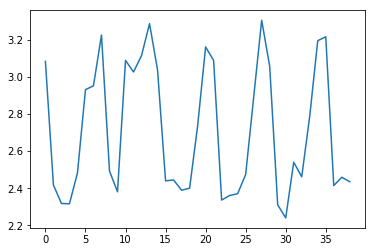

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.824511   
air_0164b9927d20bcc3_2017-04-23              1.588500   
air_0241aa3964b7f861_2017-04-23              2.481319   
air_0328696196e46f18_2017-04-23              2.297498   
air_034a3d5b40d5b1b1_2017-04-23              3.465853   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.199763  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.896398  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.957025  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   8.949260  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.003754

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')